<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-02 19:40:51.470930: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-02 19:40:51.502234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-02 19:40:51.502260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-02 19:40:51.503290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-02 19:40:51.508629: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-02 19:40:51.509119: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-02 19:40:52.228895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-02 19:40:54.580622: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

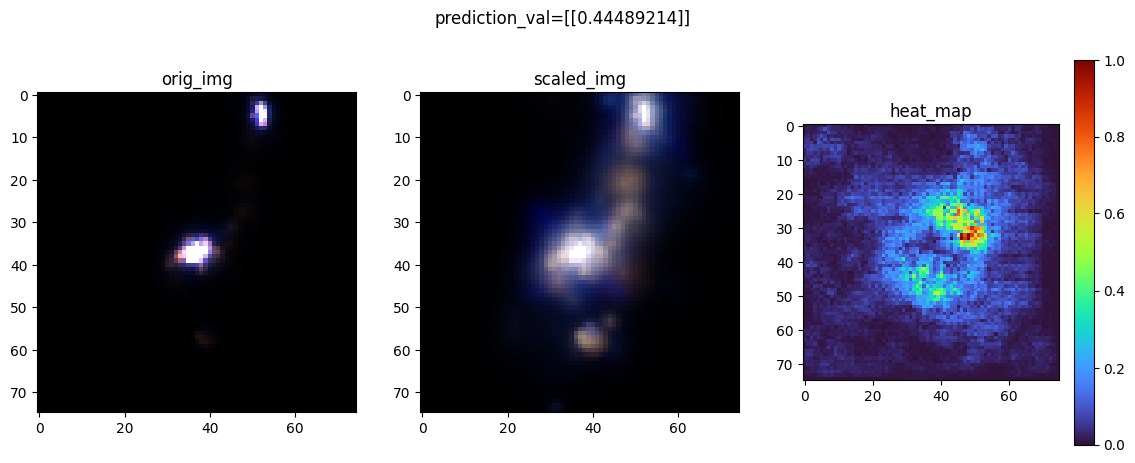

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

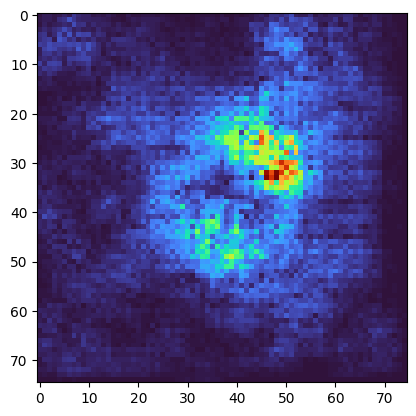

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-02 19:40:57.655825: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-02 19:40:58.513559: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-02 19:40:58.587769: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-02 19:40:58.628900: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-02 19:41:00.110643: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

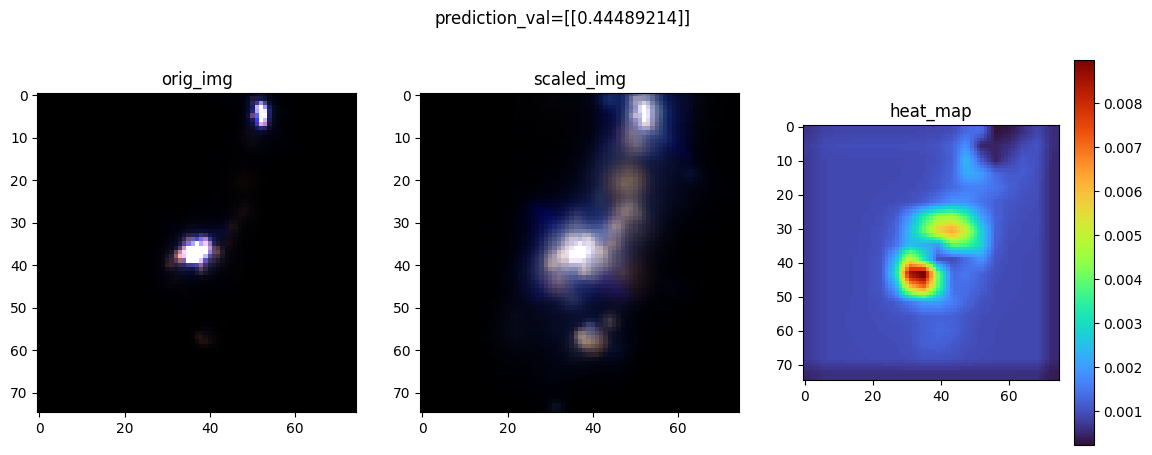

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 1s

 4/32 [==>...........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

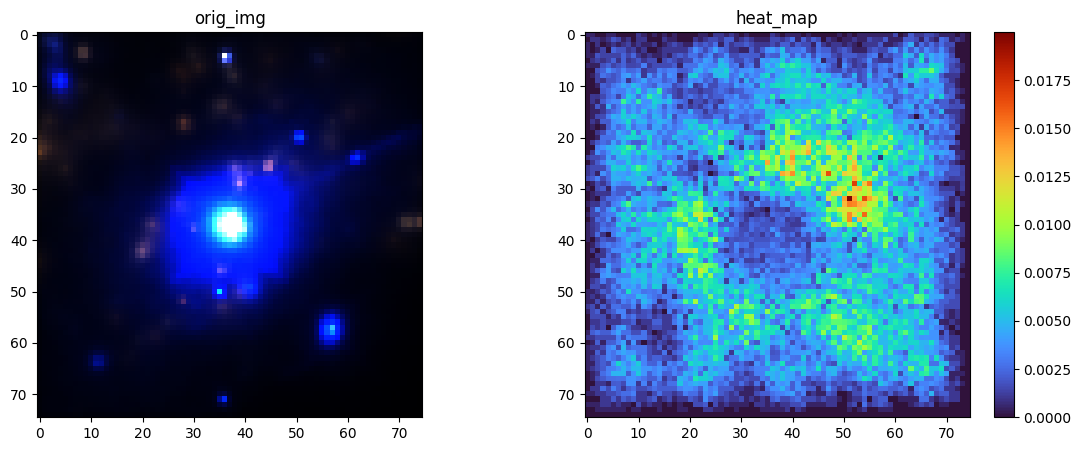

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:29 - loss: 0.7157 - accuracy: 0.3750

  2/338 [..............................] - ETA: 19s - loss: 0.7145 - accuracy: 0.3906 

  3/338 [..............................] - ETA: 19s - loss: 0.7119 - accuracy: 0.4479

  4/338 [..............................] - ETA: 19s - loss: 0.7110 - accuracy: 0.4609

  5/338 [..............................] - ETA: 18s - loss: 0.7108 - accuracy: 0.4563

  6/338 [..............................] - ETA: 18s - loss: 0.7105 - accuracy: 0.4531

  7/338 [..............................] - ETA: 18s - loss: 0.7096 - accuracy: 0.4732

  8/338 [..............................] - ETA: 18s - loss: 0.7091 - accuracy: 0.4805

  9/338 [..............................] - ETA: 18s - loss: 0.7093 - accuracy: 0.4653

 10/338 [..............................] - ETA: 18s - loss: 0.7087 - accuracy: 0.4750

 11/338 [..............................] - ETA: 19s - loss: 0.7084 - accuracy: 0.4744

 12/338 [>.............................] - ETA: 18s - loss: 0.7082 - accuracy: 0.4714

 13/338 [>.............................] - ETA: 18s - loss: 0.7078 - accuracy: 0.4784

 14/338 [>.............................] - ETA: 18s - loss: 0.7074 - accuracy: 0.4844

 15/338 [>.............................] - ETA: 18s - loss: 0.7070 - accuracy: 0.4875

 16/338 [>.............................] - ETA: 18s - loss: 0.7067 - accuracy: 0.4922

 17/338 [>.............................] - ETA: 18s - loss: 0.7066 - accuracy: 0.4853

 18/338 [>.............................] - ETA: 18s - loss: 0.7064 - accuracy: 0.4844

 19/338 [>.............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.4819

 20/338 [>.............................] - ETA: 18s - loss: 0.7060 - accuracy: 0.4828

 21/338 [>.............................] - ETA: 18s - loss: 0.7057 - accuracy: 0.4851

 22/338 [>.............................] - ETA: 18s - loss: 0.7057 - accuracy: 0.4801

 23/338 [=>............................] - ETA: 17s - loss: 0.7052 - accuracy: 0.4905

 24/338 [=>............................] - ETA: 17s - loss: 0.7051 - accuracy: 0.4870

 25/338 [=>............................] - ETA: 17s - loss: 0.7050 - accuracy: 0.4863

 26/338 [=>............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.4868

 27/338 [=>............................] - ETA: 17s - loss: 0.7045 - accuracy: 0.4896

 28/338 [=>............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.4900

 29/338 [=>............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.4914

 30/338 [=>............................] - ETA: 17s - loss: 0.7041 - accuracy: 0.4875

 31/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.4889

 32/338 [=>............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.4883

 33/338 [=>............................] - ETA: 17s - loss: 0.7036 - accuracy: 0.4848

 34/338 [==>...........................] - ETA: 17s - loss: 0.7034 - accuracy: 0.4890

 35/338 [==>...........................] - ETA: 17s - loss: 0.7032 - accuracy: 0.4911

 36/338 [==>...........................] - ETA: 17s - loss: 0.7031 - accuracy: 0.4922

 37/338 [==>...........................] - ETA: 17s - loss: 0.7029 - accuracy: 0.4907

 38/338 [==>...........................] - ETA: 16s - loss: 0.7028 - accuracy: 0.4893

 39/338 [==>...........................] - ETA: 16s - loss: 0.7028 - accuracy: 0.4864

 40/338 [==>...........................] - ETA: 16s - loss: 0.7027 - accuracy: 0.4820

 41/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.4802

 42/338 [==>...........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.4799

 43/338 [==>...........................] - ETA: 16s - loss: 0.7023 - accuracy: 0.4804

 44/338 [==>...........................] - ETA: 16s - loss: 0.7023 - accuracy: 0.4773

 45/338 [==>...........................] - ETA: 16s - loss: 0.7022 - accuracy: 0.4750

 46/338 [===>..........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.4742

 47/338 [===>..........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.4781

 48/338 [===>..........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.4792

 49/338 [===>..........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.4809

 50/338 [===>..........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.4831

 51/338 [===>..........................] - ETA: 16s - loss: 0.7015 - accuracy: 0.4841

 52/338 [===>..........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.4868

 53/338 [===>..........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.4847

 54/338 [===>..........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.4855

 55/338 [===>..........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.4830

 56/338 [===>..........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.4849

 57/338 [====>.........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.4885

 58/338 [====>.........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.4898

 59/338 [====>.........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.4905

 60/338 [====>.........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.4922

 61/338 [====>.........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.4933

 62/338 [====>.........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.4934

 63/338 [====>.........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.4931

 64/338 [====>.........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.4932

 65/338 [====>.........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.4938

 66/338 [====>.........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.4948

 67/338 [====>.........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.4949

 68/338 [=====>........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.4936

 69/338 [=====>........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.4946

 70/338 [=====>........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.4969

 71/338 [=====>........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.4974

 72/338 [=====>........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.4983

 73/338 [=====>........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.4987

 74/338 [=====>........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5000

 75/338 [=====>........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5004

 76/338 [=====>........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5004

 77/338 [=====>........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5020

 78/338 [=====>........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5020

 79/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5032

 80/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5035

 81/338 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5035

 82/338 [======>.......................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5046

 83/338 [======>.......................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5034

 84/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5060

 85/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5051

 86/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5047

 87/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5043

 88/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5036

 89/338 [======>.......................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5042

 90/338 [======>.......................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5045

 91/338 [=======>......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5041

 92/338 [=======>......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5048

 93/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5060

 94/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5063

 95/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5049

 96/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5046

 97/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5045

 98/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5054

 99/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5060

100/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5056

101/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5065

102/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5067

103/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5067

104/338 [========>.....................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5072

105/338 [========>.....................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5080

106/338 [========>.....................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5077

107/338 [========>.....................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5082

108/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5075

109/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5060

110/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5057

111/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5068

112/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5067

113/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5080

114/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5093

115/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5095

116/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5100

117/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5093

118/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5095

119/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5102

120/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5117

121/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5103

122/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5105

123/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5109

124/338 [==========>...................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5118

125/338 [==========>...................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5132

126/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5144

127/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5148

128/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5151

129/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5160

130/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5147

131/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5141

132/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5142

133/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5143

134/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5135

135/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5139

136/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5136

137/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5139

138/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5149

139/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5135

140/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5136

141/338 [===========>..................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5146

142/338 [===========>..................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5147

143/338 [===========>..................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5144

144/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5141

145/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5140

146/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5141

147/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5145

148/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5144

149/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5155

150/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5160

151/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5153

152/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5160

153/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5165

154/338 [============>.................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5170

155/338 [============>.................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5175

156/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5180

157/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5191

158/338 [=============>................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5194

159/338 [=============>................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5206

160/338 [=============>................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5197

161/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5204 

162/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5197

163/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5199

164/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5191

165/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5199

166/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5192

167/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5196

168/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5190

169/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5190

170/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5189

171/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5183

172/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5178

173/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5179

174/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5176

175/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5177

176/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5178

177/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5184

178/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5177

179/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5182

180/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5189

181/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5188

182/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5191

183/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5191

184/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5192

185/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5193

186/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5200

187/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5202

188/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5213

189/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5215

190/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5219

191/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5223

192/338 [================>.............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5215

193/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5215

194/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5217

195/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5216

196/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5225

197/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5236

198/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5234

199/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5234

200/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5234

201/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5236

202/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5235

203/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5232

204/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5231

205/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5229

206/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5225

207/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5220

208/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5221

209/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5224

210/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5220

211/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5215

212/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5215

213/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5216

214/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5215

215/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5219

216/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5216

217/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5212

218/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5211

219/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5211

220/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5216

221/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5218

222/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5217

223/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5217

224/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5222

225/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5219

226/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5214

227/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5219

228/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5210

229/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5213

230/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5213

231/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5216

232/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5220

233/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5220

234/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5222

235/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5218

236/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5215

237/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5212

238/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5217

239/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5213

240/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5217

241/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5215

242/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5213

243/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5208

244/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5215

245/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5210

246/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5213

247/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5209

248/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5209

249/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5213

250/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5213

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5214

252/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5218

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5219

254/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5215

255/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5211

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5208

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5205

258/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5201

259/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5197

260/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5201

261/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5196

262/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5193

263/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5197

264/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5199

265/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5198

266/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5201

267/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5200

268/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5197

269/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5199

270/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5200

271/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5204

272/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5203

273/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5206

274/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5204

275/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5202

276/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5200

277/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5202

278/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5200

279/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5197

280/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5194

281/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5197

282/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5199

283/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5194

284/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5193

285/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5192

286/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5198

287/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5198

288/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5196

289/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5199

290/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5204

291/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5205

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5205

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5207

294/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5202

295/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5201

296/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5202

297/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5202

298/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5201

299/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5199

300/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5197

301/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5199

302/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5195

303/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5196

304/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5197

305/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5199

306/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5200

307/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5194

308/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5191

309/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5190

310/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5192

311/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5196

312/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5197

313/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5194

314/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5191

315/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5189

316/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5185

317/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5184

318/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5185

319/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5182

320/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5183

321/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5180

322/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5182

323/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5183

324/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5180

325/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5185

326/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5183

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5183

328/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5184

329/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5183

330/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5184

331/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5182

332/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5184

333/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5182

334/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5185

335/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5188

336/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5190

337/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5197

338/338 [==============================] - 22s 62ms/step - loss: 0.6935 - accuracy: 0.5197 - val_loss: 0.6915 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6871 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6916 - accuracy: 0.5000

  3/338 [..............................] - ETA: 18s - loss: 0.6905 - accuracy: 0.5208

  4/338 [..............................] - ETA: 18s - loss: 0.6902 - accuracy: 0.5234

  5/338 [..............................] - ETA: 18s - loss: 0.6918 - accuracy: 0.5000

  6/338 [..............................] - ETA: 18s - loss: 0.6923 - accuracy: 0.4948

  7/338 [..............................] - ETA: 18s - loss: 0.6935 - accuracy: 0.4732

  8/338 [..............................] - ETA: 18s - loss: 0.6917 - accuracy: 0.4922

  9/338 [..............................] - ETA: 18s - loss: 0.6929 - accuracy: 0.4792

 10/338 [..............................] - ETA: 18s - loss: 0.6919 - accuracy: 0.4938

 11/338 [..............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5199

 12/338 [>.............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.5234

 13/338 [>.............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5312

 14/338 [>.............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5335

 15/338 [>.............................] - ETA: 18s - loss: 0.6894 - accuracy: 0.5271

 16/338 [>.............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5176

 17/338 [>.............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5221

 18/338 [>.............................] - ETA: 17s - loss: 0.6908 - accuracy: 0.5122

 19/338 [>.............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5082

 20/338 [>.............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5078

 21/338 [>.............................] - ETA: 17s - loss: 0.6915 - accuracy: 0.5060

 22/338 [>.............................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5014

 23/338 [=>............................] - ETA: 17s - loss: 0.6922 - accuracy: 0.4986

 24/338 [=>............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.4961

 25/338 [=>............................] - ETA: 17s - loss: 0.6917 - accuracy: 0.5025

 26/338 [=>............................] - ETA: 17s - loss: 0.6916 - accuracy: 0.5060

 27/338 [=>............................] - ETA: 17s - loss: 0.6915 - accuracy: 0.5058

 28/338 [=>............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5078

 29/338 [=>............................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5119

 30/338 [=>............................] - ETA: 17s - loss: 0.6906 - accuracy: 0.5146

 31/338 [=>............................] - ETA: 17s - loss: 0.6906 - accuracy: 0.5141

 32/338 [=>............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5127

 33/338 [=>............................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5123

 34/338 [==>...........................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5101

 35/338 [==>...........................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5107

 36/338 [==>...........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5148

 37/338 [==>...........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5144

 38/338 [==>...........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5156

 39/338 [==>...........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5184

 40/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5195

 41/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5198

 42/338 [==>...........................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5201

 43/338 [==>...........................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5196

 44/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5178

 45/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5188

 46/338 [===>..........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5190

 47/338 [===>..........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5160

 48/338 [===>..........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5150

 49/338 [===>..........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5172

 50/338 [===>..........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5150

 51/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5153

 52/338 [===>..........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5162

 53/338 [===>..........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5171

 54/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5139

 55/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5136

 56/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5162

 57/338 [====>.........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5137

 58/338 [====>.........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5135

 59/338 [====>.........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5127

 60/338 [====>.........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5130

 61/338 [====>.........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5138

 62/338 [====>.........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5146

 63/338 [====>.........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5174

 64/338 [====>.........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5171

 65/338 [====>.........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5188

 66/338 [====>.........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5180

 67/338 [====>.........................] - ETA: 15s - loss: 0.6900 - accuracy: 0.5205

 68/338 [=====>........................] - ETA: 15s - loss: 0.6900 - accuracy: 0.5207

 69/338 [=====>........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5199

 70/338 [=====>........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5196

 71/338 [=====>........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5185

 72/338 [=====>........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5191

 73/338 [=====>........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5180

 74/338 [=====>........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5182

 75/338 [=====>........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5196

 76/338 [=====>........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5193

 77/338 [=====>........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5207

 78/338 [=====>........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5200

 79/338 [======>.......................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5202

 80/338 [======>.......................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5199

 81/338 [======>.......................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5212

 82/338 [======>.......................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5236

 83/338 [======>.......................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5230

 84/338 [======>.......................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5216

 85/338 [======>.......................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5217

 86/338 [======>.......................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5207

 87/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5212

 88/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5227

 89/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5225

 90/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5215

 91/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5237

 92/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5234

 93/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5228

 94/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5233

 95/338 [=======>......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5217

 96/338 [=======>......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5212

 97/338 [=======>......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5193

 98/338 [=======>......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5185

 99/338 [=======>......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5186

100/338 [=======>......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5197

101/338 [=======>......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5204

102/338 [========>.....................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5199

103/338 [========>.....................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5197

104/338 [========>.....................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5204

105/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5196

106/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5200

107/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5207

108/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5203

109/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5195

110/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5202

111/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5214

112/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5218

113/338 [=========>....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5221

114/338 [=========>....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5219

115/338 [=========>....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5220

116/338 [=========>....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5221

117/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5230

118/338 [=========>....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5241

119/338 [=========>....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5236

120/338 [=========>....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5242

121/338 [=========>....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5238

122/338 [=========>....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5236

123/338 [=========>....................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5239

124/338 [==========>...................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5239

125/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5242

126/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5246

127/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5246

128/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5244

129/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5242

130/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5243

131/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5239

132/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5239

133/338 [==========>...................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5240

134/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5243

135/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5248

136/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5248

137/338 [===========>..................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5242

138/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5240

139/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5243

140/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5239

141/338 [===========>..................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5250

142/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5249

143/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5240

144/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5256

145/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5248

146/338 [===========>..................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5257

147/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5251

148/338 [============>.................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5262

149/338 [============>.................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5256

150/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5260

151/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5261

152/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5269

153/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5270

154/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5270

155/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5272

156/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5272

157/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5271

158/338 [=============>................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5265

159/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5259 

160/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5258

161/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5254

162/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5255

163/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5257

164/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5255

165/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5258

166/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5258

167/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5253

168/338 [=============>................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5249

169/338 [==============>...............] - ETA: 9s - loss: 0.6887 - accuracy: 0.5259

170/338 [==============>...............] - ETA: 9s - loss: 0.6886 - accuracy: 0.5265

171/338 [==============>...............] - ETA: 9s - loss: 0.6885 - accuracy: 0.5267

172/338 [==============>...............] - ETA: 9s - loss: 0.6884 - accuracy: 0.5271

173/338 [==============>...............] - ETA: 9s - loss: 0.6884 - accuracy: 0.5273

174/338 [==============>...............] - ETA: 9s - loss: 0.6884 - accuracy: 0.5273

175/338 [==============>...............] - ETA: 9s - loss: 0.6884 - accuracy: 0.5273

176/338 [==============>...............] - ETA: 9s - loss: 0.6883 - accuracy: 0.5279

177/338 [==============>...............] - ETA: 9s - loss: 0.6884 - accuracy: 0.5281

178/338 [==============>...............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5281

179/338 [==============>...............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5283

180/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5276

181/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5280

182/338 [===============>..............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5283

183/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5283

184/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5284

185/338 [===============>..............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5287

186/338 [===============>..............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5287

187/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5276

188/338 [===============>..............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5281

189/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5274

190/338 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5275

191/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5272

192/338 [================>.............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5272

193/338 [================>.............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5274

194/338 [================>.............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5282

195/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5272

196/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5263

197/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5268

198/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5257

199/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5262

200/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5263

201/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5260

202/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5266

203/338 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5266

204/338 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5263

205/338 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5259

206/338 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5258

207/338 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5261

208/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5263

209/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5262

210/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5265

211/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5262

212/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5262

213/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5261

214/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5264

215/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5265

216/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5265

217/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5264

218/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5258

219/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5250

220/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5250

221/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5253

222/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5256

223/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5256

224/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5264

225/338 [==================>...........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5263

226/338 [===================>..........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5260

227/338 [===================>..........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5266

228/338 [===================>..........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5269

229/338 [===================>..........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5273

230/338 [===================>..........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5269

231/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5267

232/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5271

233/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5268

234/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5267

235/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5267

236/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5270

237/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5265

238/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5269

239/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5259

240/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5260

241/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5261

242/338 [====================>.........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5257

243/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5258

244/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5256

245/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5264

246/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5260

247/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5259

248/338 [=====================>........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5261

249/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5259

250/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5259

251/338 [=====================>........] - ETA: 4s - loss: 0.6878 - accuracy: 0.5264

252/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5273

253/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5275

254/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5281

255/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5281

256/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5286

257/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5285

258/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5281

259/338 [=====================>........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5287

260/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5288

261/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5291

262/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5293

263/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5291

264/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5296

265/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5298

266/338 [======================>.......] - ETA: 4s - loss: 0.6874 - accuracy: 0.5300

267/338 [======================>.......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5301

268/338 [======================>.......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5306

269/338 [======================>.......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5307

270/338 [======================>.......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5309

271/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5316

272/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5317

273/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5321

274/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5325

275/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5324

276/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5318

277/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5325

278/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5326

279/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5328

280/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5331

281/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5333

282/338 [========================>.....] - ETA: 3s - loss: 0.6874 - accuracy: 0.5339

283/338 [========================>.....] - ETA: 3s - loss: 0.6873 - accuracy: 0.5340

284/338 [========================>.....] - ETA: 3s - loss: 0.6872 - accuracy: 0.5346

285/338 [========================>.....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5349

286/338 [========================>.....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5353

287/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5350

288/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5348

289/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5350

290/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5344

291/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5343

292/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5342

293/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5343

294/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5345

295/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5347

296/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5348

297/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5356

298/338 [=========================>....] - ETA: 2s - loss: 0.6871 - accuracy: 0.5364

299/338 [=========================>....] - ETA: 2s - loss: 0.6871 - accuracy: 0.5365

300/338 [=========================>....] - ETA: 2s - loss: 0.6870 - accuracy: 0.5364

301/338 [=========================>....] - ETA: 2s - loss: 0.6870 - accuracy: 0.5362

302/338 [=========================>....] - ETA: 2s - loss: 0.6870 - accuracy: 0.5365

303/338 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5363

304/338 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5363

305/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5362

306/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5358

307/338 [==========================>...] - ETA: 1s - loss: 0.6871 - accuracy: 0.5353

308/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5354

309/338 [==========================>...] - ETA: 1s - loss: 0.6871 - accuracy: 0.5352

310/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5352

311/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5355

312/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5356

313/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5362

314/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5360

315/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5360

316/338 [===========================>..] - ETA: 1s - loss: 0.6868 - accuracy: 0.5364

317/338 [===========================>..] - ETA: 1s - loss: 0.6867 - accuracy: 0.5363

318/338 [===========================>..] - ETA: 1s - loss: 0.6868 - accuracy: 0.5361

319/338 [===========================>..] - ETA: 1s - loss: 0.6868 - accuracy: 0.5357

320/338 [===========================>..] - ETA: 1s - loss: 0.6868 - accuracy: 0.5357

321/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5353

322/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5354

323/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5355

324/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5352

325/338 [===========================>..] - ETA: 0s - loss: 0.6867 - accuracy: 0.5351

326/338 [===========================>..] - ETA: 0s - loss: 0.6867 - accuracy: 0.5349

327/338 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.5348

328/338 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5349

329/338 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5353

330/338 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5352

331/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5356

332/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5360

333/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5362

334/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5363

335/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5367

336/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5369

337/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5367

338/338 [==============================] - 20s 60ms/step - loss: 0.6865 - accuracy: 0.5369 - val_loss: 0.6827 - val_accuracy: 0.6104


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6595 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6730 - accuracy: 0.5781

  3/338 [..............................] - ETA: 18s - loss: 0.6746 - accuracy: 0.5521

  4/338 [..............................] - ETA: 18s - loss: 0.6764 - accuracy: 0.5547

  5/338 [..............................] - ETA: 18s - loss: 0.6780 - accuracy: 0.5562

  6/338 [..............................] - ETA: 18s - loss: 0.6784 - accuracy: 0.5677

  7/338 [..............................] - ETA: 18s - loss: 0.6749 - accuracy: 0.5982

  8/338 [..............................] - ETA: 18s - loss: 0.6767 - accuracy: 0.6016

  9/338 [..............................] - ETA: 18s - loss: 0.6774 - accuracy: 0.5972

 10/338 [..............................] - ETA: 18s - loss: 0.6743 - accuracy: 0.6125

 11/338 [..............................] - ETA: 18s - loss: 0.6731 - accuracy: 0.6193

 12/338 [>.............................] - ETA: 18s - loss: 0.6753 - accuracy: 0.6094

 13/338 [>.............................] - ETA: 18s - loss: 0.6750 - accuracy: 0.6178

 14/338 [>.............................] - ETA: 18s - loss: 0.6760 - accuracy: 0.6183

 15/338 [>.............................] - ETA: 18s - loss: 0.6772 - accuracy: 0.6083

 16/338 [>.............................] - ETA: 18s - loss: 0.6772 - accuracy: 0.6094

 17/338 [>.............................] - ETA: 18s - loss: 0.6762 - accuracy: 0.6176

 18/338 [>.............................] - ETA: 18s - loss: 0.6772 - accuracy: 0.6128

 19/338 [>.............................] - ETA: 17s - loss: 0.6767 - accuracy: 0.6168

 20/338 [>.............................] - ETA: 17s - loss: 0.6777 - accuracy: 0.6141

 21/338 [>.............................] - ETA: 17s - loss: 0.6783 - accuracy: 0.6101

 22/338 [>.............................] - ETA: 17s - loss: 0.6787 - accuracy: 0.6080

 23/338 [=>............................] - ETA: 17s - loss: 0.6789 - accuracy: 0.6005

 24/338 [=>............................] - ETA: 17s - loss: 0.6799 - accuracy: 0.5938

 25/338 [=>............................] - ETA: 17s - loss: 0.6812 - accuracy: 0.5900

 26/338 [=>............................] - ETA: 17s - loss: 0.6815 - accuracy: 0.5913

 27/338 [=>............................] - ETA: 17s - loss: 0.6818 - accuracy: 0.5926

 28/338 [=>............................] - ETA: 17s - loss: 0.6825 - accuracy: 0.5871

 29/338 [=>............................] - ETA: 17s - loss: 0.6827 - accuracy: 0.5884

 30/338 [=>............................] - ETA: 17s - loss: 0.6830 - accuracy: 0.5854

 31/338 [=>............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.5837

 32/338 [=>............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.5811

 33/338 [=>............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.5795

 34/338 [==>...........................] - ETA: 17s - loss: 0.6830 - accuracy: 0.5809

 35/338 [==>...........................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5804

 36/338 [==>...........................] - ETA: 16s - loss: 0.6829 - accuracy: 0.5807

 37/338 [==>...........................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5802

 38/338 [==>...........................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5765

 39/338 [==>...........................] - ETA: 16s - loss: 0.6833 - accuracy: 0.5777

 40/338 [==>...........................] - ETA: 16s - loss: 0.6836 - accuracy: 0.5797

 41/338 [==>...........................] - ETA: 16s - loss: 0.6834 - accuracy: 0.5854

 42/338 [==>...........................] - ETA: 16s - loss: 0.6834 - accuracy: 0.5848

 43/338 [==>...........................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5836

 44/338 [==>...........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5824

 45/338 [==>...........................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5833

 46/338 [===>..........................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5815

 47/338 [===>..........................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5805

 48/338 [===>..........................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5833

 49/338 [===>..........................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5861

 50/338 [===>..........................] - ETA: 16s - loss: 0.6829 - accuracy: 0.5863

 51/338 [===>..........................] - ETA: 16s - loss: 0.6828 - accuracy: 0.5882

 52/338 [===>..........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.5901

 53/338 [===>..........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.5932

 54/338 [===>..........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.5932

 55/338 [===>..........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.5926

 56/338 [===>..........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.5921

 57/338 [====>.........................] - ETA: 15s - loss: 0.6823 - accuracy: 0.5943

 58/338 [====>.........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.5997

 59/338 [====>.........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6017

 60/338 [====>.........................] - ETA: 15s - loss: 0.6816 - accuracy: 0.6031

 61/338 [====>.........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6030

 62/338 [====>.........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6018

 63/338 [====>.........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6022

 64/338 [====>.........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6025

 65/338 [====>.........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6029

 66/338 [====>.........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.6037

 67/338 [====>.........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6040

 68/338 [=====>........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6043

 69/338 [=====>........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6028

 70/338 [=====>........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.6027

 71/338 [=====>........................] - ETA: 14s - loss: 0.6820 - accuracy: 0.6026

 72/338 [=====>........................] - ETA: 14s - loss: 0.6819 - accuracy: 0.6029

 73/338 [=====>........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.6045

 74/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6030

 75/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6033

 76/338 [=====>........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.6036

 77/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6027

 78/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6022

 79/338 [======>.......................] - ETA: 14s - loss: 0.6820 - accuracy: 0.6013

 80/338 [======>.......................] - ETA: 14s - loss: 0.6817 - accuracy: 0.6023

 81/338 [======>.......................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6015

 82/338 [======>.......................] - ETA: 14s - loss: 0.6819 - accuracy: 0.6010

 83/338 [======>.......................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5990

 84/338 [======>.......................] - ETA: 14s - loss: 0.6823 - accuracy: 0.5990

 85/338 [======>.......................] - ETA: 14s - loss: 0.6821 - accuracy: 0.5996

 86/338 [======>.......................] - ETA: 14s - loss: 0.6821 - accuracy: 0.5999

 87/338 [======>.......................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6020

 88/338 [======>.......................] - ETA: 13s - loss: 0.6819 - accuracy: 0.6016

 89/338 [======>.......................] - ETA: 13s - loss: 0.6820 - accuracy: 0.6015

 90/338 [======>.......................] - ETA: 13s - loss: 0.6822 - accuracy: 0.6003

 91/338 [=======>......................] - ETA: 13s - loss: 0.6821 - accuracy: 0.6010

 92/338 [=======>......................] - ETA: 13s - loss: 0.6822 - accuracy: 0.5999

 93/338 [=======>......................] - ETA: 13s - loss: 0.6820 - accuracy: 0.6011

 94/338 [=======>......................] - ETA: 13s - loss: 0.6821 - accuracy: 0.6001

 95/338 [=======>......................] - ETA: 13s - loss: 0.6821 - accuracy: 0.6003

 96/338 [=======>......................] - ETA: 13s - loss: 0.6819 - accuracy: 0.6012

 97/338 [=======>......................] - ETA: 13s - loss: 0.6819 - accuracy: 0.6008

 98/338 [=======>......................] - ETA: 13s - loss: 0.6817 - accuracy: 0.6017

 99/338 [=======>......................] - ETA: 13s - loss: 0.6817 - accuracy: 0.6016

100/338 [=======>......................] - ETA: 13s - loss: 0.6816 - accuracy: 0.6028

101/338 [=======>......................] - ETA: 13s - loss: 0.6816 - accuracy: 0.6018

102/338 [========>.....................] - ETA: 13s - loss: 0.6817 - accuracy: 0.6017

103/338 [========>.....................] - ETA: 13s - loss: 0.6816 - accuracy: 0.6013

104/338 [========>.....................] - ETA: 13s - loss: 0.6816 - accuracy: 0.6016

105/338 [========>.....................] - ETA: 13s - loss: 0.6815 - accuracy: 0.6018

106/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6026

107/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6031

108/338 [========>.....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.6030

109/338 [========>.....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6015

110/338 [========>.....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6017

111/338 [========>.....................] - ETA: 12s - loss: 0.6817 - accuracy: 0.6011

112/338 [========>.....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6010

113/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6012

114/338 [=========>....................] - ETA: 12s - loss: 0.6817 - accuracy: 0.6006

115/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6005

116/338 [=========>....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.6010

117/338 [=========>....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6015

118/338 [=========>....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.6006

119/338 [=========>....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.6003

120/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.5995

121/338 [=========>....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.5999

122/338 [=========>....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.5999

123/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.5991

124/338 [==========>...................] - ETA: 11s - loss: 0.6815 - accuracy: 0.5998

125/338 [==========>...................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5993

126/338 [==========>...................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5990

127/338 [==========>...................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5997

128/338 [==========>...................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5986

129/338 [==========>...................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5993

130/338 [==========>...................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5990

131/338 [==========>...................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5990

132/338 [==========>...................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5985

133/338 [==========>...................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5982

134/338 [==========>...................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5972

135/338 [==========>...................] - ETA: 11s - loss: 0.6818 - accuracy: 0.5977

136/338 [===========>..................] - ETA: 11s - loss: 0.6818 - accuracy: 0.5979

137/338 [===========>..................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5985

138/338 [===========>..................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5990

139/338 [===========>..................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5985

140/338 [===========>..................] - ETA: 11s - loss: 0.6820 - accuracy: 0.5975

141/338 [===========>..................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5964

142/338 [===========>..................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5960

143/338 [===========>..................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5953

144/338 [===========>..................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5946

145/338 [===========>..................] - ETA: 10s - loss: 0.6825 - accuracy: 0.5942

146/338 [===========>..................] - ETA: 10s - loss: 0.6826 - accuracy: 0.5931

147/338 [============>.................] - ETA: 10s - loss: 0.6825 - accuracy: 0.5935

148/338 [============>.................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5935

149/338 [============>.................] - ETA: 10s - loss: 0.6827 - accuracy: 0.5925

150/338 [============>.................] - ETA: 10s - loss: 0.6826 - accuracy: 0.5927

151/338 [============>.................] - ETA: 10s - loss: 0.6827 - accuracy: 0.5925

152/338 [============>.................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5921

153/338 [============>.................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5915

154/338 [============>.................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5917

155/338 [============>.................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5919

156/338 [============>.................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5915

157/338 [============>.................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5916

158/338 [=============>................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5918

159/338 [=============>................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5916

160/338 [=============>................] - ETA: 9s - loss: 0.6828 - accuracy: 0.5924 

161/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5932

162/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5924

163/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5918

164/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5913

165/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5913

166/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5915

167/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5919

168/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5917

169/338 [==============>...............] - ETA: 9s - loss: 0.6825 - accuracy: 0.5919

170/338 [==============>...............] - ETA: 9s - loss: 0.6825 - accuracy: 0.5917

171/338 [==============>...............] - ETA: 9s - loss: 0.6824 - accuracy: 0.5916

172/338 [==============>...............] - ETA: 9s - loss: 0.6822 - accuracy: 0.5925

173/338 [==============>...............] - ETA: 9s - loss: 0.6822 - accuracy: 0.5923

174/338 [==============>...............] - ETA: 9s - loss: 0.6822 - accuracy: 0.5918

175/338 [==============>...............] - ETA: 9s - loss: 0.6822 - accuracy: 0.5914

176/338 [==============>...............] - ETA: 9s - loss: 0.6821 - accuracy: 0.5923

177/338 [==============>...............] - ETA: 8s - loss: 0.6820 - accuracy: 0.5929

178/338 [==============>...............] - ETA: 8s - loss: 0.6820 - accuracy: 0.5936

179/338 [==============>...............] - ETA: 8s - loss: 0.6821 - accuracy: 0.5931

180/338 [==============>...............] - ETA: 8s - loss: 0.6819 - accuracy: 0.5943

181/338 [===============>..............] - ETA: 8s - loss: 0.6817 - accuracy: 0.5950

182/338 [===============>..............] - ETA: 8s - loss: 0.6816 - accuracy: 0.5951

183/338 [===============>..............] - ETA: 8s - loss: 0.6817 - accuracy: 0.5951

184/338 [===============>..............] - ETA: 8s - loss: 0.6814 - accuracy: 0.5961

185/338 [===============>..............] - ETA: 8s - loss: 0.6815 - accuracy: 0.5956

186/338 [===============>..............] - ETA: 8s - loss: 0.6815 - accuracy: 0.5951

187/338 [===============>..............] - ETA: 8s - loss: 0.6813 - accuracy: 0.5958

188/338 [===============>..............] - ETA: 8s - loss: 0.6813 - accuracy: 0.5954

189/338 [===============>..............] - ETA: 8s - loss: 0.6813 - accuracy: 0.5956

190/338 [===============>..............] - ETA: 8s - loss: 0.6813 - accuracy: 0.5961

191/338 [===============>..............] - ETA: 8s - loss: 0.6812 - accuracy: 0.5965

192/338 [================>.............] - ETA: 8s - loss: 0.6812 - accuracy: 0.5967

193/338 [================>.............] - ETA: 8s - loss: 0.6811 - accuracy: 0.5968

194/338 [================>.............] - ETA: 8s - loss: 0.6810 - accuracy: 0.5973

195/338 [================>.............] - ETA: 7s - loss: 0.6808 - accuracy: 0.5986

196/338 [================>.............] - ETA: 7s - loss: 0.6807 - accuracy: 0.5990

197/338 [================>.............] - ETA: 7s - loss: 0.6810 - accuracy: 0.5985

198/338 [================>.............] - ETA: 7s - loss: 0.6811 - accuracy: 0.5985

199/338 [================>.............] - ETA: 7s - loss: 0.6813 - accuracy: 0.5977

200/338 [================>.............] - ETA: 7s - loss: 0.6811 - accuracy: 0.5984

201/338 [================>.............] - ETA: 7s - loss: 0.6810 - accuracy: 0.5984

202/338 [================>.............] - ETA: 7s - loss: 0.6810 - accuracy: 0.5985

203/338 [=================>............] - ETA: 7s - loss: 0.6810 - accuracy: 0.5987

204/338 [=================>............] - ETA: 7s - loss: 0.6810 - accuracy: 0.5991

205/338 [=================>............] - ETA: 7s - loss: 0.6811 - accuracy: 0.5986

206/338 [=================>............] - ETA: 7s - loss: 0.6809 - accuracy: 0.5991

207/338 [=================>............] - ETA: 7s - loss: 0.6810 - accuracy: 0.5990

208/338 [=================>............] - ETA: 7s - loss: 0.6809 - accuracy: 0.5992

209/338 [=================>............] - ETA: 7s - loss: 0.6808 - accuracy: 0.5993

210/338 [=================>............] - ETA: 7s - loss: 0.6808 - accuracy: 0.5993

211/338 [=================>............] - ETA: 7s - loss: 0.6809 - accuracy: 0.5994

212/338 [=================>............] - ETA: 7s - loss: 0.6809 - accuracy: 0.5996

213/338 [=================>............] - ETA: 6s - loss: 0.6807 - accuracy: 0.6005

214/338 [=================>............] - ETA: 6s - loss: 0.6808 - accuracy: 0.6000

215/338 [==================>...........] - ETA: 6s - loss: 0.6809 - accuracy: 0.5999

216/338 [==================>...........] - ETA: 6s - loss: 0.6808 - accuracy: 0.6001

217/338 [==================>...........] - ETA: 6s - loss: 0.6808 - accuracy: 0.5999

218/338 [==================>...........] - ETA: 6s - loss: 0.6809 - accuracy: 0.5993

219/338 [==================>...........] - ETA: 6s - loss: 0.6808 - accuracy: 0.6000

220/338 [==================>...........] - ETA: 6s - loss: 0.6809 - accuracy: 0.6001

221/338 [==================>...........] - ETA: 6s - loss: 0.6809 - accuracy: 0.6003

222/338 [==================>...........] - ETA: 6s - loss: 0.6809 - accuracy: 0.6002

223/338 [==================>...........] - ETA: 6s - loss: 0.6809 - accuracy: 0.6003

224/338 [==================>...........] - ETA: 6s - loss: 0.6809 - accuracy: 0.6003

225/338 [==================>...........] - ETA: 6s - loss: 0.6807 - accuracy: 0.6012

226/338 [===================>..........] - ETA: 6s - loss: 0.6808 - accuracy: 0.6012

227/338 [===================>..........] - ETA: 6s - loss: 0.6808 - accuracy: 0.6013

228/338 [===================>..........] - ETA: 6s - loss: 0.6808 - accuracy: 0.6013

229/338 [===================>..........] - ETA: 6s - loss: 0.6807 - accuracy: 0.6014

230/338 [===================>..........] - ETA: 6s - loss: 0.6806 - accuracy: 0.6018

231/338 [===================>..........] - ETA: 5s - loss: 0.6807 - accuracy: 0.6017

232/338 [===================>..........] - ETA: 5s - loss: 0.6806 - accuracy: 0.6022

233/338 [===================>..........] - ETA: 5s - loss: 0.6805 - accuracy: 0.6023

234/338 [===================>..........] - ETA: 5s - loss: 0.6805 - accuracy: 0.6023

235/338 [===================>..........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6029

236/338 [===================>..........] - ETA: 5s - loss: 0.6805 - accuracy: 0.6026

237/338 [====================>.........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6028

238/338 [====================>.........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6032

239/338 [====================>.........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6033

240/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6036

241/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6040

242/338 [====================>.........] - ETA: 5s - loss: 0.6802 - accuracy: 0.6037

243/338 [====================>.........] - ETA: 5s - loss: 0.6802 - accuracy: 0.6039

244/338 [====================>.........] - ETA: 5s - loss: 0.6802 - accuracy: 0.6039

245/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6033

246/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6037

247/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6037

248/338 [=====================>........] - ETA: 5s - loss: 0.6802 - accuracy: 0.6046

249/338 [=====================>........] - ETA: 4s - loss: 0.6801 - accuracy: 0.6049

250/338 [=====================>........] - ETA: 4s - loss: 0.6799 - accuracy: 0.6056

251/338 [=====================>........] - ETA: 4s - loss: 0.6798 - accuracy: 0.6058

252/338 [=====================>........] - ETA: 4s - loss: 0.6799 - accuracy: 0.6054

253/338 [=====================>........] - ETA: 4s - loss: 0.6800 - accuracy: 0.6049

254/338 [=====================>........] - ETA: 4s - loss: 0.6798 - accuracy: 0.6054

255/338 [=====================>........] - ETA: 4s - loss: 0.6798 - accuracy: 0.6054

256/338 [=====================>........] - ETA: 4s - loss: 0.6797 - accuracy: 0.6052

257/338 [=====================>........] - ETA: 4s - loss: 0.6796 - accuracy: 0.6057

258/338 [=====================>........] - ETA: 4s - loss: 0.6796 - accuracy: 0.6057

259/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6057

260/338 [======================>.......] - ETA: 4s - loss: 0.6794 - accuracy: 0.6059

261/338 [======================>.......] - ETA: 4s - loss: 0.6794 - accuracy: 0.6056

262/338 [======================>.......] - ETA: 4s - loss: 0.6795 - accuracy: 0.6056

263/338 [======================>.......] - ETA: 4s - loss: 0.6795 - accuracy: 0.6055

264/338 [======================>.......] - ETA: 4s - loss: 0.6793 - accuracy: 0.6061

265/338 [======================>.......] - ETA: 4s - loss: 0.6792 - accuracy: 0.6062

266/338 [======================>.......] - ETA: 4s - loss: 0.6793 - accuracy: 0.6060

267/338 [======================>.......] - ETA: 3s - loss: 0.6792 - accuracy: 0.6062

268/338 [======================>.......] - ETA: 3s - loss: 0.6793 - accuracy: 0.6060

269/338 [======================>.......] - ETA: 3s - loss: 0.6793 - accuracy: 0.6061

270/338 [======================>.......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6067

271/338 [=======================>......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6070

272/338 [=======================>......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6075

273/338 [=======================>......] - ETA: 3s - loss: 0.6788 - accuracy: 0.6076

274/338 [=======================>......] - ETA: 3s - loss: 0.6787 - accuracy: 0.6078

275/338 [=======================>......] - ETA: 3s - loss: 0.6788 - accuracy: 0.6070

276/338 [=======================>......] - ETA: 3s - loss: 0.6788 - accuracy: 0.6069

277/338 [=======================>......] - ETA: 3s - loss: 0.6787 - accuracy: 0.6073

278/338 [=======================>......] - ETA: 3s - loss: 0.6788 - accuracy: 0.6069

279/338 [=======================>......] - ETA: 3s - loss: 0.6787 - accuracy: 0.6072

280/338 [=======================>......] - ETA: 3s - loss: 0.6787 - accuracy: 0.6071

281/338 [=======================>......] - ETA: 3s - loss: 0.6786 - accuracy: 0.6078

282/338 [========================>.....] - ETA: 3s - loss: 0.6786 - accuracy: 0.6078

283/338 [========================>.....] - ETA: 3s - loss: 0.6785 - accuracy: 0.6080

284/338 [========================>.....] - ETA: 3s - loss: 0.6785 - accuracy: 0.6077

285/338 [========================>.....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6078

286/338 [========================>.....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6080

287/338 [========================>.....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6077

288/338 [========================>.....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6079

289/338 [========================>.....] - ETA: 2s - loss: 0.6784 - accuracy: 0.6081

290/338 [========================>.....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6080

291/338 [========================>.....] - ETA: 2s - loss: 0.6784 - accuracy: 0.6079

292/338 [========================>.....] - ETA: 2s - loss: 0.6784 - accuracy: 0.6079

293/338 [=========================>....] - ETA: 2s - loss: 0.6783 - accuracy: 0.6081

294/338 [=========================>....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6077

295/338 [=========================>....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6073

296/338 [=========================>....] - ETA: 2s - loss: 0.6784 - accuracy: 0.6078

297/338 [=========================>....] - ETA: 2s - loss: 0.6783 - accuracy: 0.6077

298/338 [=========================>....] - ETA: 2s - loss: 0.6783 - accuracy: 0.6076

299/338 [=========================>....] - ETA: 2s - loss: 0.6783 - accuracy: 0.6075

300/338 [=========================>....] - ETA: 2s - loss: 0.6783 - accuracy: 0.6079

301/338 [=========================>....] - ETA: 2s - loss: 0.6784 - accuracy: 0.6077

302/338 [=========================>....] - ETA: 2s - loss: 0.6783 - accuracy: 0.6079

303/338 [=========================>....] - ETA: 1s - loss: 0.6782 - accuracy: 0.6083

304/338 [=========================>....] - ETA: 1s - loss: 0.6782 - accuracy: 0.6086

305/338 [==========================>...] - ETA: 1s - loss: 0.6783 - accuracy: 0.6082

306/338 [==========================>...] - ETA: 1s - loss: 0.6782 - accuracy: 0.6086

307/338 [==========================>...] - ETA: 1s - loss: 0.6781 - accuracy: 0.6086

308/338 [==========================>...] - ETA: 1s - loss: 0.6781 - accuracy: 0.6088

309/338 [==========================>...] - ETA: 1s - loss: 0.6780 - accuracy: 0.6090

310/338 [==========================>...] - ETA: 1s - loss: 0.6778 - accuracy: 0.6095

311/338 [==========================>...] - ETA: 1s - loss: 0.6779 - accuracy: 0.6094

312/338 [==========================>...] - ETA: 1s - loss: 0.6778 - accuracy: 0.6095

313/338 [==========================>...] - ETA: 1s - loss: 0.6778 - accuracy: 0.6096

314/338 [==========================>...] - ETA: 1s - loss: 0.6777 - accuracy: 0.6101

315/338 [==========================>...] - ETA: 1s - loss: 0.6777 - accuracy: 0.6102

316/338 [===========================>..] - ETA: 1s - loss: 0.6777 - accuracy: 0.6102

317/338 [===========================>..] - ETA: 1s - loss: 0.6776 - accuracy: 0.6100

318/338 [===========================>..] - ETA: 1s - loss: 0.6775 - accuracy: 0.6101

319/338 [===========================>..] - ETA: 1s - loss: 0.6776 - accuracy: 0.6097

320/338 [===========================>..] - ETA: 1s - loss: 0.6776 - accuracy: 0.6099

321/338 [===========================>..] - ETA: 0s - loss: 0.6775 - accuracy: 0.6102

322/338 [===========================>..] - ETA: 0s - loss: 0.6774 - accuracy: 0.6105

323/338 [===========================>..] - ETA: 0s - loss: 0.6775 - accuracy: 0.6104

324/338 [===========================>..] - ETA: 0s - loss: 0.6774 - accuracy: 0.6106

325/338 [===========================>..] - ETA: 0s - loss: 0.6775 - accuracy: 0.6105

326/338 [===========================>..] - ETA: 0s - loss: 0.6777 - accuracy: 0.6101

327/338 [============================>.] - ETA: 0s - loss: 0.6776 - accuracy: 0.6105

328/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6103

329/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6100

330/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6100

331/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6101

332/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6101

333/338 [============================>.] - ETA: 0s - loss: 0.6776 - accuracy: 0.6101

334/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6104

335/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6101

336/338 [============================>.] - ETA: 0s - loss: 0.6776 - accuracy: 0.6099

337/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6099

338/338 [==============================] - 20s 60ms/step - loss: 0.6777 - accuracy: 0.6100 - val_loss: 0.6735 - val_accuracy: 0.6043


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6477 - accuracy: 0.7188

  2/338 [..............................] - ETA: 22s - loss: 0.6693 - accuracy: 0.6406

  3/338 [..............................] - ETA: 20s - loss: 0.6801 - accuracy: 0.6042

  4/338 [..............................] - ETA: 19s - loss: 0.6785 - accuracy: 0.6250

  5/338 [..............................] - ETA: 19s - loss: 0.6865 - accuracy: 0.6062

  6/338 [..............................] - ETA: 19s - loss: 0.6827 - accuracy: 0.6198

  7/338 [..............................] - ETA: 19s - loss: 0.6827 - accuracy: 0.6071

  8/338 [..............................] - ETA: 19s - loss: 0.6842 - accuracy: 0.5938

  9/338 [..............................] - ETA: 18s - loss: 0.6857 - accuracy: 0.5903

 10/338 [..............................] - ETA: 18s - loss: 0.6783 - accuracy: 0.6125

 11/338 [..............................] - ETA: 18s - loss: 0.6788 - accuracy: 0.6165

 12/338 [>.............................] - ETA: 18s - loss: 0.6778 - accuracy: 0.6172

 13/338 [>.............................] - ETA: 18s - loss: 0.6802 - accuracy: 0.6082

 14/338 [>.............................] - ETA: 18s - loss: 0.6824 - accuracy: 0.6004

 15/338 [>.............................] - ETA: 18s - loss: 0.6812 - accuracy: 0.6000

 16/338 [>.............................] - ETA: 18s - loss: 0.6801 - accuracy: 0.6055

 17/338 [>.............................] - ETA: 18s - loss: 0.6792 - accuracy: 0.6103

 18/338 [>.............................] - ETA: 17s - loss: 0.6796 - accuracy: 0.6042

 19/338 [>.............................] - ETA: 17s - loss: 0.6778 - accuracy: 0.6069

 20/338 [>.............................] - ETA: 17s - loss: 0.6774 - accuracy: 0.6062

 21/338 [>.............................] - ETA: 18s - loss: 0.6755 - accuracy: 0.6146

 22/338 [>.............................] - ETA: 18s - loss: 0.6745 - accuracy: 0.6179

 23/338 [=>............................] - ETA: 17s - loss: 0.6745 - accuracy: 0.6182

 24/338 [=>............................] - ETA: 17s - loss: 0.6733 - accuracy: 0.6211

 25/338 [=>............................] - ETA: 17s - loss: 0.6717 - accuracy: 0.6250

 26/338 [=>............................] - ETA: 17s - loss: 0.6713 - accuracy: 0.6250

 27/338 [=>............................] - ETA: 17s - loss: 0.6716 - accuracy: 0.6238

 28/338 [=>............................] - ETA: 17s - loss: 0.6710 - accuracy: 0.6239

 29/338 [=>............................] - ETA: 17s - loss: 0.6711 - accuracy: 0.6250

 30/338 [=>............................] - ETA: 17s - loss: 0.6721 - accuracy: 0.6229

 31/338 [=>............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6220

 32/338 [=>............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6191

 33/338 [=>............................] - ETA: 17s - loss: 0.6727 - accuracy: 0.6193

 34/338 [==>...........................] - ETA: 17s - loss: 0.6738 - accuracy: 0.6167

 35/338 [==>...........................] - ETA: 17s - loss: 0.6734 - accuracy: 0.6170

 36/338 [==>...........................] - ETA: 16s - loss: 0.6747 - accuracy: 0.6120

 37/338 [==>...........................] - ETA: 16s - loss: 0.6736 - accuracy: 0.6140

 38/338 [==>...........................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6127

 39/338 [==>...........................] - ETA: 16s - loss: 0.6742 - accuracy: 0.6106

 40/338 [==>...........................] - ETA: 16s - loss: 0.6738 - accuracy: 0.6125

 41/338 [==>...........................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6067

 42/338 [==>...........................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6086

 43/338 [==>...........................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6105

 44/338 [==>...........................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6101

 45/338 [==>...........................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6104

 46/338 [===>..........................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6107

 47/338 [===>..........................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6137

 48/338 [===>..........................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6152

 49/338 [===>..........................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6167

 50/338 [===>..........................] - ETA: 16s - loss: 0.6740 - accuracy: 0.6162

 51/338 [===>..........................] - ETA: 16s - loss: 0.6740 - accuracy: 0.6152

 52/338 [===>..........................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6136

 53/338 [===>..........................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6114

 54/338 [===>..........................] - ETA: 15s - loss: 0.6752 - accuracy: 0.6100

 55/338 [===>..........................] - ETA: 15s - loss: 0.6753 - accuracy: 0.6085

 56/338 [===>..........................] - ETA: 15s - loss: 0.6749 - accuracy: 0.6105

 57/338 [====>.........................] - ETA: 15s - loss: 0.6745 - accuracy: 0.6124

 58/338 [====>.........................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6137

 59/338 [====>.........................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6128

 60/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6141

 61/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6142

 62/338 [====>.........................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6129

 63/338 [====>.........................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6141

 64/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6143

 65/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6139

 66/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6151

 67/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6166

 68/338 [=====>........................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6163

 69/338 [=====>........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6155

 70/338 [=====>........................] - ETA: 15s - loss: 0.6741 - accuracy: 0.6147

 71/338 [=====>........................] - ETA: 14s - loss: 0.6744 - accuracy: 0.6131

 72/338 [=====>........................] - ETA: 14s - loss: 0.6743 - accuracy: 0.6141

 73/338 [=====>........................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6156

 74/338 [=====>........................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6149

 75/338 [=====>........................] - ETA: 14s - loss: 0.6737 - accuracy: 0.6154

 76/338 [=====>........................] - ETA: 14s - loss: 0.6737 - accuracy: 0.6164

 77/338 [=====>........................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6181

 78/338 [=====>........................] - ETA: 14s - loss: 0.6729 - accuracy: 0.6198

 79/338 [======>.......................] - ETA: 14s - loss: 0.6731 - accuracy: 0.6195

 80/338 [======>.......................] - ETA: 14s - loss: 0.6731 - accuracy: 0.6195

 81/338 [======>.......................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6184

 82/338 [======>.......................] - ETA: 14s - loss: 0.6734 - accuracy: 0.6170

 83/338 [======>.......................] - ETA: 14s - loss: 0.6737 - accuracy: 0.6163

 84/338 [======>.......................] - ETA: 14s - loss: 0.6736 - accuracy: 0.6168

 85/338 [======>.......................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6180

 86/338 [======>.......................] - ETA: 14s - loss: 0.6731 - accuracy: 0.6188

 87/338 [======>.......................] - ETA: 14s - loss: 0.6735 - accuracy: 0.6171

 88/338 [======>.......................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6179

 89/338 [======>.......................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6162

 90/338 [======>.......................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6167

 91/338 [=======>......................] - ETA: 13s - loss: 0.6743 - accuracy: 0.6147

 92/338 [=======>......................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6131

 93/338 [=======>......................] - ETA: 13s - loss: 0.6748 - accuracy: 0.6132

 94/338 [=======>......................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6130

 95/338 [=======>......................] - ETA: 13s - loss: 0.6748 - accuracy: 0.6132

 96/338 [=======>......................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6130

 97/338 [=======>......................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6124

 98/338 [=======>......................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6122

 99/338 [=======>......................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6130

100/338 [=======>......................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6125

101/338 [=======>......................] - ETA: 13s - loss: 0.6748 - accuracy: 0.6136

102/338 [========>.....................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6131

103/338 [========>.....................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6126

104/338 [========>.....................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6124

105/338 [========>.....................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6134

106/338 [========>.....................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6132

107/338 [========>.....................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6139

108/338 [========>.....................] - ETA: 12s - loss: 0.6749 - accuracy: 0.6134

109/338 [========>.....................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6135

110/338 [========>.....................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6128

111/338 [========>.....................] - ETA: 12s - loss: 0.6749 - accuracy: 0.6137

112/338 [========>.....................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6144

113/338 [=========>....................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6134

114/338 [=========>....................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6121

115/338 [=========>....................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6114

116/338 [=========>....................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6110

117/338 [=========>....................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6103

118/338 [=========>....................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6104

119/338 [=========>....................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6100

120/338 [=========>....................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6094

121/338 [=========>....................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6105

122/338 [=========>....................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6107

123/338 [=========>....................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6108

124/338 [==========>...................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6106

125/338 [==========>...................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6102

126/338 [==========>...................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6086

127/338 [==========>...................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6093

128/338 [==========>...................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6101

129/338 [==========>...................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6105

130/338 [==========>...................] - ETA: 11s - loss: 0.6752 - accuracy: 0.6113

131/338 [==========>...................] - ETA: 11s - loss: 0.6752 - accuracy: 0.6107

132/338 [==========>...................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6103

133/338 [==========>...................] - ETA: 11s - loss: 0.6751 - accuracy: 0.6111

134/338 [==========>...................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6131

135/338 [==========>...................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6146

136/338 [===========>..................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6147

137/338 [===========>..................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6141

138/338 [===========>..................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6135

139/338 [===========>..................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6147

140/338 [===========>..................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6163

141/338 [===========>..................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6161

142/338 [===========>..................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6158

143/338 [===========>..................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6160

144/338 [===========>..................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6157

145/338 [===========>..................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6155

146/338 [===========>..................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6152

147/338 [============>.................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6152

148/338 [============>.................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6151

149/338 [============>.................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6145

150/338 [============>.................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6154

151/338 [============>.................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6157

152/338 [============>.................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6160

153/338 [============>.................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6162

154/338 [============>.................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6165

155/338 [============>.................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6171

156/338 [============>.................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6180

157/338 [============>.................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6180

158/338 [=============>................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6189

159/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6185 

160/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6189

161/338 [=============>................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6203

162/338 [=============>................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6208

163/338 [=============>................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6206

164/338 [=============>................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6208

165/338 [=============>................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6208

166/338 [=============>................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6201

167/338 [=============>................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6203

168/338 [=============>................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6202

169/338 [==============>...............] - ETA: 9s - loss: 0.6730 - accuracy: 0.6206

170/338 [==============>...............] - ETA: 9s - loss: 0.6728 - accuracy: 0.6208

171/338 [==============>...............] - ETA: 9s - loss: 0.6727 - accuracy: 0.6206

172/338 [==============>...............] - ETA: 9s - loss: 0.6727 - accuracy: 0.6208

173/338 [==============>...............] - ETA: 9s - loss: 0.6726 - accuracy: 0.6208

174/338 [==============>...............] - ETA: 9s - loss: 0.6728 - accuracy: 0.6200

175/338 [==============>...............] - ETA: 9s - loss: 0.6727 - accuracy: 0.6198

176/338 [==============>...............] - ETA: 9s - loss: 0.6729 - accuracy: 0.6193

177/338 [==============>...............] - ETA: 8s - loss: 0.6729 - accuracy: 0.6190

178/338 [==============>...............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6189

179/338 [==============>...............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6189

180/338 [==============>...............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6186

181/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6186

182/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6186

183/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6183

184/338 [===============>..............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6187

185/338 [===============>..............] - ETA: 8s - loss: 0.6728 - accuracy: 0.6189

186/338 [===============>..............] - ETA: 8s - loss: 0.6727 - accuracy: 0.6195

187/338 [===============>..............] - ETA: 8s - loss: 0.6726 - accuracy: 0.6197

188/338 [===============>..............] - ETA: 8s - loss: 0.6724 - accuracy: 0.6203

189/338 [===============>..............] - ETA: 8s - loss: 0.6723 - accuracy: 0.6204

190/338 [===============>..............] - ETA: 8s - loss: 0.6723 - accuracy: 0.6202

191/338 [===============>..............] - ETA: 8s - loss: 0.6722 - accuracy: 0.6203

192/338 [================>.............] - ETA: 8s - loss: 0.6722 - accuracy: 0.6203

193/338 [================>.............] - ETA: 8s - loss: 0.6722 - accuracy: 0.6201

194/338 [================>.............] - ETA: 8s - loss: 0.6721 - accuracy: 0.6205

195/338 [================>.............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6200

196/338 [================>.............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6201

197/338 [================>.............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6198

198/338 [================>.............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6196

199/338 [================>.............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6201

200/338 [================>.............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6191

201/338 [================>.............] - ETA: 7s - loss: 0.6727 - accuracy: 0.6185

202/338 [================>.............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6193

203/338 [=================>............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6192

204/338 [=================>............] - ETA: 7s - loss: 0.6724 - accuracy: 0.6189

205/338 [=================>............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6194

206/338 [=================>............] - ETA: 7s - loss: 0.6724 - accuracy: 0.6189

207/338 [=================>............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6187

208/338 [=================>............] - ETA: 7s - loss: 0.6724 - accuracy: 0.6188

209/338 [=================>............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6192

210/338 [=================>............] - ETA: 7s - loss: 0.6724 - accuracy: 0.6187

211/338 [=================>............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6195

212/338 [=================>............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6194

213/338 [=================>............] - ETA: 6s - loss: 0.6721 - accuracy: 0.6196

214/338 [=================>............] - ETA: 6s - loss: 0.6721 - accuracy: 0.6196

215/338 [==================>...........] - ETA: 6s - loss: 0.6723 - accuracy: 0.6192

216/338 [==================>...........] - ETA: 6s - loss: 0.6723 - accuracy: 0.6191

217/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6194

218/338 [==================>...........] - ETA: 6s - loss: 0.6720 - accuracy: 0.6197

219/338 [==================>...........] - ETA: 6s - loss: 0.6718 - accuracy: 0.6201

220/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6200

221/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6201

222/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6201

223/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6202

224/338 [==================>...........] - ETA: 6s - loss: 0.6717 - accuracy: 0.6207

225/338 [==================>...........] - ETA: 6s - loss: 0.6716 - accuracy: 0.6208

226/338 [===================>..........] - ETA: 6s - loss: 0.6716 - accuracy: 0.6210

227/338 [===================>..........] - ETA: 6s - loss: 0.6715 - accuracy: 0.6210

228/338 [===================>..........] - ETA: 6s - loss: 0.6718 - accuracy: 0.6202

229/338 [===================>..........] - ETA: 6s - loss: 0.6715 - accuracy: 0.6209

230/338 [===================>..........] - ETA: 6s - loss: 0.6713 - accuracy: 0.6215

231/338 [===================>..........] - ETA: 5s - loss: 0.6715 - accuracy: 0.6211

232/338 [===================>..........] - ETA: 5s - loss: 0.6715 - accuracy: 0.6210

233/338 [===================>..........] - ETA: 5s - loss: 0.6713 - accuracy: 0.6216

234/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6218

235/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6221

236/338 [===================>..........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6222

237/338 [====================>.........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6220

238/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6224

239/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6224

240/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6227

241/338 [====================>.........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6220

242/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6225

243/338 [====================>.........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6228

244/338 [====================>.........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6230

245/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6227

246/338 [====================>.........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6228

247/338 [====================>.........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6230

248/338 [=====================>........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6227

249/338 [=====================>........] - ETA: 4s - loss: 0.6709 - accuracy: 0.6226

250/338 [=====================>........] - ETA: 4s - loss: 0.6709 - accuracy: 0.6225

251/338 [=====================>........] - ETA: 4s - loss: 0.6706 - accuracy: 0.6231

252/338 [=====================>........] - ETA: 4s - loss: 0.6705 - accuracy: 0.6235

253/338 [=====================>........] - ETA: 4s - loss: 0.6705 - accuracy: 0.6235

254/338 [=====================>........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6238

255/338 [=====================>........] - ETA: 4s - loss: 0.6703 - accuracy: 0.6241

256/338 [=====================>........] - ETA: 4s - loss: 0.6703 - accuracy: 0.6239

257/338 [=====================>........] - ETA: 4s - loss: 0.6703 - accuracy: 0.6239

258/338 [=====================>........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6246

259/338 [=====================>........] - ETA: 4s - loss: 0.6699 - accuracy: 0.6248

260/338 [======================>.......] - ETA: 4s - loss: 0.6700 - accuracy: 0.6248

261/338 [======================>.......] - ETA: 4s - loss: 0.6699 - accuracy: 0.6248

262/338 [======================>.......] - ETA: 4s - loss: 0.6699 - accuracy: 0.6248

263/338 [======================>.......] - ETA: 4s - loss: 0.6699 - accuracy: 0.6248

264/338 [======================>.......] - ETA: 4s - loss: 0.6698 - accuracy: 0.6250

265/338 [======================>.......] - ETA: 4s - loss: 0.6699 - accuracy: 0.6248

266/338 [======================>.......] - ETA: 4s - loss: 0.6699 - accuracy: 0.6246

267/338 [======================>.......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6250

268/338 [======================>.......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6249

269/338 [======================>.......] - ETA: 3s - loss: 0.6697 - accuracy: 0.6250

270/338 [======================>.......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6247

271/338 [=======================>......] - ETA: 3s - loss: 0.6697 - accuracy: 0.6249

272/338 [=======================>......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6250

273/338 [=======================>......] - ETA: 3s - loss: 0.6697 - accuracy: 0.6250

274/338 [=======================>......] - ETA: 3s - loss: 0.6697 - accuracy: 0.6248

275/338 [=======================>......] - ETA: 3s - loss: 0.6699 - accuracy: 0.6242

276/338 [=======================>......] - ETA: 3s - loss: 0.6699 - accuracy: 0.6241

277/338 [=======================>......] - ETA: 3s - loss: 0.6699 - accuracy: 0.6242

278/338 [=======================>......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6246

279/338 [=======================>......] - ETA: 3s - loss: 0.6696 - accuracy: 0.6251

280/338 [=======================>......] - ETA: 3s - loss: 0.6695 - accuracy: 0.6253

281/338 [=======================>......] - ETA: 3s - loss: 0.6694 - accuracy: 0.6258

282/338 [========================>.....] - ETA: 3s - loss: 0.6694 - accuracy: 0.6258

283/338 [========================>.....] - ETA: 3s - loss: 0.6694 - accuracy: 0.6258

284/338 [========================>.....] - ETA: 3s - loss: 0.6692 - accuracy: 0.6261

285/338 [========================>.....] - ETA: 2s - loss: 0.6694 - accuracy: 0.6255

286/338 [========================>.....] - ETA: 2s - loss: 0.6693 - accuracy: 0.6258

287/338 [========================>.....] - ETA: 2s - loss: 0.6692 - accuracy: 0.6260

288/338 [========================>.....] - ETA: 2s - loss: 0.6692 - accuracy: 0.6261

289/338 [========================>.....] - ETA: 2s - loss: 0.6693 - accuracy: 0.6259

290/338 [========================>.....] - ETA: 2s - loss: 0.6692 - accuracy: 0.6260

291/338 [========================>.....] - ETA: 2s - loss: 0.6692 - accuracy: 0.6259

292/338 [========================>.....] - ETA: 2s - loss: 0.6691 - accuracy: 0.6259

293/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6262

294/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6268

295/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6272

296/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6273

297/338 [=========================>....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6271

298/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6269

299/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6269

300/338 [=========================>....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6270

301/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6268

302/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6270

303/338 [=========================>....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6271

304/338 [=========================>....] - ETA: 1s - loss: 0.6684 - accuracy: 0.6272

305/338 [==========================>...] - ETA: 1s - loss: 0.6683 - accuracy: 0.6274

306/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6268

307/338 [==========================>...] - ETA: 1s - loss: 0.6687 - accuracy: 0.6262

308/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6263

309/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6261

310/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6262

311/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6261

312/338 [==========================>...] - ETA: 1s - loss: 0.6689 - accuracy: 0.6258

313/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6259

314/338 [==========================>...] - ETA: 1s - loss: 0.6689 - accuracy: 0.6257

315/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6259

316/338 [===========================>..] - ETA: 1s - loss: 0.6689 - accuracy: 0.6255

317/338 [===========================>..] - ETA: 1s - loss: 0.6689 - accuracy: 0.6254

318/338 [===========================>..] - ETA: 1s - loss: 0.6690 - accuracy: 0.6252

319/338 [===========================>..] - ETA: 1s - loss: 0.6689 - accuracy: 0.6253

320/338 [===========================>..] - ETA: 1s - loss: 0.6688 - accuracy: 0.6256

321/338 [===========================>..] - ETA: 0s - loss: 0.6689 - accuracy: 0.6251

322/338 [===========================>..] - ETA: 0s - loss: 0.6691 - accuracy: 0.6247

323/338 [===========================>..] - ETA: 0s - loss: 0.6690 - accuracy: 0.6247

324/338 [===========================>..] - ETA: 0s - loss: 0.6692 - accuracy: 0.6236

325/338 [===========================>..] - ETA: 0s - loss: 0.6690 - accuracy: 0.6240

326/338 [===========================>..] - ETA: 0s - loss: 0.6692 - accuracy: 0.6238

327/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6236

328/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6238

329/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6234

330/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6235

331/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6234

332/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6231

333/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6231

334/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6228

335/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6229

336/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6232

337/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6233

338/338 [==============================] - 20s 60ms/step - loss: 0.6692 - accuracy: 0.6233 - val_loss: 0.6779 - val_accuracy: 0.5767


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6891 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6831 - accuracy: 0.6250

  3/338 [..............................] - ETA: 18s - loss: 0.6550 - accuracy: 0.6771

  4/338 [..............................] - ETA: 18s - loss: 0.6604 - accuracy: 0.6562

  5/338 [..............................] - ETA: 18s - loss: 0.6550 - accuracy: 0.6625

  6/338 [..............................] - ETA: 18s - loss: 0.6475 - accuracy: 0.6719

  7/338 [..............................] - ETA: 18s - loss: 0.6539 - accuracy: 0.6518

  8/338 [..............................] - ETA: 18s - loss: 0.6506 - accuracy: 0.6602

  9/338 [..............................] - ETA: 18s - loss: 0.6501 - accuracy: 0.6597

 10/338 [..............................] - ETA: 18s - loss: 0.6483 - accuracy: 0.6594

 11/338 [..............................] - ETA: 18s - loss: 0.6459 - accuracy: 0.6676

 12/338 [>.............................] - ETA: 18s - loss: 0.6488 - accuracy: 0.6667

 13/338 [>.............................] - ETA: 18s - loss: 0.6488 - accuracy: 0.6659

 14/338 [>.............................] - ETA: 18s - loss: 0.6500 - accuracy: 0.6585

 15/338 [>.............................] - ETA: 18s - loss: 0.6516 - accuracy: 0.6542

 16/338 [>.............................] - ETA: 18s - loss: 0.6530 - accuracy: 0.6484

 17/338 [>.............................] - ETA: 18s - loss: 0.6513 - accuracy: 0.6526

 18/338 [>.............................] - ETA: 18s - loss: 0.6506 - accuracy: 0.6545

 19/338 [>.............................] - ETA: 18s - loss: 0.6501 - accuracy: 0.6562

 20/338 [>.............................] - ETA: 18s - loss: 0.6506 - accuracy: 0.6562

 21/338 [>.............................] - ETA: 17s - loss: 0.6514 - accuracy: 0.6562

 22/338 [>.............................] - ETA: 17s - loss: 0.6515 - accuracy: 0.6548

 23/338 [=>............................] - ETA: 17s - loss: 0.6519 - accuracy: 0.6562

 24/338 [=>............................] - ETA: 17s - loss: 0.6513 - accuracy: 0.6562

 25/338 [=>............................] - ETA: 17s - loss: 0.6515 - accuracy: 0.6575

 26/338 [=>............................] - ETA: 17s - loss: 0.6497 - accuracy: 0.6623

 27/338 [=>............................] - ETA: 17s - loss: 0.6483 - accuracy: 0.6667

 28/338 [=>............................] - ETA: 17s - loss: 0.6466 - accuracy: 0.6708

 29/338 [=>............................] - ETA: 17s - loss: 0.6459 - accuracy: 0.6735

 30/338 [=>............................] - ETA: 17s - loss: 0.6482 - accuracy: 0.6677

 31/338 [=>............................] - ETA: 17s - loss: 0.6490 - accuracy: 0.6633

 32/338 [=>............................] - ETA: 17s - loss: 0.6483 - accuracy: 0.6641

 33/338 [=>............................] - ETA: 17s - loss: 0.6488 - accuracy: 0.6629

 34/338 [==>...........................] - ETA: 17s - loss: 0.6500 - accuracy: 0.6599

 35/338 [==>...........................] - ETA: 17s - loss: 0.6513 - accuracy: 0.6571

 36/338 [==>...........................] - ETA: 17s - loss: 0.6514 - accuracy: 0.6571

 37/338 [==>...........................] - ETA: 16s - loss: 0.6513 - accuracy: 0.6571

 38/338 [==>...........................] - ETA: 16s - loss: 0.6517 - accuracy: 0.6546

 39/338 [==>...........................] - ETA: 16s - loss: 0.6513 - accuracy: 0.6571

 40/338 [==>...........................] - ETA: 16s - loss: 0.6522 - accuracy: 0.6547

 41/338 [==>...........................] - ETA: 16s - loss: 0.6527 - accuracy: 0.6532

 42/338 [==>...........................] - ETA: 16s - loss: 0.6544 - accuracy: 0.6503

 43/338 [==>...........................] - ETA: 16s - loss: 0.6547 - accuracy: 0.6490

 44/338 [==>...........................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6499

 45/338 [==>...........................] - ETA: 16s - loss: 0.6546 - accuracy: 0.6479

 46/338 [===>..........................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6488

 47/338 [===>..........................] - ETA: 16s - loss: 0.6552 - accuracy: 0.6469

 48/338 [===>..........................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6465

 49/338 [===>..........................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6473

 50/338 [===>..........................] - ETA: 16s - loss: 0.6548 - accuracy: 0.6481

 51/338 [===>..........................] - ETA: 16s - loss: 0.6558 - accuracy: 0.6446

 52/338 [===>..........................] - ETA: 16s - loss: 0.6555 - accuracy: 0.6454

 53/338 [===>..........................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6456

 54/338 [===>..........................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6441

 55/338 [===>..........................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6455

 56/338 [===>..........................] - ETA: 15s - loss: 0.6550 - accuracy: 0.6468

 57/338 [====>.........................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6469

 58/338 [====>.........................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6471

 59/338 [====>.........................] - ETA: 15s - loss: 0.6549 - accuracy: 0.6478

 60/338 [====>.........................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6458

 61/338 [====>.........................] - ETA: 15s - loss: 0.6563 - accuracy: 0.6440

 62/338 [====>.........................] - ETA: 15s - loss: 0.6558 - accuracy: 0.6447

 63/338 [====>.........................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6463

 64/338 [====>.........................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6475

 65/338 [====>.........................] - ETA: 15s - loss: 0.6559 - accuracy: 0.6457

 66/338 [====>.........................] - ETA: 15s - loss: 0.6564 - accuracy: 0.6449

 67/338 [====>.........................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6469

 68/338 [=====>........................] - ETA: 15s - loss: 0.6570 - accuracy: 0.6429

 69/338 [=====>........................] - ETA: 15s - loss: 0.6574 - accuracy: 0.6418

 70/338 [=====>........................] - ETA: 14s - loss: 0.6570 - accuracy: 0.6424

 71/338 [=====>........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6435

 72/338 [=====>........................] - ETA: 14s - loss: 0.6558 - accuracy: 0.6463

 73/338 [=====>........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6468

 74/338 [=====>........................] - ETA: 14s - loss: 0.6559 - accuracy: 0.6461

 75/338 [=====>........................] - ETA: 14s - loss: 0.6560 - accuracy: 0.6463

 76/338 [=====>........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6451

 77/338 [=====>........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6449

 78/338 [=====>........................] - ETA: 14s - loss: 0.6562 - accuracy: 0.6458

 79/338 [======>.......................] - ETA: 14s - loss: 0.6561 - accuracy: 0.6460

 80/338 [======>.......................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6453

 81/338 [======>.......................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6447

 82/338 [======>.......................] - ETA: 14s - loss: 0.6567 - accuracy: 0.6448

 83/338 [======>.......................] - ETA: 14s - loss: 0.6570 - accuracy: 0.6434

 84/338 [======>.......................] - ETA: 14s - loss: 0.6575 - accuracy: 0.6417

 85/338 [======>.......................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6401

 86/338 [======>.......................] - ETA: 14s - loss: 0.6580 - accuracy: 0.6403

 87/338 [======>.......................] - ETA: 14s - loss: 0.6577 - accuracy: 0.6412

 88/338 [======>.......................] - ETA: 13s - loss: 0.6577 - accuracy: 0.6410

 89/338 [======>.......................] - ETA: 13s - loss: 0.6577 - accuracy: 0.6412

 90/338 [======>.......................] - ETA: 13s - loss: 0.6579 - accuracy: 0.6399

 91/338 [=======>......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6387

 92/338 [=======>......................] - ETA: 13s - loss: 0.6581 - accuracy: 0.6389

 93/338 [=======>......................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6388

 94/338 [=======>......................] - ETA: 13s - loss: 0.6579 - accuracy: 0.6403

 95/338 [=======>......................] - ETA: 13s - loss: 0.6588 - accuracy: 0.6378

 96/338 [=======>......................] - ETA: 13s - loss: 0.6586 - accuracy: 0.6383

 97/338 [=======>......................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6392

 98/338 [=======>......................] - ETA: 13s - loss: 0.6579 - accuracy: 0.6403

 99/338 [=======>......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6398

100/338 [=======>......................] - ETA: 13s - loss: 0.6581 - accuracy: 0.6397

101/338 [=======>......................] - ETA: 13s - loss: 0.6574 - accuracy: 0.6411

102/338 [========>.....................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6403

103/338 [========>.....................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6396

104/338 [========>.....................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6394

105/338 [========>.....................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6396

106/338 [========>.....................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6394

107/338 [========>.....................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6402

108/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6395

109/338 [========>.....................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6399

110/338 [========>.....................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6403

111/338 [========>.....................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6399

112/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6398

113/338 [=========>....................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6399

114/338 [=========>....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6406

115/338 [=========>....................] - ETA: 12s - loss: 0.6586 - accuracy: 0.6399

116/338 [=========>....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6406

117/338 [=========>....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6416

118/338 [=========>....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6401

119/338 [=========>....................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6410

120/338 [=========>....................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6411

121/338 [=========>....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6397

122/338 [=========>....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6396

123/338 [=========>....................] - ETA: 12s - loss: 0.6586 - accuracy: 0.6392

124/338 [==========>...................] - ETA: 11s - loss: 0.6587 - accuracy: 0.6389

125/338 [==========>...................] - ETA: 11s - loss: 0.6584 - accuracy: 0.6398

126/338 [==========>...................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6404

127/338 [==========>...................] - ETA: 11s - loss: 0.6584 - accuracy: 0.6393

128/338 [==========>...................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6396

129/338 [==========>...................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6400

130/338 [==========>...................] - ETA: 11s - loss: 0.6584 - accuracy: 0.6394

131/338 [==========>...................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6398

132/338 [==========>...................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6399

133/338 [==========>...................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6400

134/338 [==========>...................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6409

135/338 [==========>...................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6403

136/338 [===========>..................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6399

137/338 [===========>..................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6396

138/338 [===========>..................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6395

139/338 [===========>..................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6392

140/338 [===========>..................] - ETA: 11s - loss: 0.6584 - accuracy: 0.6391

141/338 [===========>..................] - ETA: 11s - loss: 0.6586 - accuracy: 0.6385

142/338 [===========>..................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6391

143/338 [===========>..................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6388

144/338 [===========>..................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6385

145/338 [===========>..................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6384

146/338 [===========>..................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6389

147/338 [============>.................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6384

148/338 [============>.................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6387

149/338 [============>.................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6384

150/338 [============>.................] - ETA: 10s - loss: 0.6587 - accuracy: 0.6383

151/338 [============>.................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6378

152/338 [============>.................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6375

153/338 [============>.................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6368

154/338 [============>.................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6372

155/338 [============>.................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6359

156/338 [============>.................] - ETA: 10s - loss: 0.6593 - accuracy: 0.6364

157/338 [============>.................] - ETA: 10s - loss: 0.6593 - accuracy: 0.6363

158/338 [=============>................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6367

159/338 [=============>................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6376

160/338 [=============>................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6373 

161/338 [=============>................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6376

162/338 [=============>................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6372

163/338 [=============>................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6373

164/338 [=============>................] - ETA: 9s - loss: 0.6592 - accuracy: 0.6368

165/338 [=============>................] - ETA: 9s - loss: 0.6588 - accuracy: 0.6373

166/338 [=============>................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6376

167/338 [=============>................] - ETA: 9s - loss: 0.6583 - accuracy: 0.6387

168/338 [=============>................] - ETA: 9s - loss: 0.6582 - accuracy: 0.6391

169/338 [==============>...............] - ETA: 9s - loss: 0.6578 - accuracy: 0.6400

170/338 [==============>...............] - ETA: 9s - loss: 0.6582 - accuracy: 0.6392

171/338 [==============>...............] - ETA: 9s - loss: 0.6580 - accuracy: 0.6396

172/338 [==============>...............] - ETA: 9s - loss: 0.6581 - accuracy: 0.6397

173/338 [==============>...............] - ETA: 9s - loss: 0.6579 - accuracy: 0.6402

174/338 [==============>...............] - ETA: 9s - loss: 0.6582 - accuracy: 0.6395

175/338 [==============>...............] - ETA: 9s - loss: 0.6584 - accuracy: 0.6388

176/338 [==============>...............] - ETA: 9s - loss: 0.6582 - accuracy: 0.6394

177/338 [==============>...............] - ETA: 9s - loss: 0.6582 - accuracy: 0.6393

178/338 [==============>...............] - ETA: 8s - loss: 0.6584 - accuracy: 0.6387

179/338 [==============>...............] - ETA: 8s - loss: 0.6583 - accuracy: 0.6390

180/338 [==============>...............] - ETA: 8s - loss: 0.6583 - accuracy: 0.6391

181/338 [===============>..............] - ETA: 8s - loss: 0.6588 - accuracy: 0.6378

182/338 [===============>..............] - ETA: 8s - loss: 0.6587 - accuracy: 0.6377

183/338 [===============>..............] - ETA: 8s - loss: 0.6587 - accuracy: 0.6378

184/338 [===============>..............] - ETA: 8s - loss: 0.6585 - accuracy: 0.6382

185/338 [===============>..............] - ETA: 8s - loss: 0.6586 - accuracy: 0.6380

186/338 [===============>..............] - ETA: 8s - loss: 0.6584 - accuracy: 0.6386

187/338 [===============>..............] - ETA: 8s - loss: 0.6583 - accuracy: 0.6390

188/338 [===============>..............] - ETA: 8s - loss: 0.6581 - accuracy: 0.6395

189/338 [===============>..............] - ETA: 8s - loss: 0.6577 - accuracy: 0.6404

190/338 [===============>..............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6416

191/338 [===============>..............] - ETA: 8s - loss: 0.6571 - accuracy: 0.6417

192/338 [================>.............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6410

193/338 [================>.............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6407

194/338 [================>.............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6409

195/338 [================>.............] - ETA: 8s - loss: 0.6571 - accuracy: 0.6413

196/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6424

197/338 [================>.............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6417

198/338 [================>.............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6414

199/338 [================>.............] - ETA: 7s - loss: 0.6576 - accuracy: 0.6405

200/338 [================>.............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6408

201/338 [================>.............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6409

202/338 [================>.............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6416

203/338 [=================>............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6410

204/338 [=================>............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6403

205/338 [=================>............] - ETA: 7s - loss: 0.6571 - accuracy: 0.6409

206/338 [=================>............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6412

207/338 [=================>............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6405

208/338 [=================>............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6403

209/338 [=================>............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6397

210/338 [=================>............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6403

211/338 [=================>............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6406

212/338 [=================>............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6402

213/338 [=================>............] - ETA: 6s - loss: 0.6573 - accuracy: 0.6406

214/338 [=================>............] - ETA: 6s - loss: 0.6570 - accuracy: 0.6411

215/338 [==================>...........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6407

216/338 [==================>...........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6402

217/338 [==================>...........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6397

218/338 [==================>...........] - ETA: 6s - loss: 0.6576 - accuracy: 0.6390

219/338 [==================>...........] - ETA: 6s - loss: 0.6576 - accuracy: 0.6388

220/338 [==================>...........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6393

221/338 [==================>...........] - ETA: 6s - loss: 0.6576 - accuracy: 0.6390

222/338 [==================>...........] - ETA: 6s - loss: 0.6579 - accuracy: 0.6381

223/338 [==================>...........] - ETA: 6s - loss: 0.6577 - accuracy: 0.6383

224/338 [==================>...........] - ETA: 6s - loss: 0.6579 - accuracy: 0.6378

225/338 [==================>...........] - ETA: 6s - loss: 0.6579 - accuracy: 0.6378

226/338 [===================>..........] - ETA: 6s - loss: 0.6580 - accuracy: 0.6377

227/338 [===================>..........] - ETA: 6s - loss: 0.6580 - accuracy: 0.6379

228/338 [===================>..........] - ETA: 6s - loss: 0.6579 - accuracy: 0.6382

229/338 [===================>..........] - ETA: 6s - loss: 0.6578 - accuracy: 0.6382

230/338 [===================>..........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6389

231/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6396

232/338 [===================>..........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6398

233/338 [===================>..........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6399

234/338 [===================>..........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6396

235/338 [===================>..........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6394

236/338 [===================>..........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6389

237/338 [====================>.........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6394

238/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6393

239/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6393

240/338 [====================>.........] - ETA: 5s - loss: 0.6577 - accuracy: 0.6384

241/338 [====================>.........] - ETA: 5s - loss: 0.6577 - accuracy: 0.6385

242/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6388

243/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6389

244/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6388

245/338 [====================>.........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6384

246/338 [====================>.........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6383

247/338 [====================>.........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6385

248/338 [=====================>........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6380

249/338 [=====================>........] - ETA: 4s - loss: 0.6578 - accuracy: 0.6373

250/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6378

251/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6378

252/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6381

253/338 [=====================>........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6383

254/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6380

255/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6377

256/338 [=====================>........] - ETA: 4s - loss: 0.6578 - accuracy: 0.6372

257/338 [=====================>........] - ETA: 4s - loss: 0.6578 - accuracy: 0.6372

258/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6372

259/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6371

260/338 [======================>.......] - ETA: 4s - loss: 0.6580 - accuracy: 0.6363

261/338 [======================>.......] - ETA: 4s - loss: 0.6579 - accuracy: 0.6364

262/338 [======================>.......] - ETA: 4s - loss: 0.6581 - accuracy: 0.6357

263/338 [======================>.......] - ETA: 4s - loss: 0.6579 - accuracy: 0.6361

264/338 [======================>.......] - ETA: 4s - loss: 0.6578 - accuracy: 0.6364

265/338 [======================>.......] - ETA: 4s - loss: 0.6579 - accuracy: 0.6361

266/338 [======================>.......] - ETA: 4s - loss: 0.6582 - accuracy: 0.6351

267/338 [======================>.......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6351

268/338 [======================>.......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6354

269/338 [======================>.......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6352

270/338 [======================>.......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6353

271/338 [=======================>......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6349

272/338 [=======================>......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6352

273/338 [=======================>......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6355

274/338 [=======================>......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6356

275/338 [=======================>......] - ETA: 3s - loss: 0.6580 - accuracy: 0.6357

276/338 [=======================>......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6354

277/338 [=======================>......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6349

278/338 [=======================>......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6353

279/338 [=======================>......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6353

280/338 [=======================>......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6349

281/338 [=======================>......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6346

282/338 [========================>.....] - ETA: 3s - loss: 0.6583 - accuracy: 0.6348

283/338 [========================>.....] - ETA: 3s - loss: 0.6585 - accuracy: 0.6343

284/338 [========================>.....] - ETA: 3s - loss: 0.6584 - accuracy: 0.6346

285/338 [========================>.....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6348

286/338 [========================>.....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6348

287/338 [========================>.....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6343

288/338 [========================>.....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6343

289/338 [========================>.....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6343

290/338 [========================>.....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6342

291/338 [========================>.....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6343

292/338 [========================>.....] - ETA: 2s - loss: 0.6585 - accuracy: 0.6347

293/338 [=========================>....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6353

294/338 [=========================>....] - ETA: 2s - loss: 0.6582 - accuracy: 0.6355

295/338 [=========================>....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6350

296/338 [=========================>....] - ETA: 2s - loss: 0.6585 - accuracy: 0.6346

297/338 [=========================>....] - ETA: 2s - loss: 0.6585 - accuracy: 0.6346

298/338 [=========================>....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6348

299/338 [=========================>....] - ETA: 2s - loss: 0.6585 - accuracy: 0.6347

300/338 [=========================>....] - ETA: 2s - loss: 0.6585 - accuracy: 0.6346

301/338 [=========================>....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6343

302/338 [=========================>....] - ETA: 2s - loss: 0.6588 - accuracy: 0.6341

303/338 [=========================>....] - ETA: 1s - loss: 0.6589 - accuracy: 0.6336

304/338 [=========================>....] - ETA: 1s - loss: 0.6590 - accuracy: 0.6334

305/338 [==========================>...] - ETA: 1s - loss: 0.6591 - accuracy: 0.6330

306/338 [==========================>...] - ETA: 1s - loss: 0.6593 - accuracy: 0.6325

307/338 [==========================>...] - ETA: 1s - loss: 0.6595 - accuracy: 0.6319

308/338 [==========================>...] - ETA: 1s - loss: 0.6594 - accuracy: 0.6322

309/338 [==========================>...] - ETA: 1s - loss: 0.6596 - accuracy: 0.6320

310/338 [==========================>...] - ETA: 1s - loss: 0.6595 - accuracy: 0.6321

311/338 [==========================>...] - ETA: 1s - loss: 0.6595 - accuracy: 0.6319

312/338 [==========================>...] - ETA: 1s - loss: 0.6596 - accuracy: 0.6318

313/338 [==========================>...] - ETA: 1s - loss: 0.6595 - accuracy: 0.6322

314/338 [==========================>...] - ETA: 1s - loss: 0.6594 - accuracy: 0.6326

315/338 [==========================>...] - ETA: 1s - loss: 0.6595 - accuracy: 0.6324

316/338 [===========================>..] - ETA: 1s - loss: 0.6595 - accuracy: 0.6327

317/338 [===========================>..] - ETA: 1s - loss: 0.6595 - accuracy: 0.6330

318/338 [===========================>..] - ETA: 1s - loss: 0.6595 - accuracy: 0.6329

319/338 [===========================>..] - ETA: 1s - loss: 0.6596 - accuracy: 0.6328

320/338 [===========================>..] - ETA: 1s - loss: 0.6596 - accuracy: 0.6331

321/338 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.6326

322/338 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.6332

323/338 [===========================>..] - ETA: 0s - loss: 0.6594 - accuracy: 0.6333

324/338 [===========================>..] - ETA: 0s - loss: 0.6596 - accuracy: 0.6330

325/338 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.6332

326/338 [===========================>..] - ETA: 0s - loss: 0.6596 - accuracy: 0.6326

327/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6326

328/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6326

329/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6327

330/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6329

331/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6324

332/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6319

333/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6320

334/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6322

335/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6324

336/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6322

337/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6320

338/338 [==============================] - 20s 60ms/step - loss: 0.6600 - accuracy: 0.6318 - val_loss: 0.7088 - val_accuracy: 0.5277


 1/97 [..............................] - ETA: 2s - loss: 0.6562 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6865 - accuracy: 0.5938

 9/97 [=>............................] - ETA: 1s - loss: 0.7039 - accuracy: 0.5417

13/97 [===>..........................] - ETA: 1s - loss: 0.7060 - accuracy: 0.5361

16/97 [===>..........................] - ETA: 1s - loss: 0.7088 - accuracy: 0.5312

20/97 [=====>........................] - ETA: 1s - loss: 0.7074 - accuracy: 0.5328

24/97 [======>.......................] - ETA: 1s - loss: 0.7126 - accuracy: 0.5169

28/97 [=======>......................] - ETA: 1s - loss: 0.7084 - accuracy: 0.5268

32/97 [========>.....................] - ETA: 1s - loss: 0.7108 - accuracy: 0.5195

36/97 [==========>...................] - ETA: 1s - loss: 0.7101 - accuracy: 0.5208

40/97 [===========>..................] - ETA: 0s - loss: 0.7098 - accuracy: 0.5227

44/97 [============>.................] - ETA: 0s - loss: 0.7099 - accuracy: 0.5241

48/97 [=============>................] - ETA: 0s - loss: 0.7112 - accuracy: 0.5215

52/97 [===============>..............] - ETA: 0s - loss: 0.7098 - accuracy: 0.5234

56/97 [================>.............] - ETA: 0s - loss: 0.7088 - accuracy: 0.5262

60/97 [=================>............] - ETA: 0s - loss: 0.7100 - accuracy: 0.5245

64/97 [==================>...........] - ETA: 0s - loss: 0.7108 - accuracy: 0.5225

68/97 [====================>.........] - ETA: 0s - loss: 0.7111 - accuracy: 0.5207

72/97 [=====================>........] - ETA: 0s - loss: 0.7099 - accuracy: 0.5243

76/97 [======================>.......] - ETA: 0s - loss: 0.7096 - accuracy: 0.5255

80/97 [=======================>......] - ETA: 0s - loss: 0.7090 - accuracy: 0.5266

82/97 [========================>.....] - ETA: 0s - loss: 0.7095 - accuracy: 0.5259

86/97 [=========================>....] - ETA: 0s - loss: 0.7090 - accuracy: 0.5269

90/97 [==========================>...] - ETA: 0s - loss: 0.7094 - accuracy: 0.5260

94/97 [============================>.] - ETA: 0s - loss: 0.7090 - accuracy: 0.5273

97/97 [==============================] - 2s 16ms/step - loss: 0.7088 - accuracy: 0.5277


Epoch 1/5


  1/338 [..............................] - ETA: 5:26 - loss: 0.7078 - accuracy: 0.5312

  3/338 [..............................] - ETA: 12s - loss: 0.7098 - accuracy: 0.5000 

  5/338 [..............................] - ETA: 11s - loss: 0.7100 - accuracy: 0.4875

  7/338 [..............................] - ETA: 11s - loss: 0.7094 - accuracy: 0.4866

  9/338 [..............................] - ETA: 11s - loss: 0.7083 - accuracy: 0.4965

 11/338 [..............................] - ETA: 11s - loss: 0.7071 - accuracy: 0.5114

 13/338 [>.............................] - ETA: 11s - loss: 0.7071 - accuracy: 0.5000

 15/338 [>.............................] - ETA: 11s - loss: 0.7071 - accuracy: 0.4875

 17/338 [>.............................] - ETA: 11s - loss: 0.7067 - accuracy: 0.4853

 19/338 [>.............................] - ETA: 10s - loss: 0.7065 - accuracy: 0.4770

 21/338 [>.............................] - ETA: 10s - loss: 0.7062 - accuracy: 0.4747

 23/338 [=>............................] - ETA: 10s - loss: 0.7053 - accuracy: 0.4878

 25/338 [=>............................] - ETA: 10s - loss: 0.7052 - accuracy: 0.4800

 27/338 [=>............................] - ETA: 10s - loss: 0.7048 - accuracy: 0.4803

 29/338 [=>............................] - ETA: 10s - loss: 0.7044 - accuracy: 0.4817

 31/338 [=>............................] - ETA: 10s - loss: 0.7041 - accuracy: 0.4798

 33/338 [=>............................] - ETA: 10s - loss: 0.7038 - accuracy: 0.4763

 35/338 [==>...........................] - ETA: 10s - loss: 0.7036 - accuracy: 0.4723

 37/338 [==>...........................] - ETA: 10s - loss: 0.7033 - accuracy: 0.4721

 39/338 [==>...........................] - ETA: 10s - loss: 0.7031 - accuracy: 0.4679

 41/338 [==>...........................] - ETA: 10s - loss: 0.7028 - accuracy: 0.4710

 43/338 [==>...........................] - ETA: 9s - loss: 0.7025 - accuracy: 0.4695 

 45/338 [==>...........................] - ETA: 9s - loss: 0.7023 - accuracy: 0.4660

 47/338 [===>..........................] - ETA: 9s - loss: 0.7021 - accuracy: 0.4688

 49/338 [===>..........................] - ETA: 9s - loss: 0.7018 - accuracy: 0.4662

 51/338 [===>..........................] - ETA: 9s - loss: 0.7016 - accuracy: 0.4700

 53/338 [===>..........................] - ETA: 9s - loss: 0.7014 - accuracy: 0.4741

 55/338 [===>..........................] - ETA: 9s - loss: 0.7012 - accuracy: 0.4784

 57/338 [====>.........................] - ETA: 9s - loss: 0.7010 - accuracy: 0.4825

 59/338 [====>.........................] - ETA: 9s - loss: 0.7008 - accuracy: 0.4868

 61/338 [====>.........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.4882

 63/338 [====>.........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.4866

 65/338 [====>.........................] - ETA: 9s - loss: 0.7004 - accuracy: 0.4880

 67/338 [====>.........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.4930

 69/338 [=====>........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.4955

 71/338 [=====>........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.4974

 73/338 [=====>........................] - ETA: 8s - loss: 0.6998 - accuracy: 0.4991

 75/338 [=====>........................] - ETA: 8s - loss: 0.6996 - accuracy: 0.4988

 77/338 [=====>........................] - ETA: 8s - loss: 0.6995 - accuracy: 0.5000

 79/338 [======>.......................] - ETA: 8s - loss: 0.6994 - accuracy: 0.5004

 81/338 [======>.......................] - ETA: 8s - loss: 0.6993 - accuracy: 0.4985

 83/338 [======>.......................] - ETA: 8s - loss: 0.6992 - accuracy: 0.4996

 85/338 [======>.......................] - ETA: 8s - loss: 0.6991 - accuracy: 0.5011

 87/338 [======>.......................] - ETA: 8s - loss: 0.6990 - accuracy: 0.4989

 89/338 [======>.......................] - ETA: 8s - loss: 0.6989 - accuracy: 0.4993

 91/338 [=======>......................] - ETA: 8s - loss: 0.6988 - accuracy: 0.5021

 93/338 [=======>......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5044

 95/338 [=======>......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5063

 97/338 [=======>......................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5071

 99/338 [=======>......................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5066

101/338 [=======>......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5062

103/338 [========>.....................] - ETA: 7s - loss: 0.6982 - accuracy: 0.5061

105/338 [========>.....................] - ETA: 7s - loss: 0.6981 - accuracy: 0.5074

107/338 [========>.....................] - ETA: 7s - loss: 0.6980 - accuracy: 0.5070

109/338 [========>.....................] - ETA: 7s - loss: 0.6980 - accuracy: 0.5066

111/338 [========>.....................] - ETA: 7s - loss: 0.6979 - accuracy: 0.5082

113/338 [=========>....................] - ETA: 7s - loss: 0.6978 - accuracy: 0.5075

115/338 [=========>....................] - ETA: 7s - loss: 0.6978 - accuracy: 0.5073

117/338 [=========>....................] - ETA: 7s - loss: 0.6976 - accuracy: 0.5101

119/338 [=========>....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5113

121/338 [=========>....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5108

123/338 [=========>....................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5117

125/338 [==========>...................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5110

127/338 [==========>...................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5094

129/338 [==========>...................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5111

131/338 [==========>...................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5117

133/338 [==========>...................] - ETA: 6s - loss: 0.6971 - accuracy: 0.5110

135/338 [==========>...................] - ETA: 6s - loss: 0.6971 - accuracy: 0.5097

137/338 [===========>..................] - ETA: 6s - loss: 0.6970 - accuracy: 0.5098

139/338 [===========>..................] - ETA: 6s - loss: 0.6970 - accuracy: 0.5094

141/338 [===========>..................] - ETA: 6s - loss: 0.6969 - accuracy: 0.5102

143/338 [===========>..................] - ETA: 6s - loss: 0.6968 - accuracy: 0.5105

145/338 [===========>..................] - ETA: 6s - loss: 0.6968 - accuracy: 0.5108

147/338 [============>.................] - ETA: 6s - loss: 0.6967 - accuracy: 0.5123

149/338 [============>.................] - ETA: 6s - loss: 0.6966 - accuracy: 0.5132

151/338 [============>.................] - ETA: 6s - loss: 0.6966 - accuracy: 0.5130

153/338 [============>.................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5129

155/338 [============>.................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5129

157/338 [============>.................] - ETA: 6s - loss: 0.6966 - accuracy: 0.5115

159/338 [=============>................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5120

161/338 [=============>................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5122

163/338 [=============>................] - ETA: 5s - loss: 0.6963 - accuracy: 0.5123

165/338 [=============>................] - ETA: 5s - loss: 0.6963 - accuracy: 0.5127

167/338 [=============>................] - ETA: 5s - loss: 0.6962 - accuracy: 0.5127

169/338 [==============>...............] - ETA: 5s - loss: 0.6962 - accuracy: 0.5122

171/338 [==============>...............] - ETA: 5s - loss: 0.6962 - accuracy: 0.5128

173/338 [==============>...............] - ETA: 5s - loss: 0.6962 - accuracy: 0.5119

175/338 [==============>...............] - ETA: 5s - loss: 0.6962 - accuracy: 0.5118

177/338 [==============>...............] - ETA: 5s - loss: 0.6961 - accuracy: 0.5118

179/338 [==============>...............] - ETA: 5s - loss: 0.6960 - accuracy: 0.5131

181/338 [===============>..............] - ETA: 5s - loss: 0.6960 - accuracy: 0.5133

183/338 [===============>..............] - ETA: 5s - loss: 0.6959 - accuracy: 0.5140

185/338 [===============>..............] - ETA: 5s - loss: 0.6958 - accuracy: 0.5144

187/338 [===============>..............] - ETA: 5s - loss: 0.6958 - accuracy: 0.5149

189/338 [===============>..............] - ETA: 5s - loss: 0.6957 - accuracy: 0.5154

191/338 [===============>..............] - ETA: 4s - loss: 0.6957 - accuracy: 0.5146

193/338 [================>.............] - ETA: 4s - loss: 0.6957 - accuracy: 0.5136

195/338 [================>.............] - ETA: 4s - loss: 0.6957 - accuracy: 0.5133

197/338 [================>.............] - ETA: 4s - loss: 0.6957 - accuracy: 0.5132

199/338 [================>.............] - ETA: 4s - loss: 0.6957 - accuracy: 0.5130

201/338 [================>.............] - ETA: 4s - loss: 0.6956 - accuracy: 0.5141

203/338 [=================>............] - ETA: 4s - loss: 0.6955 - accuracy: 0.5143

205/338 [=================>............] - ETA: 4s - loss: 0.6955 - accuracy: 0.5143

207/338 [=================>............] - ETA: 4s - loss: 0.6955 - accuracy: 0.5143

209/338 [=================>............] - ETA: 4s - loss: 0.6954 - accuracy: 0.5158

211/338 [=================>............] - ETA: 4s - loss: 0.6954 - accuracy: 0.5157

213/338 [=================>............] - ETA: 4s - loss: 0.6954 - accuracy: 0.5151

215/338 [==================>...........] - ETA: 4s - loss: 0.6953 - accuracy: 0.5154

217/338 [==================>...........] - ETA: 4s - loss: 0.6952 - accuracy: 0.5160

219/338 [==================>...........] - ETA: 4s - loss: 0.6952 - accuracy: 0.5166

221/338 [==================>...........] - ETA: 3s - loss: 0.6951 - accuracy: 0.5167

223/338 [==================>...........] - ETA: 3s - loss: 0.6952 - accuracy: 0.5156

225/338 [==================>...........] - ETA: 3s - loss: 0.6951 - accuracy: 0.5163

227/338 [===================>..........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5167

229/338 [===================>..........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5165

231/338 [===================>..........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5165

233/338 [===================>..........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5169

235/338 [===================>..........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5173

237/338 [====================>.........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5171

239/338 [====================>.........] - ETA: 3s - loss: 0.6948 - accuracy: 0.5175

241/338 [====================>.........] - ETA: 3s - loss: 0.6948 - accuracy: 0.5178

243/338 [====================>.........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5183

245/338 [====================>.........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5186

247/338 [====================>.........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5180

249/338 [=====================>........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5191

251/338 [=====================>........] - ETA: 2s - loss: 0.6945 - accuracy: 0.5190

253/338 [=====================>........] - ETA: 2s - loss: 0.6945 - accuracy: 0.5188

255/338 [=====================>........] - ETA: 2s - loss: 0.6944 - accuracy: 0.5192

257/338 [=====================>........] - ETA: 2s - loss: 0.6944 - accuracy: 0.5196

259/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5203

261/338 [======================>.......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5198

263/338 [======================>.......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5198

265/338 [======================>.......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5193

267/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5197

269/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5194

271/338 [=======================>......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5195

273/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5198

275/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5199

277/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5195

279/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5199

281/338 [=======================>......] - ETA: 1s - loss: 0.6940 - accuracy: 0.5202

283/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5197

285/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5195

287/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5199

289/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5201

291/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5206

293/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5205

295/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5200

297/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5195

299/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5194

301/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5205

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5201

305/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5205

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5204

309/338 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5201

311/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5204

313/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5212

315/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5214

317/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5216

319/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5218

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5215

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5217

325/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5213

327/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5215

329/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5221

331/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5215

333/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5213

335/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5213

337/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5215

338/338 [==============================] - 13s 37ms/step - loss: 0.6931 - accuracy: 0.5213 - val_loss: 0.6896 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6921 - accuracy: 0.5000

  3/338 [..............................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5104

  5/338 [..............................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5500

  7/338 [..............................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5446

  9/338 [..............................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5590

 11/338 [..............................] - ETA: 11s - loss: 0.6843 - accuracy: 0.5597

 13/338 [>.............................] - ETA: 10s - loss: 0.6839 - accuracy: 0.5553

 15/338 [>.............................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5604

 17/338 [>.............................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5533

 19/338 [>.............................] - ETA: 10s - loss: 0.6833 - accuracy: 0.5510

 21/338 [>.............................] - ETA: 10s - loss: 0.6837 - accuracy: 0.5476

 23/338 [=>............................] - ETA: 10s - loss: 0.6841 - accuracy: 0.5435

 25/338 [=>............................] - ETA: 10s - loss: 0.6842 - accuracy: 0.5412

 27/338 [=>............................] - ETA: 10s - loss: 0.6838 - accuracy: 0.5475

 29/338 [=>............................] - ETA: 10s - loss: 0.6840 - accuracy: 0.5453

 31/338 [=>............................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5444

 33/338 [=>............................] - ETA: 10s - loss: 0.6837 - accuracy: 0.5483

 35/338 [==>...........................] - ETA: 10s - loss: 0.6843 - accuracy: 0.5429

 37/338 [==>...........................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5397

 39/338 [==>...........................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5312

 41/338 [==>...........................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5305

 43/338 [==>...........................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5327

 45/338 [==>...........................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5326 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5306

 49/338 [===>..........................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5325

 51/338 [===>..........................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5312

 53/338 [===>..........................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5295

 55/338 [===>..........................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5278

 57/338 [====>.........................] - ETA: 9s - loss: 0.6864 - accuracy: 0.5252

 59/338 [====>.........................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5275

 61/338 [====>.........................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5287

 63/338 [====>.........................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5293

 65/338 [====>.........................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5240

 67/338 [====>.........................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5252

 69/338 [=====>........................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5263

 71/338 [=====>........................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5304

 73/338 [=====>........................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5325

 75/338 [=====>........................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5308

 77/338 [=====>........................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5312

 79/338 [======>.......................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5297

 81/338 [======>.......................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5289

 83/338 [======>.......................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5294

 85/338 [======>.......................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5290

 87/338 [======>.......................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5295

 89/338 [======>.......................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5277

 91/338 [=======>......................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5309

 93/338 [=======>......................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5306

 95/338 [=======>......................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5336

 97/338 [=======>......................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5361

 99/338 [=======>......................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5382

101/338 [=======>......................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5405

103/338 [========>.....................] - ETA: 7s - loss: 0.6848 - accuracy: 0.5431

105/338 [========>.....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5452

107/338 [========>.....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5461

109/338 [========>.....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5470

111/338 [========>.....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5481

113/338 [=========>....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5489

115/338 [=========>....................] - ETA: 7s - loss: 0.6846 - accuracy: 0.5500

117/338 [=========>....................] - ETA: 7s - loss: 0.6846 - accuracy: 0.5510

119/338 [=========>....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5520

121/338 [=========>....................] - ETA: 7s - loss: 0.6848 - accuracy: 0.5527

123/338 [=========>....................] - ETA: 7s - loss: 0.6847 - accuracy: 0.5554

125/338 [==========>...................] - ETA: 7s - loss: 0.6844 - accuracy: 0.5567

127/338 [==========>...................] - ETA: 7s - loss: 0.6844 - accuracy: 0.5586

129/338 [==========>...................] - ETA: 7s - loss: 0.6844 - accuracy: 0.5598

131/338 [==========>...................] - ETA: 6s - loss: 0.6845 - accuracy: 0.5608

133/338 [==========>...................] - ETA: 6s - loss: 0.6845 - accuracy: 0.5611

135/338 [==========>...................] - ETA: 6s - loss: 0.6844 - accuracy: 0.5623

137/338 [===========>..................] - ETA: 6s - loss: 0.6842 - accuracy: 0.5641

139/338 [===========>..................] - ETA: 6s - loss: 0.6843 - accuracy: 0.5636

141/338 [===========>..................] - ETA: 6s - loss: 0.6842 - accuracy: 0.5649

143/338 [===========>..................] - ETA: 6s - loss: 0.6840 - accuracy: 0.5671

145/338 [===========>..................] - ETA: 6s - loss: 0.6839 - accuracy: 0.5679

147/338 [============>.................] - ETA: 6s - loss: 0.6840 - accuracy: 0.5680

149/338 [============>.................] - ETA: 6s - loss: 0.6842 - accuracy: 0.5677

151/338 [============>.................] - ETA: 6s - loss: 0.6842 - accuracy: 0.5683

153/338 [============>.................] - ETA: 6s - loss: 0.6842 - accuracy: 0.5688

155/338 [============>.................] - ETA: 6s - loss: 0.6842 - accuracy: 0.5692

157/338 [============>.................] - ETA: 6s - loss: 0.6839 - accuracy: 0.5715

159/338 [=============>................] - ETA: 6s - loss: 0.6840 - accuracy: 0.5708

161/338 [=============>................] - ETA: 5s - loss: 0.6839 - accuracy: 0.5714

163/338 [=============>................] - ETA: 5s - loss: 0.6838 - accuracy: 0.5725

165/338 [=============>................] - ETA: 5s - loss: 0.6839 - accuracy: 0.5727

167/338 [=============>................] - ETA: 5s - loss: 0.6840 - accuracy: 0.5726

169/338 [==============>...............] - ETA: 5s - loss: 0.6841 - accuracy: 0.5727

171/338 [==============>...............] - ETA: 5s - loss: 0.6840 - accuracy: 0.5727

173/338 [==============>...............] - ETA: 5s - loss: 0.6841 - accuracy: 0.5726

175/338 [==============>...............] - ETA: 5s - loss: 0.6841 - accuracy: 0.5727

177/338 [==============>...............] - ETA: 5s - loss: 0.6839 - accuracy: 0.5742

179/338 [==============>...............] - ETA: 5s - loss: 0.6839 - accuracy: 0.5742

181/338 [===============>..............] - ETA: 5s - loss: 0.6838 - accuracy: 0.5748

183/338 [===============>..............] - ETA: 5s - loss: 0.6838 - accuracy: 0.5751

185/338 [===============>..............] - ETA: 5s - loss: 0.6837 - accuracy: 0.5762

187/338 [===============>..............] - ETA: 5s - loss: 0.6837 - accuracy: 0.5767

189/338 [===============>..............] - ETA: 5s - loss: 0.6837 - accuracy: 0.5762

191/338 [===============>..............] - ETA: 4s - loss: 0.6838 - accuracy: 0.5762

193/338 [================>.............] - ETA: 4s - loss: 0.6836 - accuracy: 0.5779

195/338 [================>.............] - ETA: 4s - loss: 0.6835 - accuracy: 0.5780

197/338 [================>.............] - ETA: 4s - loss: 0.6834 - accuracy: 0.5790

199/338 [================>.............] - ETA: 4s - loss: 0.6833 - accuracy: 0.5806

201/338 [================>.............] - ETA: 4s - loss: 0.6832 - accuracy: 0.5815

203/338 [=================>............] - ETA: 4s - loss: 0.6833 - accuracy: 0.5808

205/338 [=================>............] - ETA: 4s - loss: 0.6835 - accuracy: 0.5802

207/338 [=================>............] - ETA: 4s - loss: 0.6836 - accuracy: 0.5799

209/338 [=================>............] - ETA: 4s - loss: 0.6836 - accuracy: 0.5797

211/338 [=================>............] - ETA: 4s - loss: 0.6836 - accuracy: 0.5803

213/338 [=================>............] - ETA: 4s - loss: 0.6836 - accuracy: 0.5805

215/338 [==================>...........] - ETA: 4s - loss: 0.6836 - accuracy: 0.5797

217/338 [==================>...........] - ETA: 4s - loss: 0.6838 - accuracy: 0.5786

219/338 [==================>...........] - ETA: 4s - loss: 0.6838 - accuracy: 0.5791

221/338 [==================>...........] - ETA: 3s - loss: 0.6837 - accuracy: 0.5798

223/338 [==================>...........] - ETA: 3s - loss: 0.6838 - accuracy: 0.5797

225/338 [==================>...........] - ETA: 3s - loss: 0.6837 - accuracy: 0.5803

227/338 [===================>..........] - ETA: 3s - loss: 0.6837 - accuracy: 0.5809

229/338 [===================>..........] - ETA: 3s - loss: 0.6837 - accuracy: 0.5809

231/338 [===================>..........] - ETA: 3s - loss: 0.6836 - accuracy: 0.5823

233/338 [===================>..........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5826

235/338 [===================>..........] - ETA: 3s - loss: 0.6833 - accuracy: 0.5832

237/338 [====================>.........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5829

239/338 [====================>.........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5833

241/338 [====================>.........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5834

243/338 [====================>.........] - ETA: 3s - loss: 0.6833 - accuracy: 0.5845

245/338 [====================>.........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5842

247/338 [====================>.........] - ETA: 3s - loss: 0.6833 - accuracy: 0.5848

249/338 [=====================>........] - ETA: 3s - loss: 0.6832 - accuracy: 0.5855

251/338 [=====================>........] - ETA: 2s - loss: 0.6833 - accuracy: 0.5850

253/338 [=====================>........] - ETA: 2s - loss: 0.6833 - accuracy: 0.5855

255/338 [=====================>........] - ETA: 2s - loss: 0.6833 - accuracy: 0.5862

257/338 [=====================>........] - ETA: 2s - loss: 0.6832 - accuracy: 0.5863

259/338 [=====================>........] - ETA: 2s - loss: 0.6833 - accuracy: 0.5858

261/338 [======================>.......] - ETA: 2s - loss: 0.6834 - accuracy: 0.5855

263/338 [======================>.......] - ETA: 2s - loss: 0.6832 - accuracy: 0.5865

265/338 [======================>.......] - ETA: 2s - loss: 0.6832 - accuracy: 0.5864

267/338 [======================>.......] - ETA: 2s - loss: 0.6831 - accuracy: 0.5865

269/338 [======================>.......] - ETA: 2s - loss: 0.6831 - accuracy: 0.5867

271/338 [=======================>......] - ETA: 2s - loss: 0.6831 - accuracy: 0.5873

273/338 [=======================>......] - ETA: 2s - loss: 0.6832 - accuracy: 0.5869

275/338 [=======================>......] - ETA: 2s - loss: 0.6832 - accuracy: 0.5866

277/338 [=======================>......] - ETA: 2s - loss: 0.6831 - accuracy: 0.5874

279/338 [=======================>......] - ETA: 1s - loss: 0.6830 - accuracy: 0.5879

281/338 [=======================>......] - ETA: 1s - loss: 0.6830 - accuracy: 0.5882

283/338 [========================>.....] - ETA: 1s - loss: 0.6829 - accuracy: 0.5882

285/338 [========================>.....] - ETA: 1s - loss: 0.6829 - accuracy: 0.5888

287/338 [========================>.....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5899

289/338 [========================>.....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5902

291/338 [========================>.....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5898

293/338 [=========================>....] - ETA: 1s - loss: 0.6825 - accuracy: 0.5907

295/338 [=========================>....] - ETA: 1s - loss: 0.6824 - accuracy: 0.5913

297/338 [=========================>....] - ETA: 1s - loss: 0.6824 - accuracy: 0.5914

299/338 [=========================>....] - ETA: 1s - loss: 0.6823 - accuracy: 0.5919

301/338 [=========================>....] - ETA: 1s - loss: 0.6823 - accuracy: 0.5920

303/338 [=========================>....] - ETA: 1s - loss: 0.6821 - accuracy: 0.5926

305/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.5931

307/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.5934

309/338 [==========================>...] - ETA: 0s - loss: 0.6820 - accuracy: 0.5941

311/338 [==========================>...] - ETA: 0s - loss: 0.6820 - accuracy: 0.5942

313/338 [==========================>...] - ETA: 0s - loss: 0.6820 - accuracy: 0.5945

315/338 [==========================>...] - ETA: 0s - loss: 0.6820 - accuracy: 0.5944

317/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5938

319/338 [===========================>..] - ETA: 0s - loss: 0.6821 - accuracy: 0.5940

321/338 [===========================>..] - ETA: 0s - loss: 0.6821 - accuracy: 0.5940

323/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5940

325/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5942

327/338 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.5938

329/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5941

331/338 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.5939

333/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5941

335/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5950

337/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5952

338/338 [==============================] - 12s 36ms/step - loss: 0.6822 - accuracy: 0.5949 - val_loss: 0.6803 - val_accuracy: 0.6088


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6868 - accuracy: 0.6250

  3/338 [..............................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6458

  5/338 [..............................] - ETA: 11s - loss: 0.6702 - accuracy: 0.6625

  7/338 [..............................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6830

  9/338 [..............................] - ETA: 11s - loss: 0.6655 - accuracy: 0.6875

 11/338 [..............................] - ETA: 11s - loss: 0.6659 - accuracy: 0.6847

 13/338 [>.............................] - ETA: 11s - loss: 0.6658 - accuracy: 0.6875

 15/338 [>.............................] - ETA: 11s - loss: 0.6679 - accuracy: 0.6750

 17/338 [>.............................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6857

 19/338 [>.............................] - ETA: 10s - loss: 0.6665 - accuracy: 0.6859

 21/338 [>.............................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6801

 23/338 [=>............................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6766

 25/338 [=>............................] - ETA: 10s - loss: 0.6702 - accuracy: 0.6725

 27/338 [=>............................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6690

 29/338 [=>............................] - ETA: 10s - loss: 0.6708 - accuracy: 0.6692

 31/338 [=>............................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6663

 33/338 [=>............................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6591

 35/338 [==>...........................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6589

 37/338 [==>...........................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6579

 39/338 [==>...........................] - ETA: 10s - loss: 0.6722 - accuracy: 0.6562

 41/338 [==>...........................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6570

 43/338 [==>...........................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6562

 45/338 [==>...........................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6583 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6576

 49/338 [===>..........................] - ETA: 9s - loss: 0.6712 - accuracy: 0.6607

 51/338 [===>..........................] - ETA: 9s - loss: 0.6705 - accuracy: 0.6630

 53/338 [===>..........................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6610

 55/338 [===>..........................] - ETA: 9s - loss: 0.6707 - accuracy: 0.6608

 57/338 [====>.........................] - ETA: 9s - loss: 0.6712 - accuracy: 0.6579

 59/338 [====>.........................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6541

 61/338 [====>.........................] - ETA: 9s - loss: 0.6716 - accuracy: 0.6568

 63/338 [====>.........................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6548

 65/338 [====>.........................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6543

 67/338 [====>.........................] - ETA: 9s - loss: 0.6728 - accuracy: 0.6507

 69/338 [=====>........................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6490

 71/338 [=====>........................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6505

 73/338 [=====>........................] - ETA: 8s - loss: 0.6723 - accuracy: 0.6515

 75/338 [=====>........................] - ETA: 8s - loss: 0.6722 - accuracy: 0.6517

 77/338 [=====>........................] - ETA: 8s - loss: 0.6720 - accuracy: 0.6522

 79/338 [======>.......................] - ETA: 8s - loss: 0.6722 - accuracy: 0.6507

 81/338 [======>.......................] - ETA: 8s - loss: 0.6725 - accuracy: 0.6485

 83/338 [======>.......................] - ETA: 8s - loss: 0.6722 - accuracy: 0.6502

 85/338 [======>.......................] - ETA: 8s - loss: 0.6719 - accuracy: 0.6511

 87/338 [======>.......................] - ETA: 8s - loss: 0.6721 - accuracy: 0.6501

 89/338 [======>.......................] - ETA: 8s - loss: 0.6721 - accuracy: 0.6506

 91/338 [=======>......................] - ETA: 8s - loss: 0.6722 - accuracy: 0.6494

 93/338 [=======>......................] - ETA: 8s - loss: 0.6721 - accuracy: 0.6495

 95/338 [=======>......................] - ETA: 8s - loss: 0.6722 - accuracy: 0.6487

 97/338 [=======>......................] - ETA: 8s - loss: 0.6727 - accuracy: 0.6463

 99/338 [=======>......................] - ETA: 8s - loss: 0.6727 - accuracy: 0.6465

101/338 [=======>......................] - ETA: 8s - loss: 0.6727 - accuracy: 0.6463

103/338 [========>.....................] - ETA: 7s - loss: 0.6726 - accuracy: 0.6462

105/338 [========>.....................] - ETA: 7s - loss: 0.6723 - accuracy: 0.6476

107/338 [========>.....................] - ETA: 7s - loss: 0.6721 - accuracy: 0.6478

109/338 [========>.....................] - ETA: 7s - loss: 0.6718 - accuracy: 0.6494

111/338 [========>.....................] - ETA: 7s - loss: 0.6720 - accuracy: 0.6484

113/338 [=========>....................] - ETA: 7s - loss: 0.6717 - accuracy: 0.6491

115/338 [=========>....................] - ETA: 7s - loss: 0.6717 - accuracy: 0.6489

117/338 [=========>....................] - ETA: 7s - loss: 0.6719 - accuracy: 0.6477

119/338 [=========>....................] - ETA: 7s - loss: 0.6718 - accuracy: 0.6478

121/338 [=========>....................] - ETA: 7s - loss: 0.6716 - accuracy: 0.6485

123/338 [=========>....................] - ETA: 7s - loss: 0.6713 - accuracy: 0.6496

125/338 [==========>...................] - ETA: 7s - loss: 0.6717 - accuracy: 0.6480

127/338 [==========>...................] - ETA: 7s - loss: 0.6715 - accuracy: 0.6484

129/338 [==========>...................] - ETA: 7s - loss: 0.6714 - accuracy: 0.6487

131/338 [==========>...................] - ETA: 6s - loss: 0.6715 - accuracy: 0.6481

133/338 [==========>...................] - ETA: 6s - loss: 0.6716 - accuracy: 0.6473

135/338 [==========>...................] - ETA: 6s - loss: 0.6716 - accuracy: 0.6472

137/338 [===========>..................] - ETA: 6s - loss: 0.6714 - accuracy: 0.6480

139/338 [===========>..................] - ETA: 6s - loss: 0.6714 - accuracy: 0.6482

141/338 [===========>..................] - ETA: 6s - loss: 0.6713 - accuracy: 0.6480

143/338 [===========>..................] - ETA: 6s - loss: 0.6713 - accuracy: 0.6477

145/338 [===========>..................] - ETA: 6s - loss: 0.6712 - accuracy: 0.6481

147/338 [============>.................] - ETA: 6s - loss: 0.6715 - accuracy: 0.6463

149/338 [============>.................] - ETA: 6s - loss: 0.6717 - accuracy: 0.6456

151/338 [============>.................] - ETA: 6s - loss: 0.6716 - accuracy: 0.6455

153/338 [============>.................] - ETA: 6s - loss: 0.6717 - accuracy: 0.6448

155/338 [============>.................] - ETA: 6s - loss: 0.6717 - accuracy: 0.6446

157/338 [============>.................] - ETA: 6s - loss: 0.6714 - accuracy: 0.6457

159/338 [=============>................] - ETA: 6s - loss: 0.6717 - accuracy: 0.6445

161/338 [=============>................] - ETA: 5s - loss: 0.6716 - accuracy: 0.6448

163/338 [=============>................] - ETA: 5s - loss: 0.6714 - accuracy: 0.6451

165/338 [=============>................] - ETA: 5s - loss: 0.6714 - accuracy: 0.6449

167/338 [=============>................] - ETA: 5s - loss: 0.6712 - accuracy: 0.6454

169/338 [==============>...............] - ETA: 5s - loss: 0.6712 - accuracy: 0.6452

171/338 [==============>...............] - ETA: 5s - loss: 0.6714 - accuracy: 0.6446

173/338 [==============>...............] - ETA: 5s - loss: 0.6713 - accuracy: 0.6445

175/338 [==============>...............] - ETA: 5s - loss: 0.6715 - accuracy: 0.6438

177/338 [==============>...............] - ETA: 5s - loss: 0.6712 - accuracy: 0.6450

179/338 [==============>...............] - ETA: 5s - loss: 0.6709 - accuracy: 0.6459

181/338 [===============>..............] - ETA: 5s - loss: 0.6709 - accuracy: 0.6457

183/338 [===============>..............] - ETA: 5s - loss: 0.6708 - accuracy: 0.6457

185/338 [===============>..............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6465

187/338 [===============>..............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6462

189/338 [===============>..............] - ETA: 5s - loss: 0.6707 - accuracy: 0.6458

191/338 [===============>..............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6461

193/338 [================>.............] - ETA: 4s - loss: 0.6706 - accuracy: 0.6454

195/338 [================>.............] - ETA: 4s - loss: 0.6706 - accuracy: 0.6452

197/338 [================>.............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6453

199/338 [================>.............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6456

201/338 [================>.............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6452

203/338 [=================>............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6447

205/338 [=================>............] - ETA: 4s - loss: 0.6706 - accuracy: 0.6445

207/338 [=================>............] - ETA: 4s - loss: 0.6706 - accuracy: 0.6440

209/338 [=================>............] - ETA: 4s - loss: 0.6707 - accuracy: 0.6435

211/338 [=================>............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6444

213/338 [=================>............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6444

215/338 [==================>...........] - ETA: 4s - loss: 0.6704 - accuracy: 0.6445

217/338 [==================>...........] - ETA: 4s - loss: 0.6702 - accuracy: 0.6452

219/338 [==================>...........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6455

221/338 [==================>...........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6452

223/338 [==================>...........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6449

225/338 [==================>...........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6447

227/338 [===================>..........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6447

229/338 [===================>..........] - ETA: 3s - loss: 0.6698 - accuracy: 0.6456

231/338 [===================>..........] - ETA: 3s - loss: 0.6697 - accuracy: 0.6454

233/338 [===================>..........] - ETA: 3s - loss: 0.6697 - accuracy: 0.6453

235/338 [===================>..........] - ETA: 3s - loss: 0.6699 - accuracy: 0.6445

237/338 [====================>.........] - ETA: 3s - loss: 0.6699 - accuracy: 0.6443

239/338 [====================>.........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6438

241/338 [====================>.........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6439

243/338 [====================>.........] - ETA: 3s - loss: 0.6698 - accuracy: 0.6443

245/338 [====================>.........] - ETA: 3s - loss: 0.6696 - accuracy: 0.6449

247/338 [====================>.........] - ETA: 3s - loss: 0.6696 - accuracy: 0.6445

249/338 [=====================>........] - ETA: 3s - loss: 0.6696 - accuracy: 0.6445

251/338 [=====================>........] - ETA: 2s - loss: 0.6696 - accuracy: 0.6443

253/338 [=====================>........] - ETA: 2s - loss: 0.6695 - accuracy: 0.6443

255/338 [=====================>........] - ETA: 2s - loss: 0.6696 - accuracy: 0.6436

257/338 [=====================>........] - ETA: 2s - loss: 0.6697 - accuracy: 0.6435

259/338 [=====================>........] - ETA: 2s - loss: 0.6694 - accuracy: 0.6443

261/338 [======================>.......] - ETA: 2s - loss: 0.6694 - accuracy: 0.6445

263/338 [======================>.......] - ETA: 2s - loss: 0.6692 - accuracy: 0.6450

265/338 [======================>.......] - ETA: 2s - loss: 0.6691 - accuracy: 0.6452

267/338 [======================>.......] - ETA: 2s - loss: 0.6690 - accuracy: 0.6455

269/338 [======================>.......] - ETA: 2s - loss: 0.6690 - accuracy: 0.6456

271/338 [=======================>......] - ETA: 2s - loss: 0.6690 - accuracy: 0.6454

273/338 [=======================>......] - ETA: 2s - loss: 0.6688 - accuracy: 0.6459

275/338 [=======================>......] - ETA: 2s - loss: 0.6690 - accuracy: 0.6451

277/338 [=======================>......] - ETA: 2s - loss: 0.6689 - accuracy: 0.6454

279/338 [=======================>......] - ETA: 1s - loss: 0.6689 - accuracy: 0.6454

281/338 [=======================>......] - ETA: 1s - loss: 0.6689 - accuracy: 0.6451

283/338 [========================>.....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6454

285/338 [========================>.....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6461

287/338 [========================>.....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6462

289/338 [========================>.....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6458

291/338 [========================>.....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6454

293/338 [=========================>....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6459

295/338 [=========================>....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6460

297/338 [=========================>....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6459

299/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6457

301/338 [=========================>....] - ETA: 1s - loss: 0.6683 - accuracy: 0.6465

303/338 [=========================>....] - ETA: 1s - loss: 0.6681 - accuracy: 0.6467

305/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6467

307/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6469

309/338 [==========================>...] - ETA: 0s - loss: 0.6678 - accuracy: 0.6476

311/338 [==========================>...] - ETA: 0s - loss: 0.6679 - accuracy: 0.6474

313/338 [==========================>...] - ETA: 0s - loss: 0.6679 - accuracy: 0.6471

315/338 [==========================>...] - ETA: 0s - loss: 0.6678 - accuracy: 0.6474

317/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6473

319/338 [===========================>..] - ETA: 0s - loss: 0.6677 - accuracy: 0.6475

321/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6473

323/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6471

325/338 [===========================>..] - ETA: 0s - loss: 0.6677 - accuracy: 0.6471

327/338 [============================>.] - ETA: 0s - loss: 0.6677 - accuracy: 0.6470

329/338 [============================>.] - ETA: 0s - loss: 0.6676 - accuracy: 0.6472

331/338 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6474

333/338 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6471

335/338 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6469

337/338 [============================>.] - ETA: 0s - loss: 0.6676 - accuracy: 0.6466

338/338 [==============================] - 12s 36ms/step - loss: 0.6675 - accuracy: 0.6467 - val_loss: 0.6840 - val_accuracy: 0.5754


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6311 - accuracy: 0.7188

  3/338 [..............................] - ETA: 11s - loss: 0.6394 - accuracy: 0.6667

  5/338 [..............................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6375

  7/338 [..............................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6473

  9/338 [..............................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6389

 11/338 [..............................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6250

 13/338 [>.............................] - ETA: 10s - loss: 0.6620 - accuracy: 0.6298

 15/338 [>.............................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6417

 17/338 [>.............................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6452

 19/338 [>.............................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6349

 21/338 [>.............................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6354

 23/338 [=>............................] - ETA: 10s - loss: 0.6620 - accuracy: 0.6372

 25/338 [=>............................] - ETA: 10s - loss: 0.6622 - accuracy: 0.6363

 27/338 [=>............................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6412

 29/338 [=>............................] - ETA: 10s - loss: 0.6611 - accuracy: 0.6422

 31/338 [=>............................] - ETA: 10s - loss: 0.6606 - accuracy: 0.6421

 33/338 [=>............................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6411

 35/338 [==>...........................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6402

 37/338 [==>...........................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6394

 39/338 [==>...........................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6370

 41/338 [==>...........................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6364 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6631 - accuracy: 0.6366

 45/338 [==>...........................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6347

 47/338 [===>..........................] - ETA: 9s - loss: 0.6642 - accuracy: 0.6330

 49/338 [===>..........................] - ETA: 9s - loss: 0.6643 - accuracy: 0.6333

 51/338 [===>..........................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6342

 53/338 [===>..........................] - ETA: 9s - loss: 0.6642 - accuracy: 0.6327

 55/338 [===>..........................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6330

 57/338 [====>.........................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6327

 59/338 [====>.........................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6324

 61/338 [====>.........................] - ETA: 9s - loss: 0.6632 - accuracy: 0.6332

 63/338 [====>.........................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6359

 65/338 [====>.........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6375

 67/338 [====>.........................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6418

 69/338 [=====>........................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6422

 71/338 [=====>........................] - ETA: 8s - loss: 0.6617 - accuracy: 0.6400

 73/338 [=====>........................] - ETA: 8s - loss: 0.6627 - accuracy: 0.6378

 75/338 [=====>........................] - ETA: 8s - loss: 0.6632 - accuracy: 0.6358

 77/338 [=====>........................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6347

 79/338 [======>.......................] - ETA: 8s - loss: 0.6631 - accuracy: 0.6361

 81/338 [======>.......................] - ETA: 8s - loss: 0.6634 - accuracy: 0.6354

 83/338 [======>.......................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6355

 85/338 [======>.......................] - ETA: 8s - loss: 0.6640 - accuracy: 0.6338

 87/338 [======>.......................] - ETA: 8s - loss: 0.6638 - accuracy: 0.6347

 89/338 [======>.......................] - ETA: 8s - loss: 0.6639 - accuracy: 0.6345

 91/338 [=======>......................] - ETA: 8s - loss: 0.6644 - accuracy: 0.6336

 93/338 [=======>......................] - ETA: 8s - loss: 0.6644 - accuracy: 0.6337

 95/338 [=======>......................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6365

 97/338 [=======>......................] - ETA: 8s - loss: 0.6647 - accuracy: 0.6331

 99/338 [=======>......................] - ETA: 8s - loss: 0.6649 - accuracy: 0.6326

101/338 [=======>......................] - ETA: 7s - loss: 0.6651 - accuracy: 0.6321

103/338 [========>.....................] - ETA: 7s - loss: 0.6651 - accuracy: 0.6323

105/338 [========>.....................] - ETA: 7s - loss: 0.6652 - accuracy: 0.6321

107/338 [========>.....................] - ETA: 7s - loss: 0.6644 - accuracy: 0.6341

109/338 [========>.....................] - ETA: 7s - loss: 0.6639 - accuracy: 0.6356

111/338 [========>.....................] - ETA: 7s - loss: 0.6642 - accuracy: 0.6346

113/338 [=========>....................] - ETA: 7s - loss: 0.6648 - accuracy: 0.6327

115/338 [=========>....................] - ETA: 7s - loss: 0.6653 - accuracy: 0.6315

117/338 [=========>....................] - ETA: 7s - loss: 0.6648 - accuracy: 0.6327

119/338 [=========>....................] - ETA: 7s - loss: 0.6658 - accuracy: 0.6303

121/338 [=========>....................] - ETA: 7s - loss: 0.6656 - accuracy: 0.6309

123/338 [=========>....................] - ETA: 7s - loss: 0.6655 - accuracy: 0.6311

125/338 [==========>...................] - ETA: 7s - loss: 0.6653 - accuracy: 0.6313

127/338 [==========>...................] - ETA: 7s - loss: 0.6651 - accuracy: 0.6319

129/338 [==========>...................] - ETA: 7s - loss: 0.6650 - accuracy: 0.6320

131/338 [==========>...................] - ETA: 6s - loss: 0.6647 - accuracy: 0.6326

133/338 [==========>...................] - ETA: 6s - loss: 0.6654 - accuracy: 0.6306

135/338 [==========>...................] - ETA: 6s - loss: 0.6654 - accuracy: 0.6310

137/338 [===========>..................] - ETA: 6s - loss: 0.6652 - accuracy: 0.6312

139/338 [===========>..................] - ETA: 6s - loss: 0.6651 - accuracy: 0.6311

141/338 [===========>..................] - ETA: 6s - loss: 0.6653 - accuracy: 0.6308

143/338 [===========>..................] - ETA: 6s - loss: 0.6650 - accuracy: 0.6313

145/338 [===========>..................] - ETA: 6s - loss: 0.6648 - accuracy: 0.6317

147/338 [============>.................] - ETA: 6s - loss: 0.6645 - accuracy: 0.6329

149/338 [============>.................] - ETA: 6s - loss: 0.6648 - accuracy: 0.6321

151/338 [============>.................] - ETA: 6s - loss: 0.6647 - accuracy: 0.6322

153/338 [============>.................] - ETA: 6s - loss: 0.6647 - accuracy: 0.6324

155/338 [============>.................] - ETA: 6s - loss: 0.6648 - accuracy: 0.6323

157/338 [============>.................] - ETA: 6s - loss: 0.6647 - accuracy: 0.6326

159/338 [=============>................] - ETA: 6s - loss: 0.6647 - accuracy: 0.6327

161/338 [=============>................] - ETA: 5s - loss: 0.6647 - accuracy: 0.6326

163/338 [=============>................] - ETA: 5s - loss: 0.6648 - accuracy: 0.6327

165/338 [=============>................] - ETA: 5s - loss: 0.6644 - accuracy: 0.6335

167/338 [=============>................] - ETA: 5s - loss: 0.6646 - accuracy: 0.6330

169/338 [==============>...............] - ETA: 5s - loss: 0.6642 - accuracy: 0.6341

171/338 [==============>...............] - ETA: 5s - loss: 0.6643 - accuracy: 0.6338

173/338 [==============>...............] - ETA: 5s - loss: 0.6639 - accuracy: 0.6344

175/338 [==============>...............] - ETA: 5s - loss: 0.6638 - accuracy: 0.6346

177/338 [==============>...............] - ETA: 5s - loss: 0.6637 - accuracy: 0.6349

179/338 [==============>...............] - ETA: 5s - loss: 0.6633 - accuracy: 0.6356

181/338 [===============>..............] - ETA: 5s - loss: 0.6632 - accuracy: 0.6357

183/338 [===============>..............] - ETA: 5s - loss: 0.6634 - accuracy: 0.6351

185/338 [===============>..............] - ETA: 5s - loss: 0.6634 - accuracy: 0.6351

187/338 [===============>..............] - ETA: 5s - loss: 0.6636 - accuracy: 0.6347

189/338 [===============>..............] - ETA: 5s - loss: 0.6635 - accuracy: 0.6349

191/338 [===============>..............] - ETA: 4s - loss: 0.6635 - accuracy: 0.6347

193/338 [================>.............] - ETA: 4s - loss: 0.6634 - accuracy: 0.6354

195/338 [================>.............] - ETA: 4s - loss: 0.6633 - accuracy: 0.6356

197/338 [================>.............] - ETA: 4s - loss: 0.6631 - accuracy: 0.6359

199/338 [================>.............] - ETA: 4s - loss: 0.6631 - accuracy: 0.6360

201/338 [================>.............] - ETA: 4s - loss: 0.6630 - accuracy: 0.6363

203/338 [=================>............] - ETA: 4s - loss: 0.6628 - accuracy: 0.6370

205/338 [=================>............] - ETA: 4s - loss: 0.6627 - accuracy: 0.6373

207/338 [=================>............] - ETA: 4s - loss: 0.6623 - accuracy: 0.6383

209/338 [=================>............] - ETA: 4s - loss: 0.6623 - accuracy: 0.6382

211/338 [=================>............] - ETA: 4s - loss: 0.6624 - accuracy: 0.6380

213/338 [=================>............] - ETA: 4s - loss: 0.6621 - accuracy: 0.6388

215/338 [==================>...........] - ETA: 4s - loss: 0.6624 - accuracy: 0.6381

217/338 [==================>...........] - ETA: 4s - loss: 0.6622 - accuracy: 0.6384

219/338 [==================>...........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6384

221/338 [==================>...........] - ETA: 3s - loss: 0.6624 - accuracy: 0.6380

223/338 [==================>...........] - ETA: 3s - loss: 0.6622 - accuracy: 0.6386

225/338 [==================>...........] - ETA: 3s - loss: 0.6621 - accuracy: 0.6388

227/338 [===================>..........] - ETA: 3s - loss: 0.6621 - accuracy: 0.6388

229/338 [===================>..........] - ETA: 3s - loss: 0.6621 - accuracy: 0.6388

231/338 [===================>..........] - ETA: 3s - loss: 0.6625 - accuracy: 0.6380

233/338 [===================>..........] - ETA: 3s - loss: 0.6624 - accuracy: 0.6383

235/338 [===================>..........] - ETA: 3s - loss: 0.6624 - accuracy: 0.6380

237/338 [====================>.........] - ETA: 3s - loss: 0.6625 - accuracy: 0.6379

239/338 [====================>.........] - ETA: 3s - loss: 0.6626 - accuracy: 0.6376

241/338 [====================>.........] - ETA: 3s - loss: 0.6626 - accuracy: 0.6378

243/338 [====================>.........] - ETA: 3s - loss: 0.6623 - accuracy: 0.6384

245/338 [====================>.........] - ETA: 3s - loss: 0.6623 - accuracy: 0.6384

247/338 [====================>.........] - ETA: 3s - loss: 0.6621 - accuracy: 0.6388

249/338 [=====================>........] - ETA: 2s - loss: 0.6624 - accuracy: 0.6382

251/338 [=====================>........] - ETA: 2s - loss: 0.6624 - accuracy: 0.6381

253/338 [=====================>........] - ETA: 2s - loss: 0.6621 - accuracy: 0.6388

255/338 [=====================>........] - ETA: 2s - loss: 0.6621 - accuracy: 0.6388

257/338 [=====================>........] - ETA: 2s - loss: 0.6617 - accuracy: 0.6398

259/338 [=====================>........] - ETA: 2s - loss: 0.6619 - accuracy: 0.6392

261/338 [======================>.......] - ETA: 2s - loss: 0.6617 - accuracy: 0.6397

263/338 [======================>.......] - ETA: 2s - loss: 0.6614 - accuracy: 0.6403

265/338 [======================>.......] - ETA: 2s - loss: 0.6613 - accuracy: 0.6409

267/338 [======================>.......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6410

269/338 [======================>.......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6409

271/338 [=======================>......] - ETA: 2s - loss: 0.6613 - accuracy: 0.6407

273/338 [=======================>......] - ETA: 2s - loss: 0.6613 - accuracy: 0.6407

275/338 [=======================>......] - ETA: 2s - loss: 0.6611 - accuracy: 0.6410

277/338 [=======================>......] - ETA: 2s - loss: 0.6614 - accuracy: 0.6403

279/338 [=======================>......] - ETA: 1s - loss: 0.6617 - accuracy: 0.6396

281/338 [=======================>......] - ETA: 1s - loss: 0.6617 - accuracy: 0.6397

283/338 [========================>.....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6401

285/338 [========================>.....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6400

287/338 [========================>.....] - ETA: 1s - loss: 0.6612 - accuracy: 0.6405

289/338 [========================>.....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6409

291/338 [========================>.....] - ETA: 1s - loss: 0.6614 - accuracy: 0.6400

293/338 [=========================>....] - ETA: 1s - loss: 0.6617 - accuracy: 0.6394

295/338 [=========================>....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6396

297/338 [=========================>....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6395

299/338 [=========================>....] - ETA: 1s - loss: 0.6612 - accuracy: 0.6403

301/338 [=========================>....] - ETA: 1s - loss: 0.6612 - accuracy: 0.6403

303/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6408

305/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6407

307/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6408

309/338 [==========================>...] - ETA: 0s - loss: 0.6610 - accuracy: 0.6408

311/338 [==========================>...] - ETA: 0s - loss: 0.6611 - accuracy: 0.6406

313/338 [==========================>...] - ETA: 0s - loss: 0.6609 - accuracy: 0.6412

315/338 [==========================>...] - ETA: 0s - loss: 0.6612 - accuracy: 0.6405

317/338 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.6405

319/338 [===========================>..] - ETA: 0s - loss: 0.6614 - accuracy: 0.6403

321/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6407

323/338 [===========================>..] - ETA: 0s - loss: 0.6615 - accuracy: 0.6398

325/338 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6395

327/338 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.6401

329/338 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.6401

331/338 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.6397

333/338 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.6400

335/338 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.6396

337/338 [============================>.] - ETA: 0s - loss: 0.6615 - accuracy: 0.6397

338/338 [==============================] - 13s 37ms/step - loss: 0.6616 - accuracy: 0.6395 - val_loss: 0.6599 - val_accuracy: 0.6400


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6761 - accuracy: 0.5938

  3/338 [..............................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6667

  5/338 [..............................] - ETA: 11s - loss: 0.6597 - accuracy: 0.6438

  7/338 [..............................] - ETA: 11s - loss: 0.6492 - accuracy: 0.6652

  9/338 [..............................] - ETA: 11s - loss: 0.6481 - accuracy: 0.6701

 11/338 [..............................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6591

 13/338 [>.............................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6562

 15/338 [>.............................] - ETA: 10s - loss: 0.6535 - accuracy: 0.6542

 17/338 [>.............................] - ETA: 10s - loss: 0.6553 - accuracy: 0.6507

 19/338 [>.............................] - ETA: 10s - loss: 0.6513 - accuracy: 0.6612

 21/338 [>.............................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6562

 23/338 [=>............................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6495

 25/338 [=>............................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6425

 27/338 [=>............................] - ETA: 10s - loss: 0.6599 - accuracy: 0.6412

 29/338 [=>............................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6379

 31/338 [=>............................] - ETA: 10s - loss: 0.6639 - accuracy: 0.6300

 33/338 [=>............................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6326

 35/338 [==>...........................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6321

 37/338 [==>...........................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6284

 39/338 [==>...........................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6266 

 41/338 [==>...........................] - ETA: 9s - loss: 0.6631 - accuracy: 0.6303

 43/338 [==>...........................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6337

 45/338 [==>...........................] - ETA: 9s - loss: 0.6602 - accuracy: 0.6368

 47/338 [===>..........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6323

 49/338 [===>..........................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6288

 51/338 [===>..........................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6336

 53/338 [===>..........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6327

 55/338 [===>..........................] - ETA: 9s - loss: 0.6632 - accuracy: 0.6307

 57/338 [====>.........................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6288

 59/338 [====>.........................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6292

 61/338 [====>.........................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6291

 63/338 [====>.........................] - ETA: 9s - loss: 0.6631 - accuracy: 0.6314

 65/338 [====>.........................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6308

 67/338 [====>.........................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6292

 69/338 [=====>........................] - ETA: 9s - loss: 0.6646 - accuracy: 0.6277

 71/338 [=====>........................] - ETA: 8s - loss: 0.6639 - accuracy: 0.6294

 73/338 [=====>........................] - ETA: 8s - loss: 0.6636 - accuracy: 0.6306

 75/338 [=====>........................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6258

 77/338 [=====>........................] - ETA: 8s - loss: 0.6667 - accuracy: 0.6234

 79/338 [======>.......................] - ETA: 8s - loss: 0.6659 - accuracy: 0.6250

 81/338 [======>.......................] - ETA: 8s - loss: 0.6660 - accuracy: 0.6242

 83/338 [======>.......................] - ETA: 8s - loss: 0.6654 - accuracy: 0.6258

 85/338 [======>.......................] - ETA: 8s - loss: 0.6649 - accuracy: 0.6268

 87/338 [======>.......................] - ETA: 8s - loss: 0.6645 - accuracy: 0.6279

 89/338 [======>.......................] - ETA: 8s - loss: 0.6652 - accuracy: 0.6261

 91/338 [=======>......................] - ETA: 8s - loss: 0.6648 - accuracy: 0.6264

 93/338 [=======>......................] - ETA: 8s - loss: 0.6651 - accuracy: 0.6260

 95/338 [=======>......................] - ETA: 8s - loss: 0.6651 - accuracy: 0.6260

 97/338 [=======>......................] - ETA: 8s - loss: 0.6646 - accuracy: 0.6269

 99/338 [=======>......................] - ETA: 8s - loss: 0.6648 - accuracy: 0.6266

101/338 [=======>......................] - ETA: 7s - loss: 0.6649 - accuracy: 0.6269

103/338 [========>.....................] - ETA: 7s - loss: 0.6650 - accuracy: 0.6271

105/338 [========>.....................] - ETA: 7s - loss: 0.6643 - accuracy: 0.6286

107/338 [========>.....................] - ETA: 7s - loss: 0.6644 - accuracy: 0.6288

109/338 [========>.....................] - ETA: 7s - loss: 0.6645 - accuracy: 0.6284

111/338 [========>.....................] - ETA: 7s - loss: 0.6640 - accuracy: 0.6292

113/338 [=========>....................] - ETA: 7s - loss: 0.6632 - accuracy: 0.6311

115/338 [=========>....................] - ETA: 7s - loss: 0.6635 - accuracy: 0.6304

117/338 [=========>....................] - ETA: 7s - loss: 0.6636 - accuracy: 0.6306

119/338 [=========>....................] - ETA: 7s - loss: 0.6644 - accuracy: 0.6287

121/338 [=========>....................] - ETA: 7s - loss: 0.6648 - accuracy: 0.6278

123/338 [=========>....................] - ETA: 7s - loss: 0.6656 - accuracy: 0.6260

125/338 [==========>...................] - ETA: 7s - loss: 0.6663 - accuracy: 0.6235

127/338 [==========>...................] - ETA: 7s - loss: 0.6657 - accuracy: 0.6250

129/338 [==========>...................] - ETA: 7s - loss: 0.6657 - accuracy: 0.6252

131/338 [==========>...................] - ETA: 6s - loss: 0.6659 - accuracy: 0.6248

133/338 [==========>...................] - ETA: 6s - loss: 0.6661 - accuracy: 0.6245

135/338 [==========>...................] - ETA: 6s - loss: 0.6660 - accuracy: 0.6245

137/338 [===========>..................] - ETA: 6s - loss: 0.6656 - accuracy: 0.6255

139/338 [===========>..................] - ETA: 6s - loss: 0.6662 - accuracy: 0.6243

141/338 [===========>..................] - ETA: 6s - loss: 0.6656 - accuracy: 0.6259

143/338 [===========>..................] - ETA: 6s - loss: 0.6657 - accuracy: 0.6259

145/338 [===========>..................] - ETA: 6s - loss: 0.6664 - accuracy: 0.6246

147/338 [============>.................] - ETA: 6s - loss: 0.6660 - accuracy: 0.6252

149/338 [============>.................] - ETA: 6s - loss: 0.6659 - accuracy: 0.6254

151/338 [============>.................] - ETA: 6s - loss: 0.6657 - accuracy: 0.6256

153/338 [============>.................] - ETA: 6s - loss: 0.6664 - accuracy: 0.6242

155/338 [============>.................] - ETA: 6s - loss: 0.6662 - accuracy: 0.6246

157/338 [============>.................] - ETA: 6s - loss: 0.6661 - accuracy: 0.6246

159/338 [=============>................] - ETA: 6s - loss: 0.6656 - accuracy: 0.6256

161/338 [=============>................] - ETA: 5s - loss: 0.6652 - accuracy: 0.6266

163/338 [=============>................] - ETA: 5s - loss: 0.6655 - accuracy: 0.6262

165/338 [=============>................] - ETA: 5s - loss: 0.6655 - accuracy: 0.6261

167/338 [=============>................] - ETA: 5s - loss: 0.6657 - accuracy: 0.6256

169/338 [==============>...............] - ETA: 5s - loss: 0.6656 - accuracy: 0.6256

171/338 [==============>...............] - ETA: 5s - loss: 0.6656 - accuracy: 0.6255

173/338 [==============>...............] - ETA: 5s - loss: 0.6649 - accuracy: 0.6272

175/338 [==============>...............] - ETA: 5s - loss: 0.6650 - accuracy: 0.6268

177/338 [==============>...............] - ETA: 5s - loss: 0.6644 - accuracy: 0.6280

179/338 [==============>...............] - ETA: 5s - loss: 0.6646 - accuracy: 0.6276

181/338 [===============>..............] - ETA: 5s - loss: 0.6646 - accuracy: 0.6278

183/338 [===============>..............] - ETA: 5s - loss: 0.6642 - accuracy: 0.6286

185/338 [===============>..............] - ETA: 5s - loss: 0.6645 - accuracy: 0.6279

187/338 [===============>..............] - ETA: 5s - loss: 0.6643 - accuracy: 0.6282

189/338 [===============>..............] - ETA: 5s - loss: 0.6644 - accuracy: 0.6278

191/338 [===============>..............] - ETA: 4s - loss: 0.6640 - accuracy: 0.6288

193/338 [================>.............] - ETA: 4s - loss: 0.6641 - accuracy: 0.6286

195/338 [================>.............] - ETA: 4s - loss: 0.6639 - accuracy: 0.6292

197/338 [================>.............] - ETA: 4s - loss: 0.6637 - accuracy: 0.6296

199/338 [================>.............] - ETA: 4s - loss: 0.6636 - accuracy: 0.6299

201/338 [================>.............] - ETA: 4s - loss: 0.6632 - accuracy: 0.6308

203/338 [=================>............] - ETA: 4s - loss: 0.6631 - accuracy: 0.6310

205/338 [=================>............] - ETA: 4s - loss: 0.6630 - accuracy: 0.6311

207/338 [=================>............] - ETA: 4s - loss: 0.6630 - accuracy: 0.6310

209/338 [=================>............] - ETA: 4s - loss: 0.6634 - accuracy: 0.6302

211/338 [=================>............] - ETA: 4s - loss: 0.6639 - accuracy: 0.6291

213/338 [=================>............] - ETA: 4s - loss: 0.6640 - accuracy: 0.6288

215/338 [==================>...........] - ETA: 4s - loss: 0.6639 - accuracy: 0.6289

217/338 [==================>...........] - ETA: 4s - loss: 0.6644 - accuracy: 0.6280

219/338 [==================>...........] - ETA: 3s - loss: 0.6642 - accuracy: 0.6286

221/338 [==================>...........] - ETA: 3s - loss: 0.6639 - accuracy: 0.6291

223/338 [==================>...........] - ETA: 3s - loss: 0.6642 - accuracy: 0.6285

225/338 [==================>...........] - ETA: 3s - loss: 0.6644 - accuracy: 0.6281

227/338 [===================>..........] - ETA: 3s - loss: 0.6642 - accuracy: 0.6284

229/338 [===================>..........] - ETA: 3s - loss: 0.6640 - accuracy: 0.6288

231/338 [===================>..........] - ETA: 3s - loss: 0.6641 - accuracy: 0.6287

233/338 [===================>..........] - ETA: 3s - loss: 0.6642 - accuracy: 0.6285

235/338 [===================>..........] - ETA: 3s - loss: 0.6638 - accuracy: 0.6293

237/338 [====================>.........] - ETA: 3s - loss: 0.6638 - accuracy: 0.6292

239/338 [====================>.........] - ETA: 3s - loss: 0.6634 - accuracy: 0.6298

241/338 [====================>.........] - ETA: 3s - loss: 0.6629 - accuracy: 0.6308

243/338 [====================>.........] - ETA: 3s - loss: 0.6633 - accuracy: 0.6301

245/338 [====================>.........] - ETA: 3s - loss: 0.6631 - accuracy: 0.6306

247/338 [====================>.........] - ETA: 3s - loss: 0.6632 - accuracy: 0.6304

249/338 [=====================>........] - ETA: 2s - loss: 0.6630 - accuracy: 0.6309

251/338 [=====================>........] - ETA: 2s - loss: 0.6631 - accuracy: 0.6307

253/338 [=====================>........] - ETA: 2s - loss: 0.6630 - accuracy: 0.6308

255/338 [=====================>........] - ETA: 2s - loss: 0.6630 - accuracy: 0.6310

257/338 [=====================>........] - ETA: 2s - loss: 0.6627 - accuracy: 0.6317

259/338 [=====================>........] - ETA: 2s - loss: 0.6626 - accuracy: 0.6319

261/338 [======================>.......] - ETA: 2s - loss: 0.6626 - accuracy: 0.6321

263/338 [======================>.......] - ETA: 2s - loss: 0.6626 - accuracy: 0.6320

265/338 [======================>.......] - ETA: 2s - loss: 0.6623 - accuracy: 0.6327

267/338 [======================>.......] - ETA: 2s - loss: 0.6623 - accuracy: 0.6327

269/338 [======================>.......] - ETA: 2s - loss: 0.6624 - accuracy: 0.6324

271/338 [=======================>......] - ETA: 2s - loss: 0.6625 - accuracy: 0.6323

273/338 [=======================>......] - ETA: 2s - loss: 0.6628 - accuracy: 0.6314

275/338 [=======================>......] - ETA: 2s - loss: 0.6622 - accuracy: 0.6328

277/338 [=======================>......] - ETA: 2s - loss: 0.6623 - accuracy: 0.6326

279/338 [=======================>......] - ETA: 1s - loss: 0.6622 - accuracy: 0.6326

281/338 [=======================>......] - ETA: 1s - loss: 0.6624 - accuracy: 0.6322

283/338 [========================>.....] - ETA: 1s - loss: 0.6623 - accuracy: 0.6325

285/338 [========================>.....] - ETA: 1s - loss: 0.6628 - accuracy: 0.6315

287/338 [========================>.....] - ETA: 1s - loss: 0.6629 - accuracy: 0.6312

289/338 [========================>.....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6309

291/338 [========================>.....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6310

293/338 [=========================>....] - ETA: 1s - loss: 0.6633 - accuracy: 0.6302

295/338 [=========================>....] - ETA: 1s - loss: 0.6634 - accuracy: 0.6302

297/338 [=========================>....] - ETA: 1s - loss: 0.6633 - accuracy: 0.6303

299/338 [=========================>....] - ETA: 1s - loss: 0.6631 - accuracy: 0.6306

301/338 [=========================>....] - ETA: 1s - loss: 0.6631 - accuracy: 0.6306

303/338 [=========================>....] - ETA: 1s - loss: 0.6631 - accuracy: 0.6308

305/338 [==========================>...] - ETA: 1s - loss: 0.6630 - accuracy: 0.6307

307/338 [==========================>...] - ETA: 1s - loss: 0.6630 - accuracy: 0.6308

309/338 [==========================>...] - ETA: 0s - loss: 0.6629 - accuracy: 0.6310

311/338 [==========================>...] - ETA: 0s - loss: 0.6630 - accuracy: 0.6307

313/338 [==========================>...] - ETA: 0s - loss: 0.6632 - accuracy: 0.6304

315/338 [==========================>...] - ETA: 0s - loss: 0.6629 - accuracy: 0.6311

317/338 [===========================>..] - ETA: 0s - loss: 0.6630 - accuracy: 0.6308

319/338 [===========================>..] - ETA: 0s - loss: 0.6630 - accuracy: 0.6308

321/338 [===========================>..] - ETA: 0s - loss: 0.6627 - accuracy: 0.6313

323/338 [===========================>..] - ETA: 0s - loss: 0.6627 - accuracy: 0.6313

325/338 [===========================>..] - ETA: 0s - loss: 0.6627 - accuracy: 0.6313

327/338 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.6319

329/338 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6322

331/338 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6322

333/338 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6320

335/338 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.6314

337/338 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.6318

338/338 [==============================] - 12s 36ms/step - loss: 0.6622 - accuracy: 0.6320 - val_loss: 0.7039 - val_accuracy: 0.5336


 1/97 [..............................] - ETA: 1s - loss: 0.7868 - accuracy: 0.3438

 9/97 [=>............................] - ETA: 0s - loss: 0.7141 - accuracy: 0.5139

17/97 [====>.........................] - ETA: 0s - loss: 0.7078 - accuracy: 0.5312

25/97 [======>.......................] - ETA: 0s - loss: 0.6994 - accuracy: 0.5462

33/97 [=========>....................] - ETA: 0s - loss: 0.7033 - accuracy: 0.5360

41/97 [===========>..................] - ETA: 0s - loss: 0.7055 - accuracy: 0.5312

49/97 [==============>...............] - ETA: 0s - loss: 0.7016 - accuracy: 0.5389

56/97 [================>.............] - ETA: 0s - loss: 0.7045 - accuracy: 0.5318

63/97 [==================>...........] - ETA: 0s - loss: 0.7029 - accuracy: 0.5357

71/97 [====================>.........] - ETA: 0s - loss: 0.7012 - accuracy: 0.5396

79/97 [=======================>......] - ETA: 0s - loss: 0.7027 - accuracy: 0.5368

87/97 [=========================>....] - ETA: 0s - loss: 0.7035 - accuracy: 0.5348

95/97 [============================>.] - ETA: 0s - loss: 0.7037 - accuracy: 0.5339

97/97 [==============================] - 1s 7ms/step - loss: 0.7039 - accuracy: 0.5336


Performance drop after ablating c0: -0.005838453769683838


Epoch 1/5


  1/338 [..............................] - ETA: 6:44 - loss: 0.7092 - accuracy: 0.6250

  2/338 [..............................] - ETA: 18s - loss: 0.7093 - accuracy: 0.5469 

  3/338 [..............................] - ETA: 20s - loss: 0.7088 - accuracy: 0.5625

  5/338 [..............................] - ETA: 18s - loss: 0.7084 - accuracy: 0.5625

  7/338 [..............................] - ETA: 17s - loss: 0.7074 - accuracy: 0.5848

  9/338 [..............................] - ETA: 16s - loss: 0.7073 - accuracy: 0.5521

 11/338 [..............................] - ETA: 16s - loss: 0.7070 - accuracy: 0.5369

 13/338 [>.............................] - ETA: 16s - loss: 0.7063 - accuracy: 0.5409

 15/338 [>.............................] - ETA: 16s - loss: 0.7059 - accuracy: 0.5375

 17/338 [>.............................] - ETA: 16s - loss: 0.7058 - accuracy: 0.5202

 18/338 [>.............................] - ETA: 15s - loss: 0.7055 - accuracy: 0.5243

 19/338 [>.............................] - ETA: 15s - loss: 0.7051 - accuracy: 0.5296

 20/338 [>.............................] - ETA: 15s - loss: 0.7050 - accuracy: 0.5266

 21/338 [>.............................] - ETA: 15s - loss: 0.7048 - accuracy: 0.5253

 23/338 [=>............................] - ETA: 15s - loss: 0.7042 - accuracy: 0.5326

 24/338 [=>............................] - ETA: 15s - loss: 0.7039 - accuracy: 0.5352

 26/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5397

 28/338 [=>............................] - ETA: 15s - loss: 0.7030 - accuracy: 0.5402

 29/338 [=>............................] - ETA: 15s - loss: 0.7027 - accuracy: 0.5442

 31/338 [=>............................] - ETA: 15s - loss: 0.7027 - accuracy: 0.5343

 33/338 [=>............................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5350

 35/338 [==>...........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.5312

 37/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5270

 39/338 [==>...........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.5296

 41/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5297

 42/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5275

 43/338 [==>...........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.5298

 44/338 [==>...........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5305

 45/338 [==>...........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5319

 47/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5299

 49/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5287

 50/338 [===>..........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5300

 52/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5228

 54/338 [===>..........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5237

 55/338 [===>..........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5244

 57/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5241

 58/338 [====>.........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5232

 60/338 [====>.........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5245

 62/338 [====>.........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5242

 63/338 [====>.........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5243

 65/338 [====>.........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5236

 66/338 [====>.........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5232

 68/338 [=====>........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5230

 70/338 [=====>........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5268

 71/338 [=====>........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5264

 72/338 [=====>........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5273

 74/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5291

 76/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5267

 78/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5248

 79/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5257

 81/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5235

 82/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5229

 83/338 [======>.......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5245

 84/338 [======>.......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5238

 86/338 [======>.......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5243

 87/338 [======>.......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5233

 89/338 [======>.......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5235

 91/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5237

 93/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5232

 95/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5194

 96/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5199

 98/338 [=======>......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5217

 99/338 [=======>......................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5215

101/338 [=======>......................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5220

103/338 [========>.....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5212

105/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5223

107/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5234

108/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5223

109/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5215

110/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5207

112/338 [========>.....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5215

114/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5217

115/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5215

117/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5219

119/338 [=========>....................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5228

120/338 [=========>....................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5229

121/338 [=========>....................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5230

123/338 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5231

125/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5242

127/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5241

129/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5237

130/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5233

132/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5239

133/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5240

134/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5245

136/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5257

138/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5256 

140/338 [===========>..................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5268

142/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5264

144/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5267

146/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5263

148/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5270

150/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5275

151/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5281

153/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5292

155/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5282

156/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5270

158/338 [=============>................] - ETA: 8s - loss: 0.6957 - accuracy: 0.5275

160/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5293

161/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5295

163/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5301

165/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5301

167/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5298

169/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5305

171/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5303

172/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5300

173/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5296

175/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5288

177/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5295

179/338 [==============>...............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5295

181/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5302

183/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5297

184/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5290

186/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5279

187/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5277

189/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5279

191/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5281

192/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5288

193/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5278

195/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5276

197/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5284

199/338 [================>.............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5280

201/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5285

203/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5292

204/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5302

205/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5308

207/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5299

209/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5302

210/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5310

212/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5302

213/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5308

214/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5308

216/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5305

218/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5301

220/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5297

222/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5290

224/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5292

226/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5295

228/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5291

230/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5283

232/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5280

234/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5276

235/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5277

236/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5277

238/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5280

240/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5290

242/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5285

244/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5284

246/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5281

248/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5291

249/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5297

250/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5293

252/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5294

253/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5290

255/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5286

256/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5283

258/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5282

260/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5286

261/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5295

262/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5291

264/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5290

266/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5290

268/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5294

269/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5297

271/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5301

273/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5295

275/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5289

276/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5290

277/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5288

279/338 [=======================>......] - ETA: 2s - loss: 0.6935 - accuracy: 0.5286

281/338 [=======================>......] - ETA: 2s - loss: 0.6935 - accuracy: 0.5284

282/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5289

283/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5286

284/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5289

286/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5287

287/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5293

288/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5296

290/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5294

292/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5291

294/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5294

295/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5292

297/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5290

298/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5290

300/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5288

302/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5290

304/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5289

306/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5284

308/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5283

310/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5280

312/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5281

314/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5279

316/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5277

318/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5277

319/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5276

321/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5275

323/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5271

325/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5276

327/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5276

329/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5284

331/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5278

333/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5279

335/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5280

337/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5273

338/338 [==============================] - 21s 58ms/step - loss: 0.6928 - accuracy: 0.5271 - val_loss: 0.6898 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6913 - accuracy: 0.4688

  2/338 [..............................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5469

  3/338 [..............................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5312

  4/338 [..............................] - ETA: 16s - loss: 0.6860 - accuracy: 0.5312

  6/338 [..............................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5312

  8/338 [..............................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5352

  9/338 [..............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5312

 11/338 [..............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5369

 13/338 [>.............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5361

 15/338 [>.............................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5479

 16/338 [>.............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5371

 18/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5365

 20/338 [>.............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5469

 22/338 [>.............................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5497

 24/338 [=>............................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5534

 26/338 [=>............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5481

 27/338 [=>............................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5532

 29/338 [=>............................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5582

 30/338 [=>............................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5531

 32/338 [=>............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5459

 34/338 [==>...........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5496

 36/338 [==>...........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5503

 37/338 [==>...........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5498

 39/338 [==>...........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5505

 41/338 [==>...........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5518

 42/338 [==>...........................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5521

 44/338 [==>...........................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5469

 46/338 [===>..........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5394

 48/338 [===>..........................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5423

 50/338 [===>..........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5419

 51/338 [===>..........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5417

 53/338 [===>..........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5413

 55/338 [===>..........................] - ETA: 14s - loss: 0.6868 - accuracy: 0.5437

 57/338 [====>.........................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5450

 58/338 [====>.........................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5453

 60/338 [====>.........................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5458

 61/338 [====>.........................] - ETA: 13s - loss: 0.6864 - accuracy: 0.5461

 63/338 [====>.........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5432

 65/338 [====>.........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5428

 67/338 [====>.........................] - ETA: 13s - loss: 0.6869 - accuracy: 0.5424

 69/338 [=====>........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5421

 71/338 [=====>........................] - ETA: 13s - loss: 0.6869 - accuracy: 0.5440

 72/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5464

 73/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5462

 75/338 [=====>........................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5450

 77/338 [=====>........................] - ETA: 13s - loss: 0.6870 - accuracy: 0.5430

 79/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5431

 81/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5428

 82/338 [======>.......................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5412

 84/338 [======>.......................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5406

 86/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5407

 88/338 [======>.......................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5405

 89/338 [======>.......................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5397

 91/338 [=======>......................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5388

 92/338 [=======>......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5401

 93/338 [=======>......................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5390

 94/338 [=======>......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5399

 96/338 [=======>......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5387

 98/338 [=======>......................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5392

100/338 [=======>......................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5375

102/338 [========>.....................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5389

104/338 [========>.....................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5388

106/338 [========>.....................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5383

107/338 [========>.....................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5386

109/338 [========>.....................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5376

111/338 [========>.....................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5363

112/338 [========>.....................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5360

114/338 [=========>....................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5373

115/338 [=========>....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5375

117/338 [=========>....................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5382

118/338 [=========>....................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5387

119/338 [=========>....................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5381

121/338 [=========>....................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5380

123/338 [=========>....................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5356

124/338 [==========>...................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5355

126/338 [==========>...................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5360

128/338 [==========>...................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5356

130/338 [==========>...................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5361

132/338 [==========>...................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5357

134/338 [==========>...................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5361

135/338 [==========>...................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5363

136/338 [===========>..................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5363

137/338 [===========>..................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5363

139/338 [===========>..................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5371 

141/338 [===========>..................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5377

143/338 [===========>..................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5378

145/338 [===========>..................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5377

147/338 [============>.................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5366

148/338 [============>.................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5372

150/338 [============>.................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5358

151/338 [============>.................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5358

153/338 [============>.................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5357

155/338 [============>.................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5353

157/338 [============>.................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5360

158/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5362

160/338 [=============>................] - ETA: 8s - loss: 0.6854 - accuracy: 0.5355

162/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5359

163/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5362

165/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5358

167/338 [=============>................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5359

168/338 [=============>................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5353

169/338 [==============>...............] - ETA: 8s - loss: 0.6853 - accuracy: 0.5346

171/338 [==============>...............] - ETA: 8s - loss: 0.6853 - accuracy: 0.5349

173/338 [==============>...............] - ETA: 8s - loss: 0.6852 - accuracy: 0.5358

175/338 [==============>...............] - ETA: 8s - loss: 0.6854 - accuracy: 0.5350

177/338 [==============>...............] - ETA: 8s - loss: 0.6854 - accuracy: 0.5348

178/338 [==============>...............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5346

179/338 [==============>...............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5353

181/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5354

183/338 [===============>..............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5350

185/338 [===============>..............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5338

187/338 [===============>..............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5341

189/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5346

191/338 [===============>..............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5330

193/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5324

195/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5317

197/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5320

199/338 [================>.............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5311

200/338 [================>.............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5314

201/338 [================>.............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5317

203/338 [=================>............] - ETA: 6s - loss: 0.6853 - accuracy: 0.5336

205/338 [=================>............] - ETA: 6s - loss: 0.6853 - accuracy: 0.5337

207/338 [=================>............] - ETA: 6s - loss: 0.6853 - accuracy: 0.5347

208/338 [=================>............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5356

210/338 [=================>............] - ETA: 6s - loss: 0.6853 - accuracy: 0.5348

211/338 [=================>............] - ETA: 6s - loss: 0.6853 - accuracy: 0.5341

213/338 [=================>............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5348

215/338 [==================>...........] - ETA: 6s - loss: 0.6853 - accuracy: 0.5359

217/338 [==================>...........] - ETA: 6s - loss: 0.6852 - accuracy: 0.5372

219/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5377

220/338 [==================>...........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5372

221/338 [==================>...........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5368

223/338 [==================>...........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5373

225/338 [==================>...........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5375

227/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5385

228/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5385

230/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5395

232/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5399

234/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5398

235/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5398

237/338 [====================>.........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5403

239/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5405

241/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5408

242/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5407

244/338 [====================>.........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5409

246/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5417

248/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5421

250/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5430

252/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5427

253/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5427

255/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5426

257/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5424

258/338 [=====================>........] - ETA: 3s - loss: 0.6853 - accuracy: 0.5430

260/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5436

262/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5448

263/338 [======================>.......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5456

265/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5474

267/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5474

269/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5475

270/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5475

272/338 [=======================>......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5480

274/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5490

276/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5499

278/338 [=======================>......] - ETA: 2s - loss: 0.6845 - accuracy: 0.5507

279/338 [=======================>......] - ETA: 2s - loss: 0.6845 - accuracy: 0.5510

281/338 [=======================>......] - ETA: 2s - loss: 0.6844 - accuracy: 0.5517

283/338 [========================>.....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5525

284/338 [========================>.....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5524

286/338 [========================>.....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5529

288/338 [========================>.....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5540

290/338 [========================>.....] - ETA: 2s - loss: 0.6842 - accuracy: 0.5543

292/338 [========================>.....] - ETA: 2s - loss: 0.6841 - accuracy: 0.5552

293/338 [=========================>....] - ETA: 2s - loss: 0.6840 - accuracy: 0.5559

294/338 [=========================>....] - ETA: 2s - loss: 0.6840 - accuracy: 0.5561

296/338 [=========================>....] - ETA: 2s - loss: 0.6839 - accuracy: 0.5567

298/338 [=========================>....] - ETA: 1s - loss: 0.6839 - accuracy: 0.5575

300/338 [=========================>....] - ETA: 1s - loss: 0.6838 - accuracy: 0.5580

302/338 [=========================>....] - ETA: 1s - loss: 0.6838 - accuracy: 0.5584

304/338 [=========================>....] - ETA: 1s - loss: 0.6839 - accuracy: 0.5583

305/338 [==========================>...] - ETA: 1s - loss: 0.6838 - accuracy: 0.5590

306/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5593

308/338 [==========================>...] - ETA: 1s - loss: 0.6838 - accuracy: 0.5593

310/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5601

312/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5606

314/338 [==========================>...] - ETA: 1s - loss: 0.6836 - accuracy: 0.5613

316/338 [===========================>..] - ETA: 1s - loss: 0.6837 - accuracy: 0.5614

318/338 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5617

320/338 [===========================>..] - ETA: 0s - loss: 0.6836 - accuracy: 0.5624

322/338 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.5620

324/338 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5626

325/338 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5629

326/338 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.5626

327/338 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5628

329/338 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.5631

331/338 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.5634

333/338 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.5640

335/338 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.5642

336/338 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.5641

338/338 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.5643

338/338 [==============================] - 18s 54ms/step - loss: 0.6837 - accuracy: 0.5643 - val_loss: 0.6828 - val_accuracy: 0.5920


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6779 - accuracy: 0.5938

  3/338 [..............................] - ETA: 17s - loss: 0.6735 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6747 - accuracy: 0.6172

  6/338 [..............................] - ETA: 17s - loss: 0.6758 - accuracy: 0.6146

  8/338 [..............................] - ETA: 16s - loss: 0.6762 - accuracy: 0.6055

 10/338 [..............................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6062

 12/338 [>.............................] - ETA: 16s - loss: 0.6784 - accuracy: 0.5911

 14/338 [>.............................] - ETA: 16s - loss: 0.6782 - accuracy: 0.6049

 16/338 [>.............................] - ETA: 16s - loss: 0.6767 - accuracy: 0.6113

 17/338 [>.............................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6158

 19/338 [>.............................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6151

 21/338 [>.............................] - ETA: 15s - loss: 0.6762 - accuracy: 0.6161

 22/338 [>.............................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6179

 24/338 [=>............................] - ETA: 15s - loss: 0.6752 - accuracy: 0.6211

 25/338 [=>............................] - ETA: 15s - loss: 0.6760 - accuracy: 0.6150

 27/338 [=>............................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6123

 28/338 [=>............................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6138

 30/338 [=>............................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6073

 32/338 [=>............................] - ETA: 15s - loss: 0.6781 - accuracy: 0.6035

 33/338 [=>............................] - ETA: 15s - loss: 0.6776 - accuracy: 0.6070

 35/338 [==>...........................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6089

 36/338 [==>...........................] - ETA: 15s - loss: 0.6767 - accuracy: 0.6137

 38/338 [==>...........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6151

 40/338 [==>...........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6164

 41/338 [==>...........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6174

 43/338 [==>...........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6177

 45/338 [==>...........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6194

 46/338 [===>..........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6209

 48/338 [===>..........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6191

 50/338 [===>..........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6219

 52/338 [===>..........................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6220

 54/338 [===>..........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6221

 56/338 [===>..........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6261

 58/338 [====>.........................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6239

 60/338 [====>.........................] - ETA: 13s - loss: 0.6748 - accuracy: 0.6234

 61/338 [====>.........................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6224

 63/338 [====>.........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6205

 64/338 [====>.........................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6191

 66/338 [====>.........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6207

 67/338 [====>.........................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6213

 69/338 [=====>........................] - ETA: 13s - loss: 0.6747 - accuracy: 0.6236

 71/338 [=====>........................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6215

 73/338 [=====>........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6199

 75/338 [=====>........................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6208

 77/338 [=====>........................] - ETA: 13s - loss: 0.6755 - accuracy: 0.6181

 79/338 [======>.......................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6187

 81/338 [======>.......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6192

 83/338 [======>.......................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6194

 84/338 [======>.......................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6209

 86/338 [======>.......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6206

 87/338 [======>.......................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6228

 88/338 [======>.......................] - ETA: 12s - loss: 0.6751 - accuracy: 0.6236

 89/338 [======>.......................] - ETA: 12s - loss: 0.6751 - accuracy: 0.6232

 91/338 [=======>......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6229

 93/338 [=======>......................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6220

 94/338 [=======>......................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6220

 96/338 [=======>......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6208

 98/338 [=======>......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6209

100/338 [=======>......................] - ETA: 11s - loss: 0.6760 - accuracy: 0.6194

102/338 [========>.....................] - ETA: 11s - loss: 0.6761 - accuracy: 0.6192

104/338 [========>.....................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6187

106/338 [========>.....................] - ETA: 11s - loss: 0.6759 - accuracy: 0.6203

108/338 [========>.....................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6204

109/338 [========>.....................] - ETA: 11s - loss: 0.6758 - accuracy: 0.6207

110/338 [========>.....................] - ETA: 11s - loss: 0.6760 - accuracy: 0.6187

112/338 [========>.....................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6203

114/338 [=========>....................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6220

116/338 [=========>....................] - ETA: 11s - loss: 0.6751 - accuracy: 0.6223

117/338 [=========>....................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6215

118/338 [=========>....................] - ETA: 10s - loss: 0.6752 - accuracy: 0.6224

120/338 [=========>....................] - ETA: 10s - loss: 0.6753 - accuracy: 0.6211

122/338 [=========>....................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6212

124/338 [==========>...................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6205

125/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6202

126/338 [==========>...................] - ETA: 10s - loss: 0.6759 - accuracy: 0.6198

127/338 [==========>...................] - ETA: 10s - loss: 0.6759 - accuracy: 0.6198

129/338 [==========>...................] - ETA: 10s - loss: 0.6763 - accuracy: 0.6187

130/338 [==========>...................] - ETA: 10s - loss: 0.6763 - accuracy: 0.6187

132/338 [==========>...................] - ETA: 10s - loss: 0.6762 - accuracy: 0.6193

134/338 [==========>...................] - ETA: 10s - loss: 0.6762 - accuracy: 0.6192

136/338 [===========>..................] - ETA: 10s - loss: 0.6765 - accuracy: 0.6170

138/338 [===========>..................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6159 

140/338 [===========>..................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6145

142/338 [===========>..................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6153

144/338 [===========>..................] - ETA: 9s - loss: 0.6767 - accuracy: 0.6148

146/338 [===========>..................] - ETA: 9s - loss: 0.6766 - accuracy: 0.6154

148/338 [============>.................] - ETA: 9s - loss: 0.6766 - accuracy: 0.6159

150/338 [============>.................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6146

151/338 [============>.................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6138

152/338 [============>.................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6137

154/338 [============>.................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6136

155/338 [============>.................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6135

157/338 [============>.................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6141

159/338 [=============>................] - ETA: 8s - loss: 0.6770 - accuracy: 0.6142

161/338 [=============>................] - ETA: 8s - loss: 0.6769 - accuracy: 0.6143

162/338 [=============>................] - ETA: 8s - loss: 0.6770 - accuracy: 0.6138

164/338 [=============>................] - ETA: 8s - loss: 0.6771 - accuracy: 0.6130

166/338 [=============>................] - ETA: 8s - loss: 0.6771 - accuracy: 0.6130

168/338 [=============>................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6127

170/338 [==============>...............] - ETA: 8s - loss: 0.6771 - accuracy: 0.6134

172/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6128

173/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6138

175/338 [==============>...............] - ETA: 8s - loss: 0.6766 - accuracy: 0.6148

176/338 [==============>...............] - ETA: 8s - loss: 0.6766 - accuracy: 0.6151

177/338 [==============>...............] - ETA: 8s - loss: 0.6765 - accuracy: 0.6155

179/338 [==============>...............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6152

180/338 [==============>...............] - ETA: 7s - loss: 0.6764 - accuracy: 0.6156

181/338 [===============>..............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6155

183/338 [===============>..............] - ETA: 7s - loss: 0.6763 - accuracy: 0.6158

185/338 [===============>..............] - ETA: 7s - loss: 0.6763 - accuracy: 0.6160

187/338 [===============>..............] - ETA: 7s - loss: 0.6763 - accuracy: 0.6155

189/338 [===============>..............] - ETA: 7s - loss: 0.6763 - accuracy: 0.6154

190/338 [===============>..............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6156

192/338 [================>.............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6152

193/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6161

194/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6160

196/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6159

197/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6156

199/338 [================>.............] - ETA: 6s - loss: 0.6759 - accuracy: 0.6157

201/338 [================>.............] - ETA: 6s - loss: 0.6758 - accuracy: 0.6157

202/338 [================>.............] - ETA: 6s - loss: 0.6756 - accuracy: 0.6170

203/338 [=================>............] - ETA: 6s - loss: 0.6756 - accuracy: 0.6168

204/338 [=================>............] - ETA: 6s - loss: 0.6755 - accuracy: 0.6175

206/338 [=================>............] - ETA: 6s - loss: 0.6755 - accuracy: 0.6179

208/338 [=================>............] - ETA: 6s - loss: 0.6754 - accuracy: 0.6181

210/338 [=================>............] - ETA: 6s - loss: 0.6751 - accuracy: 0.6185

212/338 [=================>............] - ETA: 6s - loss: 0.6750 - accuracy: 0.6187

214/338 [=================>............] - ETA: 6s - loss: 0.6751 - accuracy: 0.6190

215/338 [==================>...........] - ETA: 6s - loss: 0.6749 - accuracy: 0.6196

217/338 [==================>...........] - ETA: 6s - loss: 0.6747 - accuracy: 0.6202

219/338 [==================>...........] - ETA: 5s - loss: 0.6748 - accuracy: 0.6197

221/338 [==================>...........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6193

223/338 [==================>...........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6193

224/338 [==================>...........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6194

225/338 [==================>...........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6193

227/338 [===================>..........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6192

229/338 [===================>..........] - ETA: 5s - loss: 0.6751 - accuracy: 0.6189

231/338 [===================>..........] - ETA: 5s - loss: 0.6752 - accuracy: 0.6185

233/338 [===================>..........] - ETA: 5s - loss: 0.6752 - accuracy: 0.6183

235/338 [===================>..........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6173

236/338 [===================>..........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6171

238/338 [====================>.........] - ETA: 4s - loss: 0.6754 - accuracy: 0.6166

240/338 [====================>.........] - ETA: 4s - loss: 0.6755 - accuracy: 0.6165

242/338 [====================>.........] - ETA: 4s - loss: 0.6755 - accuracy: 0.6160

244/338 [====================>.........] - ETA: 4s - loss: 0.6755 - accuracy: 0.6159

245/338 [====================>.........] - ETA: 4s - loss: 0.6755 - accuracy: 0.6159

247/338 [====================>.........] - ETA: 4s - loss: 0.6759 - accuracy: 0.6154

249/338 [=====================>........] - ETA: 4s - loss: 0.6757 - accuracy: 0.6158

251/338 [=====================>........] - ETA: 4s - loss: 0.6756 - accuracy: 0.6163

252/338 [=====================>........] - ETA: 4s - loss: 0.6756 - accuracy: 0.6161

254/338 [=====================>........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6171

256/338 [=====================>........] - ETA: 4s - loss: 0.6755 - accuracy: 0.6167

257/338 [=====================>........] - ETA: 4s - loss: 0.6755 - accuracy: 0.6165

259/338 [=====================>........] - ETA: 3s - loss: 0.6756 - accuracy: 0.6161

261/338 [======================>.......] - ETA: 3s - loss: 0.6755 - accuracy: 0.6164

263/338 [======================>.......] - ETA: 3s - loss: 0.6753 - accuracy: 0.6170

265/338 [======================>.......] - ETA: 3s - loss: 0.6752 - accuracy: 0.6177

267/338 [======================>.......] - ETA: 3s - loss: 0.6750 - accuracy: 0.6182

269/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6187

271/338 [=======================>......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6189

273/338 [=======================>......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6187

275/338 [=======================>......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6195

276/338 [=======================>......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6198

278/338 [=======================>......] - ETA: 2s - loss: 0.6748 - accuracy: 0.6192

280/338 [=======================>......] - ETA: 2s - loss: 0.6747 - accuracy: 0.6194

282/338 [========================>.....] - ETA: 2s - loss: 0.6748 - accuracy: 0.6192

284/338 [========================>.....] - ETA: 2s - loss: 0.6749 - accuracy: 0.6186

286/338 [========================>.....] - ETA: 2s - loss: 0.6748 - accuracy: 0.6188

288/338 [========================>.....] - ETA: 2s - loss: 0.6749 - accuracy: 0.6184

290/338 [========================>.....] - ETA: 2s - loss: 0.6749 - accuracy: 0.6180

292/338 [========================>.....] - ETA: 2s - loss: 0.6747 - accuracy: 0.6186

294/338 [=========================>....] - ETA: 2s - loss: 0.6747 - accuracy: 0.6185

296/338 [=========================>....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6190

298/338 [=========================>....] - ETA: 1s - loss: 0.6744 - accuracy: 0.6195

299/338 [=========================>....] - ETA: 1s - loss: 0.6742 - accuracy: 0.6200

300/338 [=========================>....] - ETA: 1s - loss: 0.6743 - accuracy: 0.6198

302/338 [=========================>....] - ETA: 1s - loss: 0.6742 - accuracy: 0.6199

304/338 [=========================>....] - ETA: 1s - loss: 0.6741 - accuracy: 0.6200

306/338 [==========================>...] - ETA: 1s - loss: 0.6741 - accuracy: 0.6200

307/338 [==========================>...] - ETA: 1s - loss: 0.6740 - accuracy: 0.6205

309/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6217

311/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6214

313/338 [==========================>...] - ETA: 1s - loss: 0.6738 - accuracy: 0.6211

315/338 [==========================>...] - ETA: 1s - loss: 0.6736 - accuracy: 0.6213

316/338 [===========================>..] - ETA: 1s - loss: 0.6736 - accuracy: 0.6213

318/338 [===========================>..] - ETA: 0s - loss: 0.6734 - accuracy: 0.6221

320/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6224

321/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6222

322/338 [===========================>..] - ETA: 0s - loss: 0.6731 - accuracy: 0.6225

323/338 [===========================>..] - ETA: 0s - loss: 0.6731 - accuracy: 0.6225

325/338 [===========================>..] - ETA: 0s - loss: 0.6729 - accuracy: 0.6232

327/338 [============================>.] - ETA: 0s - loss: 0.6727 - accuracy: 0.6238

329/338 [============================>.] - ETA: 0s - loss: 0.6727 - accuracy: 0.6240

331/338 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.6242

333/338 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.6242

334/338 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.6243

336/338 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.6240

338/338 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.6236

338/338 [==============================] - 18s 54ms/step - loss: 0.6726 - accuracy: 0.6236 - val_loss: 0.6708 - val_accuracy: 0.6351


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6250

  3/338 [..............................] - ETA: 16s - loss: 0.6789 - accuracy: 0.5833

  5/338 [..............................] - ETA: 15s - loss: 0.6768 - accuracy: 0.5813

  7/338 [..............................] - ETA: 16s - loss: 0.6716 - accuracy: 0.6161

  9/338 [..............................] - ETA: 15s - loss: 0.6711 - accuracy: 0.6181

 11/338 [..............................] - ETA: 15s - loss: 0.6649 - accuracy: 0.6335

 13/338 [>.............................] - ETA: 15s - loss: 0.6636 - accuracy: 0.6346

 15/338 [>.............................] - ETA: 15s - loss: 0.6603 - accuracy: 0.6500

 17/338 [>.............................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6434

 19/338 [>.............................] - ETA: 15s - loss: 0.6669 - accuracy: 0.6299

 20/338 [>.............................] - ETA: 15s - loss: 0.6673 - accuracy: 0.6266

 22/338 [>.............................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6335

 24/338 [=>............................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6341

 26/338 [=>............................] - ETA: 15s - loss: 0.6649 - accuracy: 0.6358

 27/338 [=>............................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6343

 28/338 [=>............................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6328

 29/338 [=>............................] - ETA: 15s - loss: 0.6646 - accuracy: 0.6336

 30/338 [=>............................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6344

 31/338 [=>............................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6381

 33/338 [=>............................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6411

 35/338 [==>...........................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6375

 37/338 [==>...........................] - ETA: 14s - loss: 0.6626 - accuracy: 0.6377

 39/338 [==>...........................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6378

 40/338 [==>...........................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6375

 41/338 [==>...........................] - ETA: 14s - loss: 0.6612 - accuracy: 0.6410

 43/338 [==>...........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6424

 44/338 [==>...........................] - ETA: 14s - loss: 0.6599 - accuracy: 0.6449

 46/338 [===>..........................] - ETA: 14s - loss: 0.6594 - accuracy: 0.6454

 48/338 [===>..........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6478

 50/338 [===>..........................] - ETA: 14s - loss: 0.6576 - accuracy: 0.6500

 51/338 [===>..........................] - ETA: 14s - loss: 0.6577 - accuracy: 0.6513

 53/338 [===>..........................] - ETA: 14s - loss: 0.6593 - accuracy: 0.6480

 55/338 [===>..........................] - ETA: 14s - loss: 0.6600 - accuracy: 0.6472

 57/338 [====>.........................] - ETA: 13s - loss: 0.6596 - accuracy: 0.6486

 59/338 [====>.........................] - ETA: 13s - loss: 0.6598 - accuracy: 0.6488

 61/338 [====>.........................] - ETA: 13s - loss: 0.6598 - accuracy: 0.6475

 62/338 [====>.........................] - ETA: 13s - loss: 0.6599 - accuracy: 0.6477

 64/338 [====>.........................] - ETA: 13s - loss: 0.6604 - accuracy: 0.6460

 65/338 [====>.........................] - ETA: 13s - loss: 0.6603 - accuracy: 0.6452

 66/338 [====>.........................] - ETA: 13s - loss: 0.6599 - accuracy: 0.6458

 68/338 [=====>........................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6443

 69/338 [=====>........................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6427

 71/338 [=====>........................] - ETA: 13s - loss: 0.6609 - accuracy: 0.6426

 73/338 [=====>........................] - ETA: 13s - loss: 0.6609 - accuracy: 0.6426

 75/338 [=====>........................] - ETA: 13s - loss: 0.6613 - accuracy: 0.6417

 77/338 [=====>........................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6412

 79/338 [======>.......................] - ETA: 12s - loss: 0.6611 - accuracy: 0.6412

 81/338 [======>.......................] - ETA: 12s - loss: 0.6616 - accuracy: 0.6404

 83/338 [======>.......................] - ETA: 12s - loss: 0.6620 - accuracy: 0.6393

 84/338 [======>.......................] - ETA: 12s - loss: 0.6616 - accuracy: 0.6403

 85/338 [======>.......................] - ETA: 12s - loss: 0.6622 - accuracy: 0.6379

 86/338 [======>.......................] - ETA: 12s - loss: 0.6621 - accuracy: 0.6381

 88/338 [======>.......................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6371

 89/338 [======>.......................] - ETA: 12s - loss: 0.6623 - accuracy: 0.6373

 90/338 [======>.......................] - ETA: 12s - loss: 0.6622 - accuracy: 0.6368

 92/338 [=======>......................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6379

 94/338 [=======>......................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6380

 96/338 [=======>......................] - ETA: 11s - loss: 0.6619 - accuracy: 0.6374

 97/338 [=======>......................] - ETA: 11s - loss: 0.6621 - accuracy: 0.6366

 99/338 [=======>......................] - ETA: 11s - loss: 0.6617 - accuracy: 0.6383

100/338 [=======>......................] - ETA: 11s - loss: 0.6615 - accuracy: 0.6397

102/338 [========>.....................] - ETA: 11s - loss: 0.6619 - accuracy: 0.6385

104/338 [========>.....................] - ETA: 11s - loss: 0.6624 - accuracy: 0.6367

105/338 [========>.....................] - ETA: 11s - loss: 0.6624 - accuracy: 0.6372

107/338 [========>.....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6373

109/338 [========>.....................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6362

110/338 [========>.....................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6358

111/338 [========>.....................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6357

113/338 [=========>....................] - ETA: 11s - loss: 0.6630 - accuracy: 0.6358

115/338 [=========>....................] - ETA: 11s - loss: 0.6632 - accuracy: 0.6353

117/338 [=========>....................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6351

119/338 [=========>....................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6355

121/338 [=========>....................] - ETA: 10s - loss: 0.6624 - accuracy: 0.6371

123/338 [=========>....................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6369

125/338 [==========>...................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6360

126/338 [==========>...................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6367

127/338 [==========>...................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6353

128/338 [==========>...................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6365

129/338 [==========>...................] - ETA: 10s - loss: 0.6629 - accuracy: 0.6371

130/338 [==========>...................] - ETA: 10s - loss: 0.6629 - accuracy: 0.6365

132/338 [==========>...................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6368

134/338 [==========>...................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6353

136/338 [===========>..................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6351

137/338 [===========>..................] - ETA: 10s - loss: 0.6634 - accuracy: 0.6346

139/338 [===========>..................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6349 

141/338 [===========>..................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6348

143/338 [===========>..................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6331

145/338 [===========>..................] - ETA: 9s - loss: 0.6641 - accuracy: 0.6323

146/338 [===========>..................] - ETA: 9s - loss: 0.6641 - accuracy: 0.6327

147/338 [============>.................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6329

148/338 [============>.................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6337

149/338 [============>.................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6346

150/338 [============>.................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6342

152/338 [============>.................] - ETA: 9s - loss: 0.6633 - accuracy: 0.6349

153/338 [============>.................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6346

155/338 [============>.................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6339

157/338 [============>.................] - ETA: 9s - loss: 0.6641 - accuracy: 0.6338

159/338 [=============>................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6335

160/338 [=============>................] - ETA: 8s - loss: 0.6642 - accuracy: 0.6334

162/338 [=============>................] - ETA: 8s - loss: 0.6642 - accuracy: 0.6337

164/338 [=============>................] - ETA: 8s - loss: 0.6639 - accuracy: 0.6341

166/338 [=============>................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6352

167/338 [=============>................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6353

168/338 [=============>................] - ETA: 8s - loss: 0.6634 - accuracy: 0.6354

170/338 [==============>...............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6355

172/338 [==============>...............] - ETA: 8s - loss: 0.6631 - accuracy: 0.6361

174/338 [==============>...............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6363

176/338 [==============>...............] - ETA: 8s - loss: 0.6627 - accuracy: 0.6373

178/338 [==============>...............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6378

180/338 [==============>...............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6370

182/338 [===============>..............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6380

184/338 [===============>..............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6386

186/338 [===============>..............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6393

188/338 [===============>..............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6388

189/338 [===============>..............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6387

190/338 [===============>..............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6387

192/338 [================>.............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6388

193/338 [================>.............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6392

195/338 [================>.............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6391

197/338 [================>.............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6391

199/338 [================>.............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6385

201/338 [================>.............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6387

203/338 [=================>............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6387

205/338 [=================>............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6389

207/338 [=================>............] - ETA: 6s - loss: 0.6623 - accuracy: 0.6384

208/338 [=================>............] - ETA: 6s - loss: 0.6624 - accuracy: 0.6382

210/338 [=================>............] - ETA: 6s - loss: 0.6622 - accuracy: 0.6391

212/338 [=================>............] - ETA: 6s - loss: 0.6624 - accuracy: 0.6386

214/338 [=================>............] - ETA: 6s - loss: 0.6622 - accuracy: 0.6387

216/338 [==================>...........] - ETA: 6s - loss: 0.6631 - accuracy: 0.6369

218/338 [==================>...........] - ETA: 5s - loss: 0.6630 - accuracy: 0.6370

220/338 [==================>...........] - ETA: 5s - loss: 0.6631 - accuracy: 0.6369

222/338 [==================>...........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6367

224/338 [==================>...........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6366

225/338 [==================>...........] - ETA: 5s - loss: 0.6631 - accuracy: 0.6369

226/338 [===================>..........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6363

228/338 [===================>..........] - ETA: 5s - loss: 0.6629 - accuracy: 0.6375

230/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6385

231/338 [===================>..........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6389

232/338 [===================>..........] - ETA: 5s - loss: 0.6622 - accuracy: 0.6391

234/338 [===================>..........] - ETA: 5s - loss: 0.6620 - accuracy: 0.6397

236/338 [===================>..........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6397

238/338 [====================>.........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6394

239/338 [====================>.........] - ETA: 4s - loss: 0.6621 - accuracy: 0.6389

241/338 [====================>.........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6378

243/338 [====================>.........] - ETA: 4s - loss: 0.6628 - accuracy: 0.6370

245/338 [====================>.........] - ETA: 4s - loss: 0.6628 - accuracy: 0.6370

247/338 [====================>.........] - ETA: 4s - loss: 0.6629 - accuracy: 0.6369

249/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6374

251/338 [=====================>........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6376

253/338 [=====================>........] - ETA: 4s - loss: 0.6624 - accuracy: 0.6377

255/338 [=====================>........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6373

257/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6370

259/338 [=====================>........] - ETA: 3s - loss: 0.6624 - accuracy: 0.6375

261/338 [======================>.......] - ETA: 3s - loss: 0.6623 - accuracy: 0.6379

263/338 [======================>.......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6387

265/338 [======================>.......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6380

267/338 [======================>.......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6378

269/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6380

270/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6380

272/338 [=======================>......] - ETA: 3s - loss: 0.6623 - accuracy: 0.6378

274/338 [=======================>......] - ETA: 3s - loss: 0.6623 - accuracy: 0.6375

275/338 [=======================>......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6372

277/338 [=======================>......] - ETA: 3s - loss: 0.6627 - accuracy: 0.6365

278/338 [=======================>......] - ETA: 2s - loss: 0.6625 - accuracy: 0.6370

280/338 [=======================>......] - ETA: 2s - loss: 0.6622 - accuracy: 0.6375

282/338 [========================>.....] - ETA: 2s - loss: 0.6622 - accuracy: 0.6374

284/338 [========================>.....] - ETA: 2s - loss: 0.6623 - accuracy: 0.6372

286/338 [========================>.....] - ETA: 2s - loss: 0.6622 - accuracy: 0.6372

288/338 [========================>.....] - ETA: 2s - loss: 0.6626 - accuracy: 0.6364

290/338 [========================>.....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6360

291/338 [========================>.....] - ETA: 2s - loss: 0.6628 - accuracy: 0.6357

293/338 [=========================>....] - ETA: 2s - loss: 0.6628 - accuracy: 0.6358

295/338 [=========================>....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6369

296/338 [=========================>....] - ETA: 2s - loss: 0.6623 - accuracy: 0.6369

297/338 [=========================>....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6367

298/338 [=========================>....] - ETA: 1s - loss: 0.6623 - accuracy: 0.6371

299/338 [=========================>....] - ETA: 1s - loss: 0.6623 - accuracy: 0.6369

301/338 [=========================>....] - ETA: 1s - loss: 0.6624 - accuracy: 0.6366

302/338 [=========================>....] - ETA: 1s - loss: 0.6625 - accuracy: 0.6365

304/338 [=========================>....] - ETA: 1s - loss: 0.6626 - accuracy: 0.6365

306/338 [==========================>...] - ETA: 1s - loss: 0.6627 - accuracy: 0.6363

308/338 [==========================>...] - ETA: 1s - loss: 0.6626 - accuracy: 0.6366

309/338 [==========================>...] - ETA: 1s - loss: 0.6626 - accuracy: 0.6366

311/338 [==========================>...] - ETA: 1s - loss: 0.6625 - accuracy: 0.6367

313/338 [==========================>...] - ETA: 1s - loss: 0.6626 - accuracy: 0.6364

315/338 [==========================>...] - ETA: 1s - loss: 0.6625 - accuracy: 0.6365

316/338 [===========================>..] - ETA: 1s - loss: 0.6624 - accuracy: 0.6369

317/338 [===========================>..] - ETA: 1s - loss: 0.6624 - accuracy: 0.6369

319/338 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.6375

321/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6375

323/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6372

325/338 [===========================>..] - ETA: 0s - loss: 0.6624 - accuracy: 0.6367

327/338 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.6364

329/338 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.6368

331/338 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.6366

333/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6370

335/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6371

337/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6372

338/338 [==============================] - 18s 54ms/step - loss: 0.6619 - accuracy: 0.6373 - val_loss: 0.6485 - val_accuracy: 0.6623


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6250

  2/338 [..............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6250

  4/338 [..............................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6250

  6/338 [..............................] - ETA: 16s - loss: 0.6734 - accuracy: 0.6146

  8/338 [..............................] - ETA: 15s - loss: 0.6694 - accuracy: 0.6250

 10/338 [..............................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6438

 12/338 [>.............................] - ETA: 15s - loss: 0.6637 - accuracy: 0.6406

 14/338 [>.............................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6406

 15/338 [>.............................] - ETA: 15s - loss: 0.6572 - accuracy: 0.6542

 16/338 [>.............................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6641

 18/338 [>.............................] - ETA: 15s - loss: 0.6565 - accuracy: 0.6528

 20/338 [>.............................] - ETA: 15s - loss: 0.6571 - accuracy: 0.6500

 22/338 [>.............................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6463

 24/338 [=>............................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6497

 26/338 [=>............................] - ETA: 15s - loss: 0.6602 - accuracy: 0.6466

 28/338 [=>............................] - ETA: 15s - loss: 0.6568 - accuracy: 0.6540

 30/338 [=>............................] - ETA: 15s - loss: 0.6564 - accuracy: 0.6552

 32/338 [=>............................] - ETA: 14s - loss: 0.6569 - accuracy: 0.6523

 34/338 [==>...........................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6562

 36/338 [==>...........................] - ETA: 14s - loss: 0.6558 - accuracy: 0.6554

 37/338 [==>...........................] - ETA: 14s - loss: 0.6553 - accuracy: 0.6562

 39/338 [==>...........................] - ETA: 14s - loss: 0.6549 - accuracy: 0.6571

 41/338 [==>...........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6555

 43/338 [==>...........................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6526

 45/338 [==>...........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6528

 47/338 [===>..........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6529

 49/338 [===>..........................] - ETA: 14s - loss: 0.6573 - accuracy: 0.6499

 51/338 [===>..........................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6520

 53/338 [===>..........................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6545

 55/338 [===>..........................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6551

 57/338 [====>.........................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6530

 58/338 [====>.........................] - ETA: 13s - loss: 0.6562 - accuracy: 0.6530

 59/338 [====>.........................] - ETA: 13s - loss: 0.6560 - accuracy: 0.6531

 60/338 [====>.........................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6531

 62/338 [====>.........................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6522

 64/338 [====>.........................] - ETA: 13s - loss: 0.6562 - accuracy: 0.6514

 66/338 [====>.........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6534

 67/338 [====>.........................] - ETA: 13s - loss: 0.6556 - accuracy: 0.6530

 68/338 [=====>........................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6530

 69/338 [=====>........................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6544

 71/338 [=====>........................] - ETA: 13s - loss: 0.6548 - accuracy: 0.6545

 73/338 [=====>........................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6515

 74/338 [=====>........................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6503

 76/338 [=====>........................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6546

 78/338 [=====>........................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6575

 79/338 [======>.......................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6578

 80/338 [======>.......................] - ETA: 12s - loss: 0.6528 - accuracy: 0.6590

 82/338 [======>.......................] - ETA: 12s - loss: 0.6518 - accuracy: 0.6608

 84/338 [======>.......................] - ETA: 12s - loss: 0.6512 - accuracy: 0.6622

 86/338 [======>.......................] - ETA: 12s - loss: 0.6513 - accuracy: 0.6613

 88/338 [======>.......................] - ETA: 12s - loss: 0.6515 - accuracy: 0.6605

 90/338 [======>.......................] - ETA: 12s - loss: 0.6527 - accuracy: 0.6573

 92/338 [=======>......................] - ETA: 12s - loss: 0.6523 - accuracy: 0.6579

 94/338 [=======>......................] - ETA: 11s - loss: 0.6530 - accuracy: 0.6559

 96/338 [=======>......................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6566

 98/338 [=======>......................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6566

100/338 [=======>......................] - ETA: 11s - loss: 0.6528 - accuracy: 0.6562

101/338 [=======>......................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6569

103/338 [========>.....................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6553

104/338 [========>.....................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6566

105/338 [========>.....................] - ETA: 11s - loss: 0.6530 - accuracy: 0.6551

107/338 [========>.....................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6562

109/338 [========>.....................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6548

111/338 [========>.....................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6560

113/338 [=========>....................] - ETA: 11s - loss: 0.6532 - accuracy: 0.6549

115/338 [=========>....................] - ETA: 10s - loss: 0.6533 - accuracy: 0.6546

116/338 [=========>....................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6541

117/338 [=========>....................] - ETA: 10s - loss: 0.6533 - accuracy: 0.6546

119/338 [=========>....................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6547

121/338 [=========>....................] - ETA: 10s - loss: 0.6540 - accuracy: 0.6532

122/338 [=========>....................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6527

123/338 [=========>....................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6535

125/338 [==========>...................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6538

126/338 [==========>...................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6533

128/338 [==========>...................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6519

130/338 [==========>...................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6505

132/338 [==========>...................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6501

134/338 [==========>...................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6504

136/338 [===========>..................] - ETA: 9s - loss: 0.6551 - accuracy: 0.6517 

138/338 [===========>..................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6526

140/338 [===========>..................] - ETA: 9s - loss: 0.6550 - accuracy: 0.6520

142/338 [===========>..................] - ETA: 9s - loss: 0.6548 - accuracy: 0.6525

144/338 [===========>..................] - ETA: 9s - loss: 0.6548 - accuracy: 0.6526

145/338 [===========>..................] - ETA: 9s - loss: 0.6548 - accuracy: 0.6524

147/338 [============>.................] - ETA: 9s - loss: 0.6548 - accuracy: 0.6522

149/338 [============>.................] - ETA: 9s - loss: 0.6551 - accuracy: 0.6512

151/338 [============>.................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6509

152/338 [============>.................] - ETA: 9s - loss: 0.6556 - accuracy: 0.6499

154/338 [============>.................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6496

156/338 [============>.................] - ETA: 8s - loss: 0.6562 - accuracy: 0.6484

158/338 [=============>................] - ETA: 8s - loss: 0.6557 - accuracy: 0.6497

160/338 [=============>................] - ETA: 8s - loss: 0.6552 - accuracy: 0.6510

162/338 [=============>................] - ETA: 8s - loss: 0.6553 - accuracy: 0.6507

164/338 [=============>................] - ETA: 8s - loss: 0.6551 - accuracy: 0.6511

165/338 [=============>................] - ETA: 8s - loss: 0.6552 - accuracy: 0.6508

166/338 [=============>................] - ETA: 8s - loss: 0.6553 - accuracy: 0.6504

168/338 [=============>................] - ETA: 8s - loss: 0.6549 - accuracy: 0.6514

170/338 [==============>...............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6517

172/338 [==============>...............] - ETA: 8s - loss: 0.6540 - accuracy: 0.6530

174/338 [==============>...............] - ETA: 8s - loss: 0.6536 - accuracy: 0.6539

176/338 [==============>...............] - ETA: 7s - loss: 0.6533 - accuracy: 0.6545

178/338 [==============>...............] - ETA: 7s - loss: 0.6533 - accuracy: 0.6543

180/338 [==============>...............] - ETA: 7s - loss: 0.6532 - accuracy: 0.6543

182/338 [===============>..............] - ETA: 7s - loss: 0.6531 - accuracy: 0.6547

183/338 [===============>..............] - ETA: 7s - loss: 0.6535 - accuracy: 0.6539

185/338 [===============>..............] - ETA: 7s - loss: 0.6536 - accuracy: 0.6539

187/338 [===============>..............] - ETA: 7s - loss: 0.6538 - accuracy: 0.6532

189/338 [===============>..............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6524

191/338 [===============>..............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6522

193/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6519

195/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6519

197/338 [================>.............] - ETA: 6s - loss: 0.6542 - accuracy: 0.6516

199/338 [================>.............] - ETA: 6s - loss: 0.6545 - accuracy: 0.6512

201/338 [================>.............] - ETA: 6s - loss: 0.6540 - accuracy: 0.6521

203/338 [=================>............] - ETA: 6s - loss: 0.6539 - accuracy: 0.6526

205/338 [=================>............] - ETA: 6s - loss: 0.6536 - accuracy: 0.6530

207/338 [=================>............] - ETA: 6s - loss: 0.6535 - accuracy: 0.6531

208/338 [=================>............] - ETA: 6s - loss: 0.6536 - accuracy: 0.6529

209/338 [=================>............] - ETA: 6s - loss: 0.6535 - accuracy: 0.6533

211/338 [=================>............] - ETA: 6s - loss: 0.6534 - accuracy: 0.6534

212/338 [=================>............] - ETA: 6s - loss: 0.6535 - accuracy: 0.6533

214/338 [=================>............] - ETA: 6s - loss: 0.6536 - accuracy: 0.6530

215/338 [==================>...........] - ETA: 6s - loss: 0.6534 - accuracy: 0.6535

216/338 [==================>...........] - ETA: 6s - loss: 0.6532 - accuracy: 0.6539

218/338 [==================>...........] - ETA: 5s - loss: 0.6535 - accuracy: 0.6531

220/338 [==================>...........] - ETA: 5s - loss: 0.6539 - accuracy: 0.6524

222/338 [==================>...........] - ETA: 5s - loss: 0.6534 - accuracy: 0.6534

224/338 [==================>...........] - ETA: 5s - loss: 0.6532 - accuracy: 0.6539

225/338 [==================>...........] - ETA: 5s - loss: 0.6531 - accuracy: 0.6540

226/338 [===================>..........] - ETA: 5s - loss: 0.6534 - accuracy: 0.6535

227/338 [===================>..........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6535

229/338 [===================>..........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6528

230/338 [===================>..........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6527

232/338 [===================>..........] - ETA: 5s - loss: 0.6535 - accuracy: 0.6532

234/338 [===================>..........] - ETA: 5s - loss: 0.6539 - accuracy: 0.6522

236/338 [===================>..........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6535

238/338 [====================>.........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6530

240/338 [====================>.........] - ETA: 4s - loss: 0.6534 - accuracy: 0.6531

242/338 [====================>.........] - ETA: 4s - loss: 0.6533 - accuracy: 0.6535

244/338 [====================>.........] - ETA: 4s - loss: 0.6530 - accuracy: 0.6541

246/338 [====================>.........] - ETA: 4s - loss: 0.6534 - accuracy: 0.6532

248/338 [=====================>........] - ETA: 4s - loss: 0.6534 - accuracy: 0.6531

250/338 [=====================>........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6528

251/338 [=====================>........] - ETA: 4s - loss: 0.6534 - accuracy: 0.6529

253/338 [=====================>........] - ETA: 4s - loss: 0.6533 - accuracy: 0.6529

254/338 [=====================>........] - ETA: 4s - loss: 0.6532 - accuracy: 0.6532

255/338 [=====================>........] - ETA: 4s - loss: 0.6530 - accuracy: 0.6536

257/338 [=====================>........] - ETA: 3s - loss: 0.6528 - accuracy: 0.6538

259/338 [=====================>........] - ETA: 3s - loss: 0.6524 - accuracy: 0.6543

260/338 [======================>.......] - ETA: 3s - loss: 0.6523 - accuracy: 0.6546

262/338 [======================>.......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6539

264/338 [======================>.......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6541

265/338 [======================>.......] - ETA: 3s - loss: 0.6523 - accuracy: 0.6545

267/338 [======================>.......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6548

269/338 [======================>.......] - ETA: 3s - loss: 0.6517 - accuracy: 0.6557

271/338 [=======================>......] - ETA: 3s - loss: 0.6518 - accuracy: 0.6553

272/338 [=======================>......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6551

274/338 [=======================>......] - ETA: 3s - loss: 0.6516 - accuracy: 0.6558

276/338 [=======================>......] - ETA: 3s - loss: 0.6516 - accuracy: 0.6558

278/338 [=======================>......] - ETA: 2s - loss: 0.6517 - accuracy: 0.6555

280/338 [=======================>......] - ETA: 2s - loss: 0.6519 - accuracy: 0.6551

281/338 [=======================>......] - ETA: 2s - loss: 0.6520 - accuracy: 0.6550

282/338 [========================>.....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6553

284/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6558

285/338 [========================>.....] - ETA: 2s - loss: 0.6515 - accuracy: 0.6558

287/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6553

288/338 [========================>.....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6552

290/338 [========================>.....] - ETA: 2s - loss: 0.6519 - accuracy: 0.6551

291/338 [========================>.....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6549

292/338 [========================>.....] - ETA: 2s - loss: 0.6521 - accuracy: 0.6548

293/338 [=========================>....] - ETA: 2s - loss: 0.6521 - accuracy: 0.6547

295/338 [=========================>....] - ETA: 2s - loss: 0.6524 - accuracy: 0.6537

297/338 [=========================>....] - ETA: 2s - loss: 0.6526 - accuracy: 0.6533

299/338 [=========================>....] - ETA: 1s - loss: 0.6525 - accuracy: 0.6533

301/338 [=========================>....] - ETA: 1s - loss: 0.6521 - accuracy: 0.6541

303/338 [=========================>....] - ETA: 1s - loss: 0.6518 - accuracy: 0.6547

305/338 [==========================>...] - ETA: 1s - loss: 0.6520 - accuracy: 0.6541

307/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6550

309/338 [==========================>...] - ETA: 1s - loss: 0.6517 - accuracy: 0.6547

311/338 [==========================>...] - ETA: 1s - loss: 0.6516 - accuracy: 0.6549

313/338 [==========================>...] - ETA: 1s - loss: 0.6517 - accuracy: 0.6549

314/338 [==========================>...] - ETA: 1s - loss: 0.6517 - accuracy: 0.6548

316/338 [===========================>..] - ETA: 1s - loss: 0.6516 - accuracy: 0.6548

317/338 [===========================>..] - ETA: 1s - loss: 0.6517 - accuracy: 0.6544

318/338 [===========================>..] - ETA: 0s - loss: 0.6516 - accuracy: 0.6545

319/338 [===========================>..] - ETA: 0s - loss: 0.6516 - accuracy: 0.6547

321/338 [===========================>..] - ETA: 0s - loss: 0.6517 - accuracy: 0.6543

323/338 [===========================>..] - ETA: 0s - loss: 0.6516 - accuracy: 0.6545

325/338 [===========================>..] - ETA: 0s - loss: 0.6515 - accuracy: 0.6545

327/338 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.6551

329/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6550

331/338 [============================>.] - ETA: 0s - loss: 0.6514 - accuracy: 0.6548

333/338 [============================>.] - ETA: 0s - loss: 0.6516 - accuracy: 0.6546

335/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6539

336/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6538

337/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6537

338/338 [==============================] - 18s 53ms/step - loss: 0.6520 - accuracy: 0.6536 - val_loss: 0.6352 - val_accuracy: 0.6825


 1/97 [..............................] - ETA: 2s - loss: 0.6591 - accuracy: 0.6250

 5/97 [>.............................] - ETA: 1s - loss: 0.6515 - accuracy: 0.6500

 9/97 [=>............................] - ETA: 1s - loss: 0.6472 - accuracy: 0.6597

13/97 [===>..........................] - ETA: 1s - loss: 0.6438 - accuracy: 0.6707

17/97 [====>.........................] - ETA: 1s - loss: 0.6412 - accuracy: 0.6765

21/97 [=====>........................] - ETA: 1s - loss: 0.6382 - accuracy: 0.6786

25/97 [======>.......................] - ETA: 1s - loss: 0.6327 - accuracy: 0.6900

29/97 [=======>......................] - ETA: 0s - loss: 0.6369 - accuracy: 0.6832

32/97 [========>.....................] - ETA: 0s - loss: 0.6374 - accuracy: 0.6816

36/97 [==========>...................] - ETA: 0s - loss: 0.6359 - accuracy: 0.6840

40/97 [===========>..................] - ETA: 0s - loss: 0.6337 - accuracy: 0.6836

44/97 [============>.................] - ETA: 0s - loss: 0.6354 - accuracy: 0.6783

48/97 [=============>................] - ETA: 0s - loss: 0.6348 - accuracy: 0.6816

52/97 [===============>..............] - ETA: 0s - loss: 0.6353 - accuracy: 0.6803

56/97 [================>.............] - ETA: 0s - loss: 0.6350 - accuracy: 0.6814

60/97 [=================>............] - ETA: 0s - loss: 0.6342 - accuracy: 0.6854

64/97 [==================>...........] - ETA: 0s - loss: 0.6350 - accuracy: 0.6841

68/97 [====================>.........] - ETA: 0s - loss: 0.6340 - accuracy: 0.6857

72/97 [=====================>........] - ETA: 0s - loss: 0.6325 - accuracy: 0.6901

76/97 [======================>.......] - ETA: 0s - loss: 0.6328 - accuracy: 0.6891

80/97 [=======================>......] - ETA: 0s - loss: 0.6337 - accuracy: 0.6863

84/97 [========================>.....] - ETA: 0s - loss: 0.6340 - accuracy: 0.6856

88/97 [==========================>...] - ETA: 0s - loss: 0.6358 - accuracy: 0.6822

92/97 [===========================>..] - ETA: 0s - loss: 0.6357 - accuracy: 0.6814

96/97 [============================>.] - ETA: 0s - loss: 0.6351 - accuracy: 0.6826

97/97 [==============================] - 1s 14ms/step - loss: 0.6352 - accuracy: 0.6825


Performance drop after ablating c1: -0.15471941232681274


Epoch 1/5


  1/338 [..............................] - ETA: 5:45 - loss: 0.7099 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.7109 - accuracy: 0.4688 

  3/338 [..............................] - ETA: 17s - loss: 0.7092 - accuracy: 0.5104

  4/338 [..............................] - ETA: 17s - loss: 0.7088 - accuracy: 0.5156

  5/338 [..............................] - ETA: 17s - loss: 0.7081 - accuracy: 0.5250

  6/338 [..............................] - ETA: 17s - loss: 0.7082 - accuracy: 0.5156

  8/338 [..............................] - ETA: 16s - loss: 0.7083 - accuracy: 0.5000

  9/338 [..............................] - ETA: 16s - loss: 0.7084 - accuracy: 0.4896

 10/338 [..............................] - ETA: 16s - loss: 0.7085 - accuracy: 0.4812

 11/338 [..............................] - ETA: 16s - loss: 0.7089 - accuracy: 0.4631

 12/338 [>.............................] - ETA: 16s - loss: 0.7088 - accuracy: 0.4609

 13/338 [>.............................] - ETA: 16s - loss: 0.7084 - accuracy: 0.4639

 14/338 [>.............................] - ETA: 16s - loss: 0.7084 - accuracy: 0.4576

 15/338 [>.............................] - ETA: 16s - loss: 0.7079 - accuracy: 0.4688

 16/338 [>.............................] - ETA: 16s - loss: 0.7076 - accuracy: 0.4707

 17/338 [>.............................] - ETA: 16s - loss: 0.7075 - accuracy: 0.4651

 18/338 [>.............................] - ETA: 16s - loss: 0.7074 - accuracy: 0.4635

 19/338 [>.............................] - ETA: 16s - loss: 0.7073 - accuracy: 0.4572

 20/338 [>.............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4656

 21/338 [>.............................] - ETA: 16s - loss: 0.7068 - accuracy: 0.4613

 22/338 [>.............................] - ETA: 16s - loss: 0.7066 - accuracy: 0.4616

 23/338 [=>............................] - ETA: 16s - loss: 0.7064 - accuracy: 0.4647

 24/338 [=>............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.4648

 25/338 [=>............................] - ETA: 16s - loss: 0.7058 - accuracy: 0.4725

 26/338 [=>............................] - ETA: 16s - loss: 0.7057 - accuracy: 0.4675

 27/338 [=>............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.4664

 28/338 [=>............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.4699

 29/338 [=>............................] - ETA: 16s - loss: 0.7052 - accuracy: 0.4688

 30/338 [=>............................] - ETA: 15s - loss: 0.7051 - accuracy: 0.4656

 32/338 [=>............................] - ETA: 15s - loss: 0.7047 - accuracy: 0.4648

 33/338 [=>............................] - ETA: 15s - loss: 0.7046 - accuracy: 0.4631

 34/338 [==>...........................] - ETA: 15s - loss: 0.7044 - accuracy: 0.4660

 35/338 [==>...........................] - ETA: 15s - loss: 0.7043 - accuracy: 0.4661

 36/338 [==>...........................] - ETA: 15s - loss: 0.7041 - accuracy: 0.4644

 37/338 [==>...........................] - ETA: 15s - loss: 0.7040 - accuracy: 0.4637

 38/338 [==>...........................] - ETA: 15s - loss: 0.7038 - accuracy: 0.4688

 39/338 [==>...........................] - ETA: 15s - loss: 0.7037 - accuracy: 0.4720

 40/338 [==>...........................] - ETA: 15s - loss: 0.7035 - accuracy: 0.4727

 41/338 [==>...........................] - ETA: 15s - loss: 0.7034 - accuracy: 0.4756

 42/338 [==>...........................] - ETA: 15s - loss: 0.7033 - accuracy: 0.4754

 43/338 [==>...........................] - ETA: 15s - loss: 0.7031 - accuracy: 0.4797

 44/338 [==>...........................] - ETA: 15s - loss: 0.7030 - accuracy: 0.4766

 45/338 [==>...........................] - ETA: 15s - loss: 0.7029 - accuracy: 0.4757

 46/338 [===>..........................] - ETA: 15s - loss: 0.7028 - accuracy: 0.4749

 47/338 [===>..........................] - ETA: 15s - loss: 0.7027 - accuracy: 0.4767

 48/338 [===>..........................] - ETA: 15s - loss: 0.7025 - accuracy: 0.4798

 49/338 [===>..........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.4821

 51/338 [===>..........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.4847

 52/338 [===>..........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.4850

 53/338 [===>..........................] - ETA: 14s - loss: 0.7020 - accuracy: 0.4858

 54/338 [===>..........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.4850

 55/338 [===>..........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.4886

 56/338 [===>..........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.4883

 57/338 [====>.........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.4890

 58/338 [====>.........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.4903

 59/338 [====>.........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.4894

 60/338 [====>.........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.4896

 61/338 [====>.........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.4892

 62/338 [====>.........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.4894

 63/338 [====>.........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.4906

 64/338 [====>.........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.4907

 65/338 [====>.........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.4913

 66/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.4934

 67/338 [====>.........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.4953

 68/338 [=====>........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.4949

 69/338 [=====>........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.4977

 70/338 [=====>........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.4987

 71/338 [=====>........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.4996

 73/338 [=====>........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.4996

 74/338 [=====>........................] - ETA: 13s - loss: 0.7001 - accuracy: 0.5008

 75/338 [=====>........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5021

 76/338 [=====>........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5033

 77/338 [=====>........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5024

 78/338 [=====>........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5044

 80/338 [======>.......................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5055

 81/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5062

 82/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5050

 83/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5045

 84/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5074

 85/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5077

 86/338 [======>.......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5105

 87/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5111

 88/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5124

 89/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5123

 90/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5122

 91/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5134

 93/338 [=======>......................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5158

 94/338 [=======>......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5163

 95/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5174

 96/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5163

 97/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5161

 98/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5169

 99/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5170

100/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5175

101/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5158

102/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5169

103/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5161

104/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5159

105/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5164

106/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5159

107/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5152

108/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5150

109/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5143

110/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5134

111/338 [========>.....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5127

112/338 [========>.....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5137

113/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5141

114/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5151

115/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5147

116/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5159

117/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5163

118/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5167

119/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5165

120/338 [=========>....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5169

121/338 [=========>....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5168

122/338 [=========>....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5174

123/338 [=========>....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5163

124/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5161

125/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5165

126/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5166

127/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5162

128/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5168

129/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5162

130/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5151

131/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5143

132/338 [==========>...................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5154

133/338 [==========>...................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5160

134/338 [==========>...................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5166

136/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5168

137/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5171

138/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5170

139/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5162

140/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5161

141/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5162

142/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5156

143/338 [===========>..................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5157

144/338 [===========>..................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5158

145/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5168

146/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5167

147/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5157

148/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5158

149/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5166 

150/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5167

151/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5170

152/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5173

153/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5180

154/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5177

155/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5188

156/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5182

157/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5171

158/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5160

159/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5157

160/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5152

161/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5157

162/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5162

163/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5163

164/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5158

165/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5155

166/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5152

167/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5153

168/338 [=============>................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5149

169/338 [==============>...............] - ETA: 8s - loss: 0.6964 - accuracy: 0.5153

170/338 [==============>...............] - ETA: 8s - loss: 0.6964 - accuracy: 0.5149

171/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5155

172/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5158

173/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5155

174/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5149

175/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5145

176/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5151

177/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5147

178/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5144

179/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5152

180/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5148

181/338 [===============>..............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5145

182/338 [===============>..............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5146

183/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5155

184/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5160

185/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5157

186/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5161

187/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5160

188/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5168

189/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5165

190/338 [===============>..............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5163

191/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5159

192/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5163

193/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5160

194/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5155

195/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5154

196/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5159

197/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5154

198/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5156

199/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5155

200/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5155

201/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5152

202/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5161

203/338 [=================>............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5154

204/338 [=================>............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5155

205/338 [=================>............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5157

206/338 [=================>............] - ETA: 6s - loss: 0.6957 - accuracy: 0.5158

207/338 [=================>............] - ETA: 6s - loss: 0.6957 - accuracy: 0.5152

208/338 [=================>............] - ETA: 6s - loss: 0.6957 - accuracy: 0.5149

209/338 [=================>............] - ETA: 6s - loss: 0.6957 - accuracy: 0.5156

210/338 [=================>............] - ETA: 6s - loss: 0.6956 - accuracy: 0.5159

211/338 [=================>............] - ETA: 6s - loss: 0.6956 - accuracy: 0.5158

212/338 [=================>............] - ETA: 6s - loss: 0.6957 - accuracy: 0.5153

213/338 [=================>............] - ETA: 6s - loss: 0.6956 - accuracy: 0.5153

214/338 [=================>............] - ETA: 6s - loss: 0.6956 - accuracy: 0.5152

215/338 [==================>...........] - ETA: 6s - loss: 0.6956 - accuracy: 0.5153

216/338 [==================>...........] - ETA: 6s - loss: 0.6956 - accuracy: 0.5158

217/338 [==================>...........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5158

218/338 [==================>...........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5158

219/338 [==================>...........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5153

220/338 [==================>...........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5155

221/338 [==================>...........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5154

222/338 [==================>...........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5156

223/338 [==================>...........] - ETA: 6s - loss: 0.6955 - accuracy: 0.5156

224/338 [==================>...........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5159

225/338 [==================>...........] - ETA: 5s - loss: 0.6954 - accuracy: 0.5157

226/338 [===================>..........] - ETA: 5s - loss: 0.6954 - accuracy: 0.5158

227/338 [===================>..........] - ETA: 5s - loss: 0.6954 - accuracy: 0.5164

228/338 [===================>..........] - ETA: 5s - loss: 0.6954 - accuracy: 0.5156

229/338 [===================>..........] - ETA: 5s - loss: 0.6954 - accuracy: 0.5160

230/338 [===================>..........] - ETA: 5s - loss: 0.6954 - accuracy: 0.5159

231/338 [===================>..........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5162

232/338 [===================>..........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5163

233/338 [===================>..........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5164

234/338 [===================>..........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5159

235/338 [===================>..........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5164

236/338 [===================>..........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5163

237/338 [====================>.........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5160

238/338 [====================>.........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5160

239/338 [====================>.........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5160

240/338 [====================>.........] - ETA: 5s - loss: 0.6953 - accuracy: 0.5158

241/338 [====================>.........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5163

242/338 [====================>.........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5161

243/338 [====================>.........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5159

244/338 [====================>.........] - ETA: 4s - loss: 0.6952 - accuracy: 0.5165

245/338 [====================>.........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5171

246/338 [====================>.........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5169

247/338 [====================>.........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5175

248/338 [=====================>........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5178

249/338 [=====================>........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5176

250/338 [=====================>........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5180

251/338 [=====================>........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5176

252/338 [=====================>........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5174

253/338 [=====================>........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5170

254/338 [=====================>........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5173

255/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5180

256/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5179

257/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5179

258/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5187

259/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5183

260/338 [======================>.......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5183

261/338 [======================>.......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5182

262/338 [======================>.......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5184

263/338 [======================>.......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5185

264/338 [======================>.......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5186

265/338 [======================>.......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5186

266/338 [======================>.......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5184

267/338 [======================>.......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5180

268/338 [======================>.......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5185

269/338 [======================>.......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5191

270/338 [======================>.......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5191

271/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5186

272/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5183

273/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5180

274/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5182

275/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5180

276/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5186

277/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5187

278/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5189

279/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5183

280/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5180

281/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5178

282/338 [========================>.....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5178

283/338 [========================>.....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5182

284/338 [========================>.....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5177

285/338 [========================>.....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5174

286/338 [========================>.....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5170

287/338 [========================>.....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5168

288/338 [========================>.....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5167

289/338 [========================>.....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5164

290/338 [========================>.....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5167

291/338 [========================>.....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5166

292/338 [========================>.....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5165

293/338 [=========================>....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5165

294/338 [=========================>....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5158

295/338 [=========================>....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5161

296/338 [=========================>....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5156

297/338 [=========================>....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5162

298/338 [=========================>....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5163

299/338 [=========================>....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5167

300/338 [=========================>....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5170

301/338 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.5173

302/338 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.5176

303/338 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.5175

304/338 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.5179

305/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5181

306/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5180

307/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5177

308/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5175

309/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5175

310/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5178

311/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5177

312/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5187

313/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5183

314/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5183

316/338 [===========================>..] - ETA: 1s - loss: 0.6943 - accuracy: 0.5184

317/338 [===========================>..] - ETA: 1s - loss: 0.6943 - accuracy: 0.5182

318/338 [===========================>..] - ETA: 1s - loss: 0.6943 - accuracy: 0.5186

319/338 [===========================>..] - ETA: 1s - loss: 0.6942 - accuracy: 0.5187

320/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5188

321/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5186

322/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5188

323/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5190

324/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5190

325/338 [===========================>..] - ETA: 0s - loss: 0.6941 - accuracy: 0.5192

326/338 [===========================>..] - ETA: 0s - loss: 0.6941 - accuracy: 0.5193

327/338 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.5193

328/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5200

329/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5204

330/338 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5207

331/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5205

332/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5202

333/338 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5204

334/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5201

335/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5200

336/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5199

337/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5198

338/338 [==============================] - 21s 58ms/step - loss: 0.6940 - accuracy: 0.5198 - val_loss: 0.6911 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6940 - accuracy: 0.5000

  2/338 [..............................] - ETA: 22s - loss: 0.6885 - accuracy: 0.5625

  3/338 [..............................] - ETA: 20s - loss: 0.6909 - accuracy: 0.5417

  4/338 [..............................] - ETA: 19s - loss: 0.6860 - accuracy: 0.5859

  5/338 [..............................] - ETA: 18s - loss: 0.6867 - accuracy: 0.5750

  7/338 [..............................] - ETA: 18s - loss: 0.6889 - accuracy: 0.5536

  8/338 [..............................] - ETA: 17s - loss: 0.6892 - accuracy: 0.5508

  9/338 [..............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5521

 10/338 [..............................] - ETA: 17s - loss: 0.6878 - accuracy: 0.5594

 11/338 [..............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5483

 12/338 [>.............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5495

 13/338 [>.............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5457

 14/338 [>.............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5513

 15/338 [>.............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5500

 16/338 [>.............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5586

 17/338 [>.............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5607

 18/338 [>.............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5608

 19/338 [>.............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5510

 20/338 [>.............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5453

 21/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5446

 22/338 [>.............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5369

 23/338 [=>............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5340

 24/338 [=>............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5378

 25/338 [=>............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5400

 26/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5421

 27/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5405

 28/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5402

 29/338 [=>............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5345

 30/338 [=>............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5385

 31/338 [=>............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5363

 32/338 [=>............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5371

 33/338 [=>............................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5407

 34/338 [==>...........................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5423

 35/338 [==>...........................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5437

 36/338 [==>...........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5503

 37/338 [==>...........................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5515

 38/338 [==>...........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5493

 39/338 [==>...........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5497

 40/338 [==>...........................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5508

 41/338 [==>...........................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5511

 42/338 [==>...........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5499

 43/338 [==>...........................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5501

 44/338 [==>...........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5483

 45/338 [==>...........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5486

 46/338 [===>..........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5462

 47/338 [===>..........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5445

 48/338 [===>..........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5443

 50/338 [===>..........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5456

 51/338 [===>..........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5447

 52/338 [===>..........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5457

 53/338 [===>..........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5460

 55/338 [===>..........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5426

 56/338 [===>..........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5413

 57/338 [====>.........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5389

 58/338 [====>.........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5393

 59/338 [====>.........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5387

 60/338 [====>.........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5406

 61/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5394

 62/338 [====>.........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5388

 63/338 [====>.........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5407

 64/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5396

 65/338 [====>.........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5399

 66/338 [====>.........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5402

 67/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5364

 68/338 [=====>........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5368

 69/338 [=====>........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5358

 70/338 [=====>........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5379

 71/338 [=====>........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5383

 72/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5399

 73/338 [=====>........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5420

 74/338 [=====>........................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5384

 75/338 [=====>........................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5362

 76/338 [=====>........................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5362

 77/338 [=====>........................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5386

 78/338 [=====>........................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5385

 79/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5368

 80/338 [======>.......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5383

 81/338 [======>.......................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5386

 82/338 [======>.......................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5404

 83/338 [======>.......................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5403

 84/338 [======>.......................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5417

 85/338 [======>.......................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5412

 86/338 [======>.......................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5429

 87/338 [======>.......................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5435

 88/338 [======>.......................] - ETA: 13s - loss: 0.6872 - accuracy: 0.5430

 89/338 [======>.......................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5418

 90/338 [======>.......................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5406

 91/338 [=======>......................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5405

 92/338 [=======>......................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5401

 93/338 [=======>......................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5410

 94/338 [=======>......................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5416

 95/338 [=======>......................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5418

 96/338 [=======>......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5426

 97/338 [=======>......................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5428

 98/338 [=======>......................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5446

 99/338 [=======>......................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5432

100/338 [=======>......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5419

101/338 [=======>......................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5427

102/338 [========>.....................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5426

103/338 [========>.....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5413

104/338 [========>.....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5409

105/338 [========>.....................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5402

106/338 [========>.....................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5398

107/338 [========>.....................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5377

108/338 [========>.....................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5391

109/338 [========>.....................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5407

110/338 [========>.....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5398

111/338 [========>.....................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5408

112/338 [========>.....................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5410

113/338 [=========>....................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5409

114/338 [=========>....................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5419

115/338 [=========>....................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5418

116/338 [=========>....................] - ETA: 11s - loss: 0.6866 - accuracy: 0.5423

117/338 [=========>....................] - ETA: 11s - loss: 0.6866 - accuracy: 0.5414

118/338 [=========>....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5426

119/338 [=========>....................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5425

120/338 [=========>....................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5427

121/338 [=========>....................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5424

122/338 [=========>....................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5430

123/338 [=========>....................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5427

124/338 [==========>...................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5421

125/338 [==========>...................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5425

126/338 [==========>...................] - ETA: 11s - loss: 0.6866 - accuracy: 0.5409

127/338 [==========>...................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5399

128/338 [==========>...................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5391

129/338 [==========>...................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5388

130/338 [==========>...................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5385

131/338 [==========>...................] - ETA: 10s - loss: 0.6871 - accuracy: 0.5379

132/338 [==========>...................] - ETA: 10s - loss: 0.6870 - accuracy: 0.5386

133/338 [==========>...................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5399

134/338 [==========>...................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5396

135/338 [==========>...................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5398

136/338 [===========>..................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5395

138/338 [===========>..................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5387

139/338 [===========>..................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5380

140/338 [===========>..................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5388

141/338 [===========>..................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5379

142/338 [===========>..................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5370

143/338 [===========>..................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5376

144/338 [===========>..................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5369

145/338 [===========>..................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5366

147/338 [============>.................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5368

148/338 [============>.................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5363

149/338 [============>.................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5371 

150/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5360

151/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5358

152/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5358

153/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5359

154/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5357

155/338 [============>.................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5361

156/338 [============>.................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5367

157/338 [============>.................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5362

158/338 [=============>................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5364

160/338 [=============>................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5359

161/338 [=============>................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5359

162/338 [=============>................] - ETA: 9s - loss: 0.6868 - accuracy: 0.5347

163/338 [=============>................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5359

164/338 [=============>................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5354

165/338 [=============>................] - ETA: 9s - loss: 0.6866 - accuracy: 0.5352

166/338 [=============>................] - ETA: 9s - loss: 0.6867 - accuracy: 0.5345

167/338 [=============>................] - ETA: 9s - loss: 0.6866 - accuracy: 0.5354

168/338 [=============>................] - ETA: 8s - loss: 0.6865 - accuracy: 0.5355

169/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5361

170/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5355

171/338 [==============>...............] - ETA: 8s - loss: 0.6864 - accuracy: 0.5364

172/338 [==============>...............] - ETA: 8s - loss: 0.6863 - accuracy: 0.5369

173/338 [==============>...............] - ETA: 8s - loss: 0.6863 - accuracy: 0.5368

174/338 [==============>...............] - ETA: 8s - loss: 0.6863 - accuracy: 0.5365

175/338 [==============>...............] - ETA: 8s - loss: 0.6863 - accuracy: 0.5366

176/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5369

177/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5369

178/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5367

179/338 [==============>...............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5360

180/338 [==============>...............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5356

181/338 [===============>..............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5350

182/338 [===============>..............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5347

183/338 [===============>..............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5342

184/338 [===============>..............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5336

185/338 [===============>..............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5333

186/338 [===============>..............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5331

187/338 [===============>..............] - ETA: 7s - loss: 0.6861 - accuracy: 0.5338

188/338 [===============>..............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5342

189/338 [===============>..............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5352

190/338 [===============>..............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5354

191/338 [===============>..............] - ETA: 7s - loss: 0.6858 - accuracy: 0.5355

192/338 [================>.............] - ETA: 7s - loss: 0.6858 - accuracy: 0.5360

193/338 [================>.............] - ETA: 7s - loss: 0.6858 - accuracy: 0.5355

194/338 [================>.............] - ETA: 7s - loss: 0.6858 - accuracy: 0.5351

195/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5346

196/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5348

197/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5347

198/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5346

199/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5342

200/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5347

201/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5340

202/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5336

203/338 [=================>............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5336

204/338 [=================>............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5337

205/338 [=================>............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5340

206/338 [=================>............] - ETA: 6s - loss: 0.6860 - accuracy: 0.5349

207/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5355

208/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5359

210/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5366

211/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5373

212/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5373

213/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5373

214/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5374

215/338 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5376

216/338 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5378

217/338 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5377

218/338 [==================>...........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5377

219/338 [==================>...........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5384

220/338 [==================>...........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5385

221/338 [==================>...........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5387

222/338 [==================>...........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5390

223/338 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5385

224/338 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5385

225/338 [==================>...........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5390

226/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5390

227/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5398

228/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5399

229/338 [===================>..........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5404

230/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5405

231/338 [===================>..........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5410

232/338 [===================>..........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5414

233/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5412

234/338 [===================>..........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5415

235/338 [===================>..........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5420

236/338 [===================>..........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5429

237/338 [====================>.........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5435

238/338 [====================>.........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5436

239/338 [====================>.........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5446

240/338 [====================>.........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5453

241/338 [====================>.........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5458

242/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5464

243/338 [====================>.........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5463

244/338 [====================>.........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5464

245/338 [====================>.........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5467

246/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5464

247/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5464

248/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5465

249/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5464

250/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5468

251/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5469

252/338 [=====================>........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5475

253/338 [=====================>........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5474

254/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5475

255/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5477

256/338 [=====================>........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5477

257/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5475

258/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5475

259/338 [=====================>........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5481

260/338 [======================>.......] - ETA: 4s - loss: 0.6855 - accuracy: 0.5484

261/338 [======================>.......] - ETA: 4s - loss: 0.6854 - accuracy: 0.5487

262/338 [======================>.......] - ETA: 4s - loss: 0.6854 - accuracy: 0.5488

263/338 [======================>.......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5488

264/338 [======================>.......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5494

265/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5501

266/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5505

267/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5510

268/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5513

269/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5517

270/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5519

271/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5524

272/338 [=======================>......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5531

274/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5544

275/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5548

276/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5551

277/338 [=======================>......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5548

278/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5553

279/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5554

280/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5559

281/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5564

282/338 [========================>.....] - ETA: 2s - loss: 0.6848 - accuracy: 0.5566

283/338 [========================>.....] - ETA: 2s - loss: 0.6848 - accuracy: 0.5569

284/338 [========================>.....] - ETA: 2s - loss: 0.6848 - accuracy: 0.5571

285/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5578

286/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5579

287/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5583

288/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5583

289/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5589

290/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5591

291/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5590

292/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5595

293/338 [=========================>....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5597

294/338 [=========================>....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5601

295/338 [=========================>....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5603

296/338 [=========================>....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5603

297/338 [=========================>....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5607

298/338 [=========================>....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5613

299/338 [=========================>....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5618

300/338 [=========================>....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5619

301/338 [=========================>....] - ETA: 1s - loss: 0.6842 - accuracy: 0.5626

302/338 [=========================>....] - ETA: 1s - loss: 0.6842 - accuracy: 0.5629

303/338 [=========================>....] - ETA: 1s - loss: 0.6841 - accuracy: 0.5632

304/338 [=========================>....] - ETA: 1s - loss: 0.6842 - accuracy: 0.5633

305/338 [==========================>...] - ETA: 1s - loss: 0.6842 - accuracy: 0.5632

306/338 [==========================>...] - ETA: 1s - loss: 0.6842 - accuracy: 0.5630

307/338 [==========================>...] - ETA: 1s - loss: 0.6842 - accuracy: 0.5633

308/338 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.5633

309/338 [==========================>...] - ETA: 1s - loss: 0.6842 - accuracy: 0.5640

310/338 [==========================>...] - ETA: 1s - loss: 0.6841 - accuracy: 0.5646

311/338 [==========================>...] - ETA: 1s - loss: 0.6840 - accuracy: 0.5650

312/338 [==========================>...] - ETA: 1s - loss: 0.6841 - accuracy: 0.5652

313/338 [==========================>...] - ETA: 1s - loss: 0.6840 - accuracy: 0.5654

314/338 [==========================>...] - ETA: 1s - loss: 0.6840 - accuracy: 0.5656

315/338 [==========================>...] - ETA: 1s - loss: 0.6840 - accuracy: 0.5659

316/338 [===========================>..] - ETA: 1s - loss: 0.6840 - accuracy: 0.5658

317/338 [===========================>..] - ETA: 1s - loss: 0.6841 - accuracy: 0.5656

318/338 [===========================>..] - ETA: 1s - loss: 0.6840 - accuracy: 0.5660

319/338 [===========================>..] - ETA: 1s - loss: 0.6840 - accuracy: 0.5662

320/338 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.5669

321/338 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.5668

322/338 [===========================>..] - ETA: 0s - loss: 0.6840 - accuracy: 0.5667

323/338 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.5670

324/338 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.5672

325/338 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.5677

326/338 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.5675

327/338 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5678

328/338 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5680

329/338 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5682

330/338 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.5685

331/338 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.5691

332/338 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.5696

333/338 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.5695

334/338 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.5702

335/338 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.5704

336/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5708

337/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5709

338/338 [==============================] - 19s 57ms/step - loss: 0.6833 - accuracy: 0.5710 - val_loss: 0.6858 - val_accuracy: 0.5686


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6735 - accuracy: 0.7188

  2/338 [..............................] - ETA: 17s - loss: 0.6630 - accuracy: 0.7344

  3/338 [..............................] - ETA: 17s - loss: 0.6682 - accuracy: 0.6979

  4/338 [..............................] - ETA: 17s - loss: 0.6684 - accuracy: 0.6719

  5/338 [..............................] - ETA: 17s - loss: 0.6668 - accuracy: 0.6875

  6/338 [..............................] - ETA: 17s - loss: 0.6688 - accuracy: 0.6875

  7/338 [..............................] - ETA: 17s - loss: 0.6707 - accuracy: 0.6652

  8/338 [..............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6602

  9/338 [..............................] - ETA: 17s - loss: 0.6713 - accuracy: 0.6667

 10/338 [..............................] - ETA: 17s - loss: 0.6703 - accuracy: 0.6687

 11/338 [..............................] - ETA: 17s - loss: 0.6686 - accuracy: 0.6790

 12/338 [>.............................] - ETA: 16s - loss: 0.6704 - accuracy: 0.6719

 13/338 [>.............................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6779

 15/338 [>.............................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6854

 16/338 [>.............................] - ETA: 16s - loss: 0.6686 - accuracy: 0.6895

 17/338 [>.............................] - ETA: 16s - loss: 0.6673 - accuracy: 0.6949

 18/338 [>.............................] - ETA: 16s - loss: 0.6680 - accuracy: 0.6892

 19/338 [>.............................] - ETA: 16s - loss: 0.6680 - accuracy: 0.6908

 20/338 [>.............................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6875

 21/338 [>.............................] - ETA: 16s - loss: 0.6681 - accuracy: 0.6905

 22/338 [>.............................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6832

 23/338 [=>............................] - ETA: 16s - loss: 0.6697 - accuracy: 0.6807

 24/338 [=>............................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6784

 25/338 [=>............................] - ETA: 16s - loss: 0.6701 - accuracy: 0.6775

 26/338 [=>............................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6779

 27/338 [=>............................] - ETA: 16s - loss: 0.6700 - accuracy: 0.6771

 28/338 [=>............................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6797

 29/338 [=>............................] - ETA: 16s - loss: 0.6701 - accuracy: 0.6767

 30/338 [=>............................] - ETA: 16s - loss: 0.6701 - accuracy: 0.6750

 31/338 [=>............................] - ETA: 16s - loss: 0.6697 - accuracy: 0.6774

 32/338 [=>............................] - ETA: 15s - loss: 0.6697 - accuracy: 0.6777

 33/338 [=>............................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6752

 34/338 [==>...........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6728

 35/338 [==>...........................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6705

 36/338 [==>...........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6727

 37/338 [==>...........................] - ETA: 15s - loss: 0.6706 - accuracy: 0.6706

 38/338 [==>...........................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6694

 39/338 [==>...........................] - ETA: 15s - loss: 0.6712 - accuracy: 0.6675

 40/338 [==>...........................] - ETA: 15s - loss: 0.6710 - accuracy: 0.6680

 41/338 [==>...........................] - ETA: 15s - loss: 0.6708 - accuracy: 0.6692

 42/338 [==>...........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6719

 43/338 [==>...........................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6722

 44/338 [==>...........................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6733

 45/338 [==>...........................] - ETA: 15s - loss: 0.6698 - accuracy: 0.6722

 46/338 [===>..........................] - ETA: 15s - loss: 0.6704 - accuracy: 0.6698

 47/338 [===>..........................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6676

 48/338 [===>..........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6673

 49/338 [===>..........................] - ETA: 15s - loss: 0.6704 - accuracy: 0.6652

 50/338 [===>..........................] - ETA: 15s - loss: 0.6705 - accuracy: 0.6644

 51/338 [===>..........................] - ETA: 15s - loss: 0.6710 - accuracy: 0.6624

 52/338 [===>..........................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6635

 53/338 [===>..........................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6645

 54/338 [===>..........................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6649

 55/338 [===>..........................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6631

 56/338 [===>..........................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6613

 57/338 [====>.........................] - ETA: 14s - loss: 0.6712 - accuracy: 0.6606

 58/338 [====>.........................] - ETA: 14s - loss: 0.6714 - accuracy: 0.6589

 59/338 [====>.........................] - ETA: 14s - loss: 0.6718 - accuracy: 0.6557

 61/338 [====>.........................] - ETA: 14s - loss: 0.6721 - accuracy: 0.6542

 62/338 [====>.........................] - ETA: 14s - loss: 0.6722 - accuracy: 0.6532

 63/338 [====>.........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6518

 64/338 [====>.........................] - ETA: 14s - loss: 0.6727 - accuracy: 0.6514

 65/338 [====>.........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6519

 66/338 [====>.........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6525

 67/338 [====>.........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6516

 68/338 [=====>........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6521

 69/338 [=====>........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6531

 70/338 [=====>........................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6536

 71/338 [=====>........................] - ETA: 14s - loss: 0.6722 - accuracy: 0.6540

 72/338 [=====>........................] - ETA: 13s - loss: 0.6716 - accuracy: 0.6562

 73/338 [=====>........................] - ETA: 13s - loss: 0.6719 - accuracy: 0.6550

 74/338 [=====>........................] - ETA: 13s - loss: 0.6717 - accuracy: 0.6562

 75/338 [=====>........................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6550

 76/338 [=====>........................] - ETA: 13s - loss: 0.6716 - accuracy: 0.6571

 77/338 [=====>........................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6583

 78/338 [=====>........................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6583

 79/338 [======>.......................] - ETA: 13s - loss: 0.6704 - accuracy: 0.6606

 80/338 [======>.......................] - ETA: 13s - loss: 0.6704 - accuracy: 0.6598

 81/338 [======>.......................] - ETA: 13s - loss: 0.6706 - accuracy: 0.6586

 82/338 [======>.......................] - ETA: 13s - loss: 0.6711 - accuracy: 0.6559

 83/338 [======>.......................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6547

 84/338 [======>.......................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6544

 85/338 [======>.......................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6551

 86/338 [======>.......................] - ETA: 13s - loss: 0.6711 - accuracy: 0.6548

 87/338 [======>.......................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6559

 88/338 [======>.......................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6555

 89/338 [======>.......................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6552

 90/338 [======>.......................] - ETA: 13s - loss: 0.6707 - accuracy: 0.6559

 91/338 [=======>......................] - ETA: 12s - loss: 0.6707 - accuracy: 0.6562

 92/338 [=======>......................] - ETA: 12s - loss: 0.6708 - accuracy: 0.6566

 93/338 [=======>......................] - ETA: 12s - loss: 0.6707 - accuracy: 0.6562

 94/338 [=======>......................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6546

 95/338 [=======>......................] - ETA: 12s - loss: 0.6711 - accuracy: 0.6539

 96/338 [=======>......................] - ETA: 12s - loss: 0.6711 - accuracy: 0.6543

 97/338 [=======>......................] - ETA: 12s - loss: 0.6708 - accuracy: 0.6550

 98/338 [=======>......................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6540

 99/338 [=======>......................] - ETA: 12s - loss: 0.6711 - accuracy: 0.6518

100/338 [=======>......................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6522

101/338 [=======>......................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6525

102/338 [========>.....................] - ETA: 12s - loss: 0.6711 - accuracy: 0.6523

103/338 [========>.....................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6514

104/338 [========>.....................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6505

105/338 [========>.....................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6500

106/338 [========>.....................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6489

107/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6475

108/338 [========>.....................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6470

110/338 [========>.....................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6463

111/338 [========>.....................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6439

112/338 [========>.....................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6429

113/338 [=========>....................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6424

114/338 [=========>....................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6428

115/338 [=========>....................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6427

116/338 [=========>....................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6433

117/338 [=========>....................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6432

118/338 [=========>....................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6427

119/338 [=========>....................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6442

120/338 [=========>....................] - ETA: 11s - loss: 0.6714 - accuracy: 0.6451

121/338 [=========>....................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6451

122/338 [=========>....................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6440

123/338 [=========>....................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6446

124/338 [==========>...................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6447

125/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6450

126/338 [==========>...................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6446

127/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6447

128/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6443

129/338 [==========>...................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6437

130/338 [==========>...................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6440

131/338 [==========>...................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6443

132/338 [==========>...................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6432

133/338 [==========>...................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6429

134/338 [==========>...................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6425

135/338 [==========>...................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6410

136/338 [===========>..................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6406

137/338 [===========>..................] - ETA: 10s - loss: 0.6721 - accuracy: 0.6401

138/338 [===========>..................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6406

139/338 [===========>..................] - ETA: 10s - loss: 0.6722 - accuracy: 0.6396

140/338 [===========>..................] - ETA: 10s - loss: 0.6723 - accuracy: 0.6391

141/338 [===========>..................] - ETA: 10s - loss: 0.6723 - accuracy: 0.6390

142/338 [===========>..................] - ETA: 10s - loss: 0.6722 - accuracy: 0.6395

143/338 [===========>..................] - ETA: 10s - loss: 0.6721 - accuracy: 0.6401

144/338 [===========>..................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6404

145/338 [===========>..................] - ETA: 10s - loss: 0.6721 - accuracy: 0.6403

146/338 [===========>..................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6402

147/338 [============>.................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6407

148/338 [============>.................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6415

149/338 [============>.................] - ETA: 9s - loss: 0.6716 - accuracy: 0.6420 

150/338 [============>.................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6415

151/338 [============>.................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6407

152/338 [============>.................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6404

153/338 [============>.................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6397

155/338 [============>.................] - ETA: 9s - loss: 0.6721 - accuracy: 0.6395

156/338 [============>.................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6408

157/338 [============>.................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6397

158/338 [=============>................] - ETA: 9s - loss: 0.6719 - accuracy: 0.6400

159/338 [=============>................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6395

160/338 [=============>................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6400

161/338 [=============>................] - ETA: 9s - loss: 0.6719 - accuracy: 0.6394

162/338 [=============>................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6399

163/338 [=============>................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6401

164/338 [=============>................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6391

165/338 [=============>................] - ETA: 9s - loss: 0.6719 - accuracy: 0.6390

166/338 [=============>................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6393

167/338 [=============>................] - ETA: 8s - loss: 0.6718 - accuracy: 0.6392

168/338 [=============>................] - ETA: 8s - loss: 0.6717 - accuracy: 0.6393

169/338 [==============>...............] - ETA: 8s - loss: 0.6717 - accuracy: 0.6396

170/338 [==============>...............] - ETA: 8s - loss: 0.6716 - accuracy: 0.6399

171/338 [==============>...............] - ETA: 8s - loss: 0.6716 - accuracy: 0.6398

172/338 [==============>...............] - ETA: 8s - loss: 0.6716 - accuracy: 0.6399

173/338 [==============>...............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6407

174/338 [==============>...............] - ETA: 8s - loss: 0.6714 - accuracy: 0.6401

175/338 [==============>...............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6405

176/338 [==============>...............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6403

177/338 [==============>...............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6397

178/338 [==============>...............] - ETA: 8s - loss: 0.6712 - accuracy: 0.6401

179/338 [==============>...............] - ETA: 8s - loss: 0.6710 - accuracy: 0.6409

180/338 [==============>...............] - ETA: 8s - loss: 0.6709 - accuracy: 0.6413

181/338 [===============>..............] - ETA: 8s - loss: 0.6706 - accuracy: 0.6423

182/338 [===============>..............] - ETA: 8s - loss: 0.6705 - accuracy: 0.6429

183/338 [===============>..............] - ETA: 8s - loss: 0.6707 - accuracy: 0.6421

184/338 [===============>..............] - ETA: 8s - loss: 0.6706 - accuracy: 0.6422

185/338 [===============>..............] - ETA: 8s - loss: 0.6704 - accuracy: 0.6429

186/338 [===============>..............] - ETA: 8s - loss: 0.6703 - accuracy: 0.6431

187/338 [===============>..............] - ETA: 7s - loss: 0.6704 - accuracy: 0.6430

188/338 [===============>..............] - ETA: 7s - loss: 0.6703 - accuracy: 0.6431

189/338 [===============>..............] - ETA: 7s - loss: 0.6702 - accuracy: 0.6435

190/338 [===============>..............] - ETA: 7s - loss: 0.6699 - accuracy: 0.6442

191/338 [===============>..............] - ETA: 7s - loss: 0.6699 - accuracy: 0.6440

192/338 [================>.............] - ETA: 7s - loss: 0.6699 - accuracy: 0.6444

193/338 [================>.............] - ETA: 7s - loss: 0.6699 - accuracy: 0.6444

194/338 [================>.............] - ETA: 7s - loss: 0.6699 - accuracy: 0.6445

195/338 [================>.............] - ETA: 7s - loss: 0.6699 - accuracy: 0.6444

196/338 [================>.............] - ETA: 7s - loss: 0.6698 - accuracy: 0.6446

197/338 [================>.............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6448

198/338 [================>.............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6447

199/338 [================>.............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6448

200/338 [================>.............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6459

201/338 [================>.............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6457

202/338 [================>.............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6459

203/338 [=================>............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6461

205/338 [=================>............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6465

206/338 [=================>............] - ETA: 6s - loss: 0.6694 - accuracy: 0.6461

207/338 [=================>............] - ETA: 6s - loss: 0.6693 - accuracy: 0.6466

208/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6463

209/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6462

210/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6463

212/338 [=================>............] - ETA: 6s - loss: 0.6691 - accuracy: 0.6465

213/338 [=================>............] - ETA: 6s - loss: 0.6693 - accuracy: 0.6457

215/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6467

216/338 [==================>...........] - ETA: 6s - loss: 0.6687 - accuracy: 0.6468

217/338 [==================>...........] - ETA: 6s - loss: 0.6687 - accuracy: 0.6467

218/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6465

219/338 [==================>...........] - ETA: 6s - loss: 0.6687 - accuracy: 0.6468

220/338 [==================>...........] - ETA: 6s - loss: 0.6686 - accuracy: 0.6472

221/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6464

222/338 [==================>...........] - ETA: 6s - loss: 0.6690 - accuracy: 0.6456

223/338 [==================>...........] - ETA: 6s - loss: 0.6690 - accuracy: 0.6452

224/338 [==================>...........] - ETA: 6s - loss: 0.6693 - accuracy: 0.6443

225/338 [==================>...........] - ETA: 5s - loss: 0.6694 - accuracy: 0.6438

226/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6442

227/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6443

228/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6446

229/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6444

230/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6446

231/338 [===================>..........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6448

232/338 [===================>..........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6447

233/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6450

234/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6446

235/338 [===================>..........] - ETA: 5s - loss: 0.6688 - accuracy: 0.6453

236/338 [===================>..........] - ETA: 5s - loss: 0.6687 - accuracy: 0.6457

237/338 [====================>.........] - ETA: 5s - loss: 0.6688 - accuracy: 0.6452

238/338 [====================>.........] - ETA: 5s - loss: 0.6687 - accuracy: 0.6457

239/338 [====================>.........] - ETA: 5s - loss: 0.6685 - accuracy: 0.6461

240/338 [====================>.........] - ETA: 5s - loss: 0.6686 - accuracy: 0.6457

241/338 [====================>.........] - ETA: 5s - loss: 0.6686 - accuracy: 0.6457

242/338 [====================>.........] - ETA: 5s - loss: 0.6687 - accuracy: 0.6454

243/338 [====================>.........] - ETA: 5s - loss: 0.6686 - accuracy: 0.6456

244/338 [====================>.........] - ETA: 4s - loss: 0.6686 - accuracy: 0.6456

245/338 [====================>.........] - ETA: 4s - loss: 0.6686 - accuracy: 0.6454

246/338 [====================>.........] - ETA: 4s - loss: 0.6684 - accuracy: 0.6458

247/338 [====================>.........] - ETA: 4s - loss: 0.6684 - accuracy: 0.6461

248/338 [=====================>........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6465

249/338 [=====================>........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6466

250/338 [=====================>........] - ETA: 4s - loss: 0.6680 - accuracy: 0.6470

251/338 [=====================>........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6472

252/338 [=====================>........] - ETA: 4s - loss: 0.6677 - accuracy: 0.6476

253/338 [=====================>........] - ETA: 4s - loss: 0.6676 - accuracy: 0.6480

254/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6479

255/338 [=====================>........] - ETA: 4s - loss: 0.6674 - accuracy: 0.6482

256/338 [=====================>........] - ETA: 4s - loss: 0.6674 - accuracy: 0.6482

257/338 [=====================>........] - ETA: 4s - loss: 0.6673 - accuracy: 0.6487

258/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6481

259/338 [=====================>........] - ETA: 4s - loss: 0.6677 - accuracy: 0.6477

260/338 [======================>.......] - ETA: 4s - loss: 0.6676 - accuracy: 0.6478

262/338 [======================>.......] - ETA: 4s - loss: 0.6675 - accuracy: 0.6479

263/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6483

264/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6481

265/338 [======================>.......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6480

266/338 [======================>.......] - ETA: 3s - loss: 0.6677 - accuracy: 0.6473

267/338 [======================>.......] - ETA: 3s - loss: 0.6677 - accuracy: 0.6470

269/338 [======================>.......] - ETA: 3s - loss: 0.6677 - accuracy: 0.6468

270/338 [======================>.......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6471

271/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6469

272/338 [=======================>......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6469

273/338 [=======================>......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6472

274/338 [=======================>......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6469

275/338 [=======================>......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6470

276/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6472

277/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6462

278/338 [=======================>......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6465

279/338 [=======================>......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6462

280/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6467

281/338 [=======================>......] - ETA: 3s - loss: 0.6672 - accuracy: 0.6468

282/338 [========================>.....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6471

283/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6474

284/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6478

285/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6485

286/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6484

287/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6483

288/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6484

289/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6482

290/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6482

291/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6480

292/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6477

293/338 [=========================>....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6476

294/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6471

295/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6471

297/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6469

298/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6468

299/338 [=========================>....] - ETA: 2s - loss: 0.6665 - accuracy: 0.6473

300/338 [=========================>....] - ETA: 2s - loss: 0.6664 - accuracy: 0.6474

301/338 [=========================>....] - ETA: 1s - loss: 0.6665 - accuracy: 0.6473

303/338 [=========================>....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6471

304/338 [=========================>....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6472

305/338 [==========================>...] - ETA: 1s - loss: 0.6664 - accuracy: 0.6473

306/338 [==========================>...] - ETA: 1s - loss: 0.6664 - accuracy: 0.6472

307/338 [==========================>...] - ETA: 1s - loss: 0.6665 - accuracy: 0.6468

308/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6464

309/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6465

310/338 [==========================>...] - ETA: 1s - loss: 0.6665 - accuracy: 0.6469

311/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6466

312/338 [==========================>...] - ETA: 1s - loss: 0.6665 - accuracy: 0.6466

313/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6462

314/338 [==========================>...] - ETA: 1s - loss: 0.6667 - accuracy: 0.6460

315/338 [==========================>...] - ETA: 1s - loss: 0.6667 - accuracy: 0.6461

316/338 [===========================>..] - ETA: 1s - loss: 0.6666 - accuracy: 0.6465

317/338 [===========================>..] - ETA: 1s - loss: 0.6665 - accuracy: 0.6467

318/338 [===========================>..] - ETA: 1s - loss: 0.6666 - accuracy: 0.6463

319/338 [===========================>..] - ETA: 1s - loss: 0.6666 - accuracy: 0.6463

320/338 [===========================>..] - ETA: 0s - loss: 0.6667 - accuracy: 0.6461

321/338 [===========================>..] - ETA: 0s - loss: 0.6665 - accuracy: 0.6465

322/338 [===========================>..] - ETA: 0s - loss: 0.6664 - accuracy: 0.6465

323/338 [===========================>..] - ETA: 0s - loss: 0.6664 - accuracy: 0.6466

324/338 [===========================>..] - ETA: 0s - loss: 0.6662 - accuracy: 0.6471

326/338 [===========================>..] - ETA: 0s - loss: 0.6662 - accuracy: 0.6471

327/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6471

328/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6471

329/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6468

330/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6471

331/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6473

333/338 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.6465

334/338 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.6465

335/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6465

336/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6465

337/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6466

338/338 [==============================] - 19s 57ms/step - loss: 0.6663 - accuracy: 0.6466 - val_loss: 0.6667 - val_accuracy: 0.6150


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6511 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.6727 - accuracy: 0.6094

  3/338 [..............................] - ETA: 17s - loss: 0.6842 - accuracy: 0.5729

  4/338 [..............................] - ETA: 17s - loss: 0.6684 - accuracy: 0.6016

  5/338 [..............................] - ETA: 17s - loss: 0.6701 - accuracy: 0.5938

  7/338 [..............................] - ETA: 16s - loss: 0.6638 - accuracy: 0.6205

  8/338 [..............................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6328

  9/338 [..............................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6354

 10/338 [..............................] - ETA: 16s - loss: 0.6616 - accuracy: 0.6313

 11/338 [..............................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6307

 12/338 [>.............................] - ETA: 16s - loss: 0.6635 - accuracy: 0.6276

 13/338 [>.............................] - ETA: 17s - loss: 0.6645 - accuracy: 0.6250

 14/338 [>.............................] - ETA: 17s - loss: 0.6615 - accuracy: 0.6362

 15/338 [>.............................] - ETA: 17s - loss: 0.6606 - accuracy: 0.6396

 16/338 [>.............................] - ETA: 16s - loss: 0.6607 - accuracy: 0.6387

 17/338 [>.............................] - ETA: 16s - loss: 0.6581 - accuracy: 0.6471

 18/338 [>.............................] - ETA: 16s - loss: 0.6584 - accuracy: 0.6458

 20/338 [>.............................] - ETA: 16s - loss: 0.6590 - accuracy: 0.6453

 21/338 [>.............................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6414

 22/338 [>.............................] - ETA: 16s - loss: 0.6600 - accuracy: 0.6420

 23/338 [=>............................] - ETA: 16s - loss: 0.6593 - accuracy: 0.6440

 24/338 [=>............................] - ETA: 16s - loss: 0.6597 - accuracy: 0.6432

 25/338 [=>............................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6413

 26/338 [=>............................] - ETA: 16s - loss: 0.6594 - accuracy: 0.6442

 27/338 [=>............................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6389

 28/338 [=>............................] - ETA: 16s - loss: 0.6608 - accuracy: 0.6417

 29/338 [=>............................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6401

 30/338 [=>............................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6365

 31/338 [=>............................] - ETA: 15s - loss: 0.6621 - accuracy: 0.6371

 32/338 [=>............................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6387

 33/338 [=>............................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6420

 34/338 [==>...........................] - ETA: 15s - loss: 0.6605 - accuracy: 0.6415

 35/338 [==>...........................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6411

 36/338 [==>...........................] - ETA: 15s - loss: 0.6603 - accuracy: 0.6424

 37/338 [==>...........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6394

 38/338 [==>...........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6332

 39/338 [==>...........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6330

 40/338 [==>...........................] - ETA: 15s - loss: 0.6627 - accuracy: 0.6344

 41/338 [==>...........................] - ETA: 15s - loss: 0.6628 - accuracy: 0.6334

 43/338 [==>...........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6359

 44/338 [==>...........................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6342

 45/338 [==>...........................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6368

 46/338 [===>..........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6345

 47/338 [===>..........................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6323

 48/338 [===>..........................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6341

 49/338 [===>..........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.6346

 50/338 [===>..........................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6350

 51/338 [===>..........................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6354

 52/338 [===>..........................] - ETA: 14s - loss: 0.6612 - accuracy: 0.6346

 53/338 [===>..........................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6338

 54/338 [===>..........................] - ETA: 14s - loss: 0.6611 - accuracy: 0.6354

 55/338 [===>..........................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6358

 56/338 [===>..........................] - ETA: 14s - loss: 0.6612 - accuracy: 0.6356

 57/338 [====>.........................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6354

 58/338 [====>.........................] - ETA: 14s - loss: 0.6611 - accuracy: 0.6358

 59/338 [====>.........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6372

 60/338 [====>.........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6380

 61/338 [====>.........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6373

 62/338 [====>.........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6381

 63/338 [====>.........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6379

 64/338 [====>.........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6387

 65/338 [====>.........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6389

 66/338 [====>.........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6392

 67/338 [====>.........................] - ETA: 14s - loss: 0.6597 - accuracy: 0.6409

 68/338 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6392

 69/338 [=====>........................] - ETA: 13s - loss: 0.6593 - accuracy: 0.6422

 70/338 [=====>........................] - ETA: 13s - loss: 0.6587 - accuracy: 0.6442

 71/338 [=====>........................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6444

 72/338 [=====>........................] - ETA: 13s - loss: 0.6587 - accuracy: 0.6432

 73/338 [=====>........................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6443

 74/338 [=====>........................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6457

 75/338 [=====>........................] - ETA: 13s - loss: 0.6577 - accuracy: 0.6458

 77/338 [=====>........................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6489

 78/338 [=====>........................] - ETA: 13s - loss: 0.6570 - accuracy: 0.6474

 79/338 [======>.......................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6487

 80/338 [======>.......................] - ETA: 13s - loss: 0.6570 - accuracy: 0.6484

 81/338 [======>.......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6493

 82/338 [======>.......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6498

 83/338 [======>.......................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6502

 84/338 [======>.......................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6522

 85/338 [======>.......................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6518

 86/338 [======>.......................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6501

 87/338 [======>.......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6501

 88/338 [======>.......................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6520

 89/338 [======>.......................] - ETA: 12s - loss: 0.6553 - accuracy: 0.6534

 91/338 [=======>......................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6542

 92/338 [=======>......................] - ETA: 12s - loss: 0.6552 - accuracy: 0.6539

 93/338 [=======>......................] - ETA: 12s - loss: 0.6556 - accuracy: 0.6529

 94/338 [=======>......................] - ETA: 12s - loss: 0.6553 - accuracy: 0.6536

 95/338 [=======>......................] - ETA: 12s - loss: 0.6557 - accuracy: 0.6530

 96/338 [=======>......................] - ETA: 12s - loss: 0.6554 - accuracy: 0.6540

 97/338 [=======>......................] - ETA: 12s - loss: 0.6557 - accuracy: 0.6534

 98/338 [=======>......................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6531

 99/338 [=======>......................] - ETA: 12s - loss: 0.6554 - accuracy: 0.6547

100/338 [=======>......................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6553

101/338 [=======>......................] - ETA: 12s - loss: 0.6554 - accuracy: 0.6550

102/338 [========>.....................] - ETA: 12s - loss: 0.6555 - accuracy: 0.6550

103/338 [========>.....................] - ETA: 12s - loss: 0.6555 - accuracy: 0.6550

104/338 [========>.....................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6559

105/338 [========>.....................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6545

106/338 [========>.....................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6548

107/338 [========>.....................] - ETA: 12s - loss: 0.6557 - accuracy: 0.6548

108/338 [========>.....................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6562

109/338 [========>.....................] - ETA: 11s - loss: 0.6550 - accuracy: 0.6565

110/338 [========>.....................] - ETA: 11s - loss: 0.6553 - accuracy: 0.6554

111/338 [========>.....................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6562

112/338 [========>.....................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6560

113/338 [=========>....................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6560

114/338 [=========>....................] - ETA: 11s - loss: 0.6549 - accuracy: 0.6562

115/338 [=========>....................] - ETA: 11s - loss: 0.6549 - accuracy: 0.6560

116/338 [=========>....................] - ETA: 11s - loss: 0.6549 - accuracy: 0.6560

117/338 [=========>....................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6554

118/338 [=========>....................] - ETA: 11s - loss: 0.6549 - accuracy: 0.6560

119/338 [=========>....................] - ETA: 11s - loss: 0.6550 - accuracy: 0.6552

121/338 [=========>....................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6544

122/338 [=========>....................] - ETA: 11s - loss: 0.6550 - accuracy: 0.6545

123/338 [=========>....................] - ETA: 11s - loss: 0.6547 - accuracy: 0.6552

124/338 [==========>...................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6535

125/338 [==========>...................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6535

126/338 [==========>...................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6535

127/338 [==========>...................] - ETA: 11s - loss: 0.6556 - accuracy: 0.6533

128/338 [==========>...................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6538

129/338 [==========>...................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6531

130/338 [==========>...................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6536

131/338 [==========>...................] - ETA: 10s - loss: 0.6553 - accuracy: 0.6536

132/338 [==========>...................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6534

133/338 [==========>...................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6530

134/338 [==========>...................] - ETA: 10s - loss: 0.6551 - accuracy: 0.6546

135/338 [==========>...................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6551

136/338 [===========>..................] - ETA: 10s - loss: 0.6546 - accuracy: 0.6556

137/338 [===========>..................] - ETA: 10s - loss: 0.6546 - accuracy: 0.6553

138/338 [===========>..................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6551

139/338 [===========>..................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6551

140/338 [===========>..................] - ETA: 10s - loss: 0.6546 - accuracy: 0.6556

141/338 [===========>..................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6549

142/338 [===========>..................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6549

143/338 [===========>..................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6552

144/338 [===========>..................] - ETA: 10s - loss: 0.6546 - accuracy: 0.6554

145/338 [===========>..................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6560

146/338 [===========>..................] - ETA: 10s - loss: 0.6544 - accuracy: 0.6556

147/338 [============>.................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6562 

148/338 [============>.................] - ETA: 9s - loss: 0.6544 - accuracy: 0.6558

149/338 [============>.................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6560

150/338 [============>.................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6565

151/338 [============>.................] - ETA: 9s - loss: 0.6541 - accuracy: 0.6560

152/338 [============>.................] - ETA: 9s - loss: 0.6539 - accuracy: 0.6562

153/338 [============>.................] - ETA: 9s - loss: 0.6541 - accuracy: 0.6558

154/338 [============>.................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6562

155/338 [============>.................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6556

156/338 [============>.................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6556

157/338 [============>.................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6559

158/338 [=============>................] - ETA: 9s - loss: 0.6541 - accuracy: 0.6561

159/338 [=============>................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6561

160/338 [=============>................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6559

161/338 [=============>................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6559

162/338 [=============>................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6559

163/338 [=============>................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6559

164/338 [=============>................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6566

165/338 [=============>................] - ETA: 9s - loss: 0.6539 - accuracy: 0.6570

166/338 [=============>................] - ETA: 8s - loss: 0.6539 - accuracy: 0.6566

167/338 [=============>................] - ETA: 8s - loss: 0.6537 - accuracy: 0.6570

168/338 [=============>................] - ETA: 8s - loss: 0.6540 - accuracy: 0.6564

169/338 [==============>...............] - ETA: 8s - loss: 0.6540 - accuracy: 0.6562

170/338 [==============>...............] - ETA: 8s - loss: 0.6536 - accuracy: 0.6572

171/338 [==============>...............] - ETA: 8s - loss: 0.6535 - accuracy: 0.6572

172/338 [==============>...............] - ETA: 8s - loss: 0.6532 - accuracy: 0.6577

173/338 [==============>...............] - ETA: 8s - loss: 0.6532 - accuracy: 0.6577

174/338 [==============>...............] - ETA: 8s - loss: 0.6530 - accuracy: 0.6580

175/338 [==============>...............] - ETA: 8s - loss: 0.6532 - accuracy: 0.6573

176/338 [==============>...............] - ETA: 8s - loss: 0.6535 - accuracy: 0.6568

177/338 [==============>...............] - ETA: 8s - loss: 0.6532 - accuracy: 0.6573

179/338 [==============>...............] - ETA: 8s - loss: 0.6530 - accuracy: 0.6576

181/338 [===============>..............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6564

182/338 [===============>..............] - ETA: 8s - loss: 0.6538 - accuracy: 0.6564

183/338 [===============>..............] - ETA: 8s - loss: 0.6540 - accuracy: 0.6562

184/338 [===============>..............] - ETA: 8s - loss: 0.6542 - accuracy: 0.6556

185/338 [===============>..............] - ETA: 8s - loss: 0.6542 - accuracy: 0.6557

186/338 [===============>..............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6554

187/338 [===============>..............] - ETA: 7s - loss: 0.6539 - accuracy: 0.6562

188/338 [===============>..............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6549

189/338 [===============>..............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6551

190/338 [===============>..............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6549

191/338 [===============>..............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6546

192/338 [================>.............] - ETA: 7s - loss: 0.6546 - accuracy: 0.6541

193/338 [================>.............] - ETA: 7s - loss: 0.6546 - accuracy: 0.6538

194/338 [================>.............] - ETA: 7s - loss: 0.6546 - accuracy: 0.6540

195/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6546

196/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6547

197/338 [================>.............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6553

198/338 [================>.............] - ETA: 7s - loss: 0.6538 - accuracy: 0.6559

199/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6550

200/338 [================>.............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6552

201/338 [================>.............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6553

202/338 [================>.............] - ETA: 7s - loss: 0.6540 - accuracy: 0.6555

203/338 [=================>............] - ETA: 7s - loss: 0.6538 - accuracy: 0.6561

204/338 [=================>............] - ETA: 7s - loss: 0.6539 - accuracy: 0.6561

205/338 [=================>............] - ETA: 6s - loss: 0.6538 - accuracy: 0.6562

206/338 [=================>............] - ETA: 6s - loss: 0.6539 - accuracy: 0.6561

208/338 [=================>............] - ETA: 6s - loss: 0.6535 - accuracy: 0.6567

209/338 [=================>............] - ETA: 6s - loss: 0.6539 - accuracy: 0.6560

210/338 [=================>............] - ETA: 6s - loss: 0.6538 - accuracy: 0.6561

211/338 [=================>............] - ETA: 6s - loss: 0.6537 - accuracy: 0.6561

212/338 [=================>............] - ETA: 6s - loss: 0.6535 - accuracy: 0.6567

214/338 [=================>............] - ETA: 6s - loss: 0.6537 - accuracy: 0.6562

215/338 [==================>...........] - ETA: 6s - loss: 0.6537 - accuracy: 0.6564

216/338 [==================>...........] - ETA: 6s - loss: 0.6536 - accuracy: 0.6564

218/338 [==================>...........] - ETA: 6s - loss: 0.6535 - accuracy: 0.6567

220/338 [==================>...........] - ETA: 6s - loss: 0.6533 - accuracy: 0.6572

221/338 [==================>...........] - ETA: 6s - loss: 0.6532 - accuracy: 0.6574

222/338 [==================>...........] - ETA: 6s - loss: 0.6531 - accuracy: 0.6575

223/338 [==================>...........] - ETA: 6s - loss: 0.6532 - accuracy: 0.6572

224/338 [==================>...........] - ETA: 5s - loss: 0.6532 - accuracy: 0.6575

225/338 [==================>...........] - ETA: 5s - loss: 0.6530 - accuracy: 0.6578

226/338 [===================>..........] - ETA: 5s - loss: 0.6531 - accuracy: 0.6576

227/338 [===================>..........] - ETA: 5s - loss: 0.6528 - accuracy: 0.6582

228/338 [===================>..........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6586

229/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6588

230/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6588

231/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6587

232/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6591

233/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6591

234/338 [===================>..........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6588

235/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6590

236/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6589

237/338 [====================>.........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6589

239/338 [====================>.........] - ETA: 5s - loss: 0.6527 - accuracy: 0.6582

241/338 [====================>.........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6583

242/338 [====================>.........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6590

243/338 [====================>.........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6587

244/338 [====================>.........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6584

245/338 [====================>.........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6587

247/338 [====================>.........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6576

248/338 [=====================>........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6581

249/338 [=====================>........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6583

250/338 [=====================>........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6582

251/338 [=====================>........] - ETA: 4s - loss: 0.6525 - accuracy: 0.6580

252/338 [=====================>........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6585

253/338 [=====================>........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6585

254/338 [=====================>........] - ETA: 4s - loss: 0.6525 - accuracy: 0.6580

255/338 [=====================>........] - ETA: 4s - loss: 0.6526 - accuracy: 0.6574

256/338 [=====================>........] - ETA: 4s - loss: 0.6525 - accuracy: 0.6577

257/338 [=====================>........] - ETA: 4s - loss: 0.6525 - accuracy: 0.6576

259/338 [=====================>........] - ETA: 4s - loss: 0.6526 - accuracy: 0.6576

260/338 [======================>.......] - ETA: 4s - loss: 0.6525 - accuracy: 0.6578

261/338 [======================>.......] - ETA: 4s - loss: 0.6525 - accuracy: 0.6577

262/338 [======================>.......] - ETA: 3s - loss: 0.6523 - accuracy: 0.6579

263/338 [======================>.......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6583

264/338 [======================>.......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6587

265/338 [======================>.......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6587

266/338 [======================>.......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6581

267/338 [======================>.......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6585

268/338 [======================>.......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6583

269/338 [======================>.......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6587

270/338 [======================>.......] - ETA: 3s - loss: 0.6518 - accuracy: 0.6591

271/338 [=======================>......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6584

272/338 [=======================>......] - ETA: 3s - loss: 0.6523 - accuracy: 0.6582

273/338 [=======================>......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6579

274/338 [=======================>......] - ETA: 3s - loss: 0.6524 - accuracy: 0.6580

275/338 [=======================>......] - ETA: 3s - loss: 0.6523 - accuracy: 0.6581

276/338 [=======================>......] - ETA: 3s - loss: 0.6524 - accuracy: 0.6577

277/338 [=======================>......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6581

278/338 [=======================>......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6582

280/338 [=======================>......] - ETA: 3s - loss: 0.6517 - accuracy: 0.6589

281/338 [=======================>......] - ETA: 2s - loss: 0.6516 - accuracy: 0.6591

282/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6589

283/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6590

284/338 [========================>.....] - ETA: 2s - loss: 0.6519 - accuracy: 0.6586

285/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6590

286/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6590

287/338 [========================>.....] - ETA: 2s - loss: 0.6515 - accuracy: 0.6594

288/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6591

289/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6590

290/338 [========================>.....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6587

291/338 [========================>.....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6584

292/338 [========================>.....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6582

293/338 [=========================>....] - ETA: 2s - loss: 0.6518 - accuracy: 0.6586

294/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6587

295/338 [=========================>....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6588

296/338 [=========================>....] - ETA: 2s - loss: 0.6514 - accuracy: 0.6592

297/338 [=========================>....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6590

298/338 [=========================>....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6590

299/338 [=========================>....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6582

300/338 [=========================>....] - ETA: 1s - loss: 0.6519 - accuracy: 0.6579

301/338 [=========================>....] - ETA: 1s - loss: 0.6517 - accuracy: 0.6582

302/338 [=========================>....] - ETA: 1s - loss: 0.6517 - accuracy: 0.6583

303/338 [=========================>....] - ETA: 1s - loss: 0.6516 - accuracy: 0.6584

304/338 [=========================>....] - ETA: 1s - loss: 0.6515 - accuracy: 0.6585

305/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6585

306/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6584

307/338 [==========================>...] - ETA: 1s - loss: 0.6515 - accuracy: 0.6582

308/338 [==========================>...] - ETA: 1s - loss: 0.6516 - accuracy: 0.6580

309/338 [==========================>...] - ETA: 1s - loss: 0.6517 - accuracy: 0.6577

310/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6575

311/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6572

312/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6572

313/338 [==========================>...] - ETA: 1s - loss: 0.6521 - accuracy: 0.6563

314/338 [==========================>...] - ETA: 1s - loss: 0.6521 - accuracy: 0.6562

315/338 [==========================>...] - ETA: 1s - loss: 0.6520 - accuracy: 0.6562

316/338 [===========================>..] - ETA: 1s - loss: 0.6517 - accuracy: 0.6568

317/338 [===========================>..] - ETA: 1s - loss: 0.6518 - accuracy: 0.6568

318/338 [===========================>..] - ETA: 1s - loss: 0.6519 - accuracy: 0.6565

319/338 [===========================>..] - ETA: 0s - loss: 0.6520 - accuracy: 0.6564

321/338 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.6562

322/338 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.6561

323/338 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.6562

324/338 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.6561

325/338 [===========================>..] - ETA: 0s - loss: 0.6519 - accuracy: 0.6564

326/338 [===========================>..] - ETA: 0s - loss: 0.6518 - accuracy: 0.6562

327/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6561

328/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6558

329/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6557

330/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6555

331/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6554

332/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6556

333/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6557

334/338 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.6559

336/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6557

337/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6555

338/338 [==============================] - 20s 60ms/step - loss: 0.6519 - accuracy: 0.6557 - val_loss: 0.6904 - val_accuracy: 0.5563


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6203 - accuracy: 0.7188

  2/338 [..............................] - ETA: 17s - loss: 0.6108 - accuracy: 0.7500

  4/338 [..............................] - ETA: 16s - loss: 0.6420 - accuracy: 0.6797

  5/338 [..............................] - ETA: 16s - loss: 0.6521 - accuracy: 0.6500

  6/338 [..............................] - ETA: 16s - loss: 0.6537 - accuracy: 0.6458

  7/338 [..............................] - ETA: 16s - loss: 0.6509 - accuracy: 0.6562

  8/338 [..............................] - ETA: 16s - loss: 0.6531 - accuracy: 0.6562

  9/338 [..............................] - ETA: 16s - loss: 0.6493 - accuracy: 0.6632

 10/338 [..............................] - ETA: 17s - loss: 0.6469 - accuracy: 0.6656

 11/338 [..............................] - ETA: 17s - loss: 0.6445 - accuracy: 0.6705

 12/338 [>.............................] - ETA: 17s - loss: 0.6404 - accuracy: 0.6745

 13/338 [>.............................] - ETA: 16s - loss: 0.6367 - accuracy: 0.6851

 14/338 [>.............................] - ETA: 16s - loss: 0.6336 - accuracy: 0.6920

 15/338 [>.............................] - ETA: 16s - loss: 0.6367 - accuracy: 0.6833

 17/338 [>.............................] - ETA: 16s - loss: 0.6376 - accuracy: 0.6838

 18/338 [>.............................] - ETA: 16s - loss: 0.6393 - accuracy: 0.6806

 19/338 [>.............................] - ETA: 16s - loss: 0.6402 - accuracy: 0.6776

 20/338 [>.............................] - ETA: 16s - loss: 0.6436 - accuracy: 0.6703

 21/338 [>.............................] - ETA: 16s - loss: 0.6435 - accuracy: 0.6726

 22/338 [>.............................] - ETA: 16s - loss: 0.6448 - accuracy: 0.6662

 23/338 [=>............................] - ETA: 16s - loss: 0.6434 - accuracy: 0.6698

 24/338 [=>............................] - ETA: 16s - loss: 0.6438 - accuracy: 0.6654

 25/338 [=>............................] - ETA: 16s - loss: 0.6431 - accuracy: 0.6687

 26/338 [=>............................] - ETA: 16s - loss: 0.6457 - accuracy: 0.6623

 27/338 [=>............................] - ETA: 16s - loss: 0.6460 - accuracy: 0.6620

 28/338 [=>............................] - ETA: 16s - loss: 0.6493 - accuracy: 0.6562

 29/338 [=>............................] - ETA: 16s - loss: 0.6497 - accuracy: 0.6552

 30/338 [=>............................] - ETA: 16s - loss: 0.6474 - accuracy: 0.6594

 31/338 [=>............................] - ETA: 16s - loss: 0.6482 - accuracy: 0.6583

 32/338 [=>............................] - ETA: 16s - loss: 0.6464 - accuracy: 0.6631

 33/338 [=>............................] - ETA: 15s - loss: 0.6457 - accuracy: 0.6638

 34/338 [==>...........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6627

 35/338 [==>...........................] - ETA: 15s - loss: 0.6452 - accuracy: 0.6652

 36/338 [==>...........................] - ETA: 15s - loss: 0.6436 - accuracy: 0.6684

 37/338 [==>...........................] - ETA: 15s - loss: 0.6429 - accuracy: 0.6689

 38/338 [==>...........................] - ETA: 15s - loss: 0.6424 - accuracy: 0.6702

 39/338 [==>...........................] - ETA: 15s - loss: 0.6421 - accuracy: 0.6707

 41/338 [==>...........................] - ETA: 15s - loss: 0.6435 - accuracy: 0.6684

 42/338 [==>...........................] - ETA: 15s - loss: 0.6450 - accuracy: 0.6644

 43/338 [==>...........................] - ETA: 15s - loss: 0.6458 - accuracy: 0.6635

 44/338 [==>...........................] - ETA: 15s - loss: 0.6448 - accuracy: 0.6655

 45/338 [==>...........................] - ETA: 15s - loss: 0.6450 - accuracy: 0.6646

 46/338 [===>..........................] - ETA: 15s - loss: 0.6461 - accuracy: 0.6624

 47/338 [===>..........................] - ETA: 15s - loss: 0.6454 - accuracy: 0.6636

 48/338 [===>..........................] - ETA: 15s - loss: 0.6448 - accuracy: 0.6647

 50/338 [===>..........................] - ETA: 14s - loss: 0.6447 - accuracy: 0.6650

 51/338 [===>..........................] - ETA: 15s - loss: 0.6444 - accuracy: 0.6661

 52/338 [===>..........................] - ETA: 15s - loss: 0.6442 - accuracy: 0.6665

 53/338 [===>..........................] - ETA: 14s - loss: 0.6437 - accuracy: 0.6675

 54/338 [===>..........................] - ETA: 14s - loss: 0.6425 - accuracy: 0.6701

 55/338 [===>..........................] - ETA: 14s - loss: 0.6435 - accuracy: 0.6682

 56/338 [===>..........................] - ETA: 14s - loss: 0.6418 - accuracy: 0.6719

 57/338 [====>.........................] - ETA: 14s - loss: 0.6411 - accuracy: 0.6732

 58/338 [====>.........................] - ETA: 14s - loss: 0.6404 - accuracy: 0.6751

 59/338 [====>.........................] - ETA: 14s - loss: 0.6400 - accuracy: 0.6758

 60/338 [====>.........................] - ETA: 14s - loss: 0.6401 - accuracy: 0.6755

 61/338 [====>.........................] - ETA: 14s - loss: 0.6396 - accuracy: 0.6767

 62/338 [====>.........................] - ETA: 14s - loss: 0.6393 - accuracy: 0.6764

 64/338 [====>.........................] - ETA: 14s - loss: 0.6404 - accuracy: 0.6733

 66/338 [====>.........................] - ETA: 14s - loss: 0.6411 - accuracy: 0.6723

 67/338 [====>.........................] - ETA: 14s - loss: 0.6420 - accuracy: 0.6716

 68/338 [=====>........................] - ETA: 14s - loss: 0.6417 - accuracy: 0.6719

 70/338 [=====>........................] - ETA: 13s - loss: 0.6419 - accuracy: 0.6710

 71/338 [=====>........................] - ETA: 14s - loss: 0.6417 - accuracy: 0.6717

 72/338 [=====>........................] - ETA: 13s - loss: 0.6412 - accuracy: 0.6723

 73/338 [=====>........................] - ETA: 13s - loss: 0.6405 - accuracy: 0.6742

 74/338 [=====>........................] - ETA: 13s - loss: 0.6411 - accuracy: 0.6731

 75/338 [=====>........................] - ETA: 13s - loss: 0.6410 - accuracy: 0.6733

 76/338 [=====>........................] - ETA: 13s - loss: 0.6406 - accuracy: 0.6743

 77/338 [=====>........................] - ETA: 13s - loss: 0.6408 - accuracy: 0.6737

 78/338 [=====>........................] - ETA: 13s - loss: 0.6418 - accuracy: 0.6719

 79/338 [======>.......................] - ETA: 13s - loss: 0.6422 - accuracy: 0.6709

 80/338 [======>.......................] - ETA: 13s - loss: 0.6422 - accuracy: 0.6707

 81/338 [======>.......................] - ETA: 13s - loss: 0.6427 - accuracy: 0.6701

 82/338 [======>.......................] - ETA: 13s - loss: 0.6425 - accuracy: 0.6700

 83/338 [======>.......................] - ETA: 13s - loss: 0.6417 - accuracy: 0.6713

 84/338 [======>.......................] - ETA: 13s - loss: 0.6420 - accuracy: 0.6708

 85/338 [======>.......................] - ETA: 13s - loss: 0.6427 - accuracy: 0.6695

 86/338 [======>.......................] - ETA: 13s - loss: 0.6432 - accuracy: 0.6682

 87/338 [======>.......................] - ETA: 13s - loss: 0.6429 - accuracy: 0.6688

 88/338 [======>.......................] - ETA: 13s - loss: 0.6431 - accuracy: 0.6680

 90/338 [======>.......................] - ETA: 13s - loss: 0.6438 - accuracy: 0.6660

 91/338 [=======>......................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6641

 92/338 [=======>......................] - ETA: 12s - loss: 0.6449 - accuracy: 0.6637

 93/338 [=======>......................] - ETA: 12s - loss: 0.6452 - accuracy: 0.6630

 94/338 [=======>......................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6622

 95/338 [=======>......................] - ETA: 12s - loss: 0.6455 - accuracy: 0.6628

 96/338 [=======>......................] - ETA: 12s - loss: 0.6463 - accuracy: 0.6615

 97/338 [=======>......................] - ETA: 12s - loss: 0.6463 - accuracy: 0.6614

 98/338 [=======>......................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6610

100/338 [=======>......................] - ETA: 12s - loss: 0.6462 - accuracy: 0.6612

101/338 [=======>......................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6609

102/338 [========>.....................] - ETA: 12s - loss: 0.6463 - accuracy: 0.6615

103/338 [========>.....................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6605

104/338 [========>.....................] - ETA: 12s - loss: 0.6456 - accuracy: 0.6629

105/338 [========>.....................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6625

106/338 [========>.....................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6624

107/338 [========>.....................] - ETA: 12s - loss: 0.6457 - accuracy: 0.6627

108/338 [========>.....................] - ETA: 12s - loss: 0.6457 - accuracy: 0.6629

109/338 [========>.....................] - ETA: 11s - loss: 0.6457 - accuracy: 0.6628

110/338 [========>.....................] - ETA: 11s - loss: 0.6457 - accuracy: 0.6628

111/338 [========>.....................] - ETA: 11s - loss: 0.6462 - accuracy: 0.6616

112/338 [========>.....................] - ETA: 11s - loss: 0.6455 - accuracy: 0.6632

114/338 [=========>....................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6620

115/338 [=========>....................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6622

116/338 [=========>....................] - ETA: 11s - loss: 0.6462 - accuracy: 0.6614

117/338 [=========>....................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6595

118/338 [=========>....................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6610

119/338 [=========>....................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6605

120/338 [=========>....................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6607

121/338 [=========>....................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6601

122/338 [=========>....................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6611

123/338 [=========>....................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6606

124/338 [==========>...................] - ETA: 11s - loss: 0.6465 - accuracy: 0.6608

125/338 [==========>...................] - ETA: 11s - loss: 0.6463 - accuracy: 0.6610

126/338 [==========>...................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6612

127/338 [==========>...................] - ETA: 11s - loss: 0.6458 - accuracy: 0.6617

128/338 [==========>...................] - ETA: 11s - loss: 0.6462 - accuracy: 0.6609

129/338 [==========>...................] - ETA: 10s - loss: 0.6462 - accuracy: 0.6609

130/338 [==========>...................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6611

131/338 [==========>...................] - ETA: 10s - loss: 0.6467 - accuracy: 0.6601

132/338 [==========>...................] - ETA: 10s - loss: 0.6465 - accuracy: 0.6603

133/338 [==========>...................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6605

134/338 [==========>...................] - ETA: 10s - loss: 0.6467 - accuracy: 0.6595

135/338 [==========>...................] - ETA: 10s - loss: 0.6465 - accuracy: 0.6600

136/338 [===========>..................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6599

137/338 [===========>..................] - ETA: 10s - loss: 0.6458 - accuracy: 0.6613

138/338 [===========>..................] - ETA: 10s - loss: 0.6454 - accuracy: 0.6621

140/338 [===========>..................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6627

141/338 [===========>..................] - ETA: 10s - loss: 0.6449 - accuracy: 0.6633

142/338 [===========>..................] - ETA: 10s - loss: 0.6446 - accuracy: 0.6642

143/338 [===========>..................] - ETA: 10s - loss: 0.6447 - accuracy: 0.6643

144/338 [===========>..................] - ETA: 10s - loss: 0.6446 - accuracy: 0.6641

145/338 [===========>..................] - ETA: 10s - loss: 0.6447 - accuracy: 0.6640

146/338 [===========>..................] - ETA: 10s - loss: 0.6447 - accuracy: 0.6642

147/338 [============>.................] - ETA: 10s - loss: 0.6443 - accuracy: 0.6648

148/338 [============>.................] - ETA: 10s - loss: 0.6440 - accuracy: 0.6655

149/338 [============>.................] - ETA: 9s - loss: 0.6442 - accuracy: 0.6653 

150/338 [============>.................] - ETA: 9s - loss: 0.6444 - accuracy: 0.6646

151/338 [============>.................] - ETA: 9s - loss: 0.6440 - accuracy: 0.6651

152/338 [============>.................] - ETA: 9s - loss: 0.6437 - accuracy: 0.6657

153/338 [============>.................] - ETA: 9s - loss: 0.6434 - accuracy: 0.6663

154/338 [============>.................] - ETA: 9s - loss: 0.6432 - accuracy: 0.6666

155/338 [============>.................] - ETA: 9s - loss: 0.6428 - accuracy: 0.6673

156/338 [============>.................] - ETA: 9s - loss: 0.6431 - accuracy: 0.6669

157/338 [============>.................] - ETA: 9s - loss: 0.6431 - accuracy: 0.6666

158/338 [=============>................] - ETA: 9s - loss: 0.6434 - accuracy: 0.6659

159/338 [=============>................] - ETA: 9s - loss: 0.6435 - accuracy: 0.6655

161/338 [=============>................] - ETA: 9s - loss: 0.6435 - accuracy: 0.6656

162/338 [=============>................] - ETA: 9s - loss: 0.6433 - accuracy: 0.6661

163/338 [=============>................] - ETA: 9s - loss: 0.6432 - accuracy: 0.6662

164/338 [=============>................] - ETA: 9s - loss: 0.6429 - accuracy: 0.6669

165/338 [=============>................] - ETA: 9s - loss: 0.6430 - accuracy: 0.6665

167/338 [=============>................] - ETA: 8s - loss: 0.6430 - accuracy: 0.6662

168/338 [=============>................] - ETA: 8s - loss: 0.6432 - accuracy: 0.6659

170/338 [==============>...............] - ETA: 8s - loss: 0.6430 - accuracy: 0.6664

171/338 [==============>...............] - ETA: 8s - loss: 0.6426 - accuracy: 0.6670

172/338 [==============>...............] - ETA: 8s - loss: 0.6424 - accuracy: 0.6673

173/338 [==============>...............] - ETA: 8s - loss: 0.6426 - accuracy: 0.6669

174/338 [==============>...............] - ETA: 8s - loss: 0.6423 - accuracy: 0.6672

175/338 [==============>...............] - ETA: 8s - loss: 0.6422 - accuracy: 0.6673

176/338 [==============>...............] - ETA: 8s - loss: 0.6417 - accuracy: 0.6681

177/338 [==============>...............] - ETA: 8s - loss: 0.6415 - accuracy: 0.6686

178/338 [==============>...............] - ETA: 8s - loss: 0.6421 - accuracy: 0.6675

179/338 [==============>...............] - ETA: 8s - loss: 0.6420 - accuracy: 0.6674

180/338 [==============>...............] - ETA: 8s - loss: 0.6422 - accuracy: 0.6670

181/338 [===============>..............] - ETA: 8s - loss: 0.6419 - accuracy: 0.6675

182/338 [===============>..............] - ETA: 8s - loss: 0.6417 - accuracy: 0.6679

183/338 [===============>..............] - ETA: 8s - loss: 0.6420 - accuracy: 0.6673

184/338 [===============>..............] - ETA: 8s - loss: 0.6422 - accuracy: 0.6669

185/338 [===============>..............] - ETA: 8s - loss: 0.6423 - accuracy: 0.6666

186/338 [===============>..............] - ETA: 7s - loss: 0.6428 - accuracy: 0.6657

187/338 [===============>..............] - ETA: 7s - loss: 0.6427 - accuracy: 0.6658

189/338 [===============>..............] - ETA: 7s - loss: 0.6427 - accuracy: 0.6658

190/338 [===============>..............] - ETA: 7s - loss: 0.6423 - accuracy: 0.6664

191/338 [===============>..............] - ETA: 7s - loss: 0.6424 - accuracy: 0.6662

192/338 [================>.............] - ETA: 7s - loss: 0.6420 - accuracy: 0.6668

193/338 [================>.............] - ETA: 7s - loss: 0.6419 - accuracy: 0.6671

194/338 [================>.............] - ETA: 7s - loss: 0.6415 - accuracy: 0.6677

196/338 [================>.............] - ETA: 7s - loss: 0.6417 - accuracy: 0.6674

197/338 [================>.............] - ETA: 7s - loss: 0.6415 - accuracy: 0.6677

198/338 [================>.............] - ETA: 7s - loss: 0.6416 - accuracy: 0.6675

199/338 [================>.............] - ETA: 7s - loss: 0.6417 - accuracy: 0.6672

200/338 [================>.............] - ETA: 7s - loss: 0.6420 - accuracy: 0.6669

201/338 [================>.............] - ETA: 7s - loss: 0.6420 - accuracy: 0.6668

202/338 [================>.............] - ETA: 7s - loss: 0.6421 - accuracy: 0.6666

203/338 [=================>............] - ETA: 7s - loss: 0.6419 - accuracy: 0.6672

204/338 [=================>............] - ETA: 7s - loss: 0.6415 - accuracy: 0.6676

205/338 [=================>............] - ETA: 6s - loss: 0.6411 - accuracy: 0.6683

206/338 [=================>............] - ETA: 6s - loss: 0.6410 - accuracy: 0.6685

207/338 [=================>............] - ETA: 6s - loss: 0.6409 - accuracy: 0.6686

208/338 [=================>............] - ETA: 6s - loss: 0.6407 - accuracy: 0.6690

209/338 [=================>............] - ETA: 6s - loss: 0.6408 - accuracy: 0.6688

210/338 [=================>............] - ETA: 6s - loss: 0.6408 - accuracy: 0.6686

211/338 [=================>............] - ETA: 6s - loss: 0.6407 - accuracy: 0.6687

212/338 [=================>............] - ETA: 6s - loss: 0.6403 - accuracy: 0.6695

213/338 [=================>............] - ETA: 6s - loss: 0.6400 - accuracy: 0.6703

214/338 [=================>............] - ETA: 6s - loss: 0.6400 - accuracy: 0.6703

215/338 [==================>...........] - ETA: 6s - loss: 0.6401 - accuracy: 0.6702

216/338 [==================>...........] - ETA: 6s - loss: 0.6401 - accuracy: 0.6700

217/338 [==================>...........] - ETA: 6s - loss: 0.6405 - accuracy: 0.6695

218/338 [==================>...........] - ETA: 6s - loss: 0.6404 - accuracy: 0.6694

219/338 [==================>...........] - ETA: 6s - loss: 0.6403 - accuracy: 0.6697

220/338 [==================>...........] - ETA: 6s - loss: 0.6407 - accuracy: 0.6690

221/338 [==================>...........] - ETA: 6s - loss: 0.6406 - accuracy: 0.6691

222/338 [==================>...........] - ETA: 6s - loss: 0.6405 - accuracy: 0.6695

223/338 [==================>...........] - ETA: 6s - loss: 0.6404 - accuracy: 0.6696

224/338 [==================>...........] - ETA: 5s - loss: 0.6404 - accuracy: 0.6695

225/338 [==================>...........] - ETA: 5s - loss: 0.6403 - accuracy: 0.6696

226/338 [===================>..........] - ETA: 5s - loss: 0.6400 - accuracy: 0.6701

227/338 [===================>..........] - ETA: 5s - loss: 0.6399 - accuracy: 0.6703

228/338 [===================>..........] - ETA: 5s - loss: 0.6395 - accuracy: 0.6709

229/338 [===================>..........] - ETA: 5s - loss: 0.6393 - accuracy: 0.6711

230/338 [===================>..........] - ETA: 5s - loss: 0.6390 - accuracy: 0.6717

231/338 [===================>..........] - ETA: 5s - loss: 0.6390 - accuracy: 0.6718

232/338 [===================>..........] - ETA: 5s - loss: 0.6390 - accuracy: 0.6716

233/338 [===================>..........] - ETA: 5s - loss: 0.6387 - accuracy: 0.6722

234/338 [===================>..........] - ETA: 5s - loss: 0.6387 - accuracy: 0.6721

235/338 [===================>..........] - ETA: 5s - loss: 0.6387 - accuracy: 0.6719

236/338 [===================>..........] - ETA: 5s - loss: 0.6389 - accuracy: 0.6717

237/338 [====================>.........] - ETA: 5s - loss: 0.6388 - accuracy: 0.6718

238/338 [====================>.........] - ETA: 5s - loss: 0.6388 - accuracy: 0.6719

239/338 [====================>.........] - ETA: 5s - loss: 0.6389 - accuracy: 0.6717

240/338 [====================>.........] - ETA: 5s - loss: 0.6384 - accuracy: 0.6725

241/338 [====================>.........] - ETA: 5s - loss: 0.6384 - accuracy: 0.6725

242/338 [====================>.........] - ETA: 5s - loss: 0.6384 - accuracy: 0.6725

244/338 [====================>.........] - ETA: 4s - loss: 0.6382 - accuracy: 0.6726

245/338 [====================>.........] - ETA: 4s - loss: 0.6382 - accuracy: 0.6724

246/338 [====================>.........] - ETA: 4s - loss: 0.6383 - accuracy: 0.6721

247/338 [====================>.........] - ETA: 4s - loss: 0.6381 - accuracy: 0.6724

249/338 [=====================>........] - ETA: 4s - loss: 0.6385 - accuracy: 0.6722

250/338 [=====================>........] - ETA: 4s - loss: 0.6384 - accuracy: 0.6722

251/338 [=====================>........] - ETA: 4s - loss: 0.6385 - accuracy: 0.6722

252/338 [=====================>........] - ETA: 4s - loss: 0.6385 - accuracy: 0.6722

253/338 [=====================>........] - ETA: 4s - loss: 0.6384 - accuracy: 0.6724

254/338 [=====================>........] - ETA: 4s - loss: 0.6383 - accuracy: 0.6724

255/338 [=====================>........] - ETA: 4s - loss: 0.6384 - accuracy: 0.6723

256/338 [=====================>........] - ETA: 4s - loss: 0.6384 - accuracy: 0.6722

257/338 [=====================>........] - ETA: 4s - loss: 0.6382 - accuracy: 0.6724

258/338 [=====================>........] - ETA: 4s - loss: 0.6384 - accuracy: 0.6719

260/338 [======================>.......] - ETA: 4s - loss: 0.6382 - accuracy: 0.6721

261/338 [======================>.......] - ETA: 4s - loss: 0.6383 - accuracy: 0.6719

263/338 [======================>.......] - ETA: 3s - loss: 0.6382 - accuracy: 0.6719

264/338 [======================>.......] - ETA: 3s - loss: 0.6379 - accuracy: 0.6725

265/338 [======================>.......] - ETA: 3s - loss: 0.6378 - accuracy: 0.6726

266/338 [======================>.......] - ETA: 3s - loss: 0.6378 - accuracy: 0.6727

267/338 [======================>.......] - ETA: 3s - loss: 0.6377 - accuracy: 0.6730

268/338 [======================>.......] - ETA: 3s - loss: 0.6381 - accuracy: 0.6723

269/338 [======================>.......] - ETA: 3s - loss: 0.6383 - accuracy: 0.6720

270/338 [======================>.......] - ETA: 3s - loss: 0.6384 - accuracy: 0.6720

271/338 [=======================>......] - ETA: 3s - loss: 0.6383 - accuracy: 0.6722

272/338 [=======================>......] - ETA: 3s - loss: 0.6382 - accuracy: 0.6722

273/338 [=======================>......] - ETA: 3s - loss: 0.6383 - accuracy: 0.6722

274/338 [=======================>......] - ETA: 3s - loss: 0.6384 - accuracy: 0.6718

275/338 [=======================>......] - ETA: 3s - loss: 0.6383 - accuracy: 0.6719

276/338 [=======================>......] - ETA: 3s - loss: 0.6383 - accuracy: 0.6718

277/338 [=======================>......] - ETA: 3s - loss: 0.6384 - accuracy: 0.6717

278/338 [=======================>......] - ETA: 3s - loss: 0.6380 - accuracy: 0.6723

279/338 [=======================>......] - ETA: 3s - loss: 0.6381 - accuracy: 0.6723

280/338 [=======================>......] - ETA: 3s - loss: 0.6379 - accuracy: 0.6724

281/338 [=======================>......] - ETA: 2s - loss: 0.6377 - accuracy: 0.6727

282/338 [========================>.....] - ETA: 2s - loss: 0.6376 - accuracy: 0.6728

283/338 [========================>.....] - ETA: 2s - loss: 0.6376 - accuracy: 0.6728

284/338 [========================>.....] - ETA: 2s - loss: 0.6375 - accuracy: 0.6730

285/338 [========================>.....] - ETA: 2s - loss: 0.6376 - accuracy: 0.6728

286/338 [========================>.....] - ETA: 2s - loss: 0.6380 - accuracy: 0.6724

287/338 [========================>.....] - ETA: 2s - loss: 0.6378 - accuracy: 0.6726

288/338 [========================>.....] - ETA: 2s - loss: 0.6377 - accuracy: 0.6727

289/338 [========================>.....] - ETA: 2s - loss: 0.6377 - accuracy: 0.6727

290/338 [========================>.....] - ETA: 2s - loss: 0.6377 - accuracy: 0.6726

291/338 [========================>.....] - ETA: 2s - loss: 0.6378 - accuracy: 0.6726

292/338 [========================>.....] - ETA: 2s - loss: 0.6379 - accuracy: 0.6725

293/338 [=========================>....] - ETA: 2s - loss: 0.6379 - accuracy: 0.6725

294/338 [=========================>....] - ETA: 2s - loss: 0.6377 - accuracy: 0.6728

296/338 [=========================>....] - ETA: 2s - loss: 0.6378 - accuracy: 0.6727

297/338 [=========================>....] - ETA: 2s - loss: 0.6378 - accuracy: 0.6726

299/338 [=========================>....] - ETA: 2s - loss: 0.6376 - accuracy: 0.6729

300/338 [=========================>....] - ETA: 1s - loss: 0.6376 - accuracy: 0.6728

302/338 [=========================>....] - ETA: 1s - loss: 0.6379 - accuracy: 0.6723

303/338 [=========================>....] - ETA: 1s - loss: 0.6381 - accuracy: 0.6719

304/338 [=========================>....] - ETA: 1s - loss: 0.6381 - accuracy: 0.6719

305/338 [==========================>...] - ETA: 1s - loss: 0.6380 - accuracy: 0.6721

306/338 [==========================>...] - ETA: 1s - loss: 0.6382 - accuracy: 0.6719

307/338 [==========================>...] - ETA: 1s - loss: 0.6382 - accuracy: 0.6716

308/338 [==========================>...] - ETA: 1s - loss: 0.6381 - accuracy: 0.6718

309/338 [==========================>...] - ETA: 1s - loss: 0.6378 - accuracy: 0.6722

310/338 [==========================>...] - ETA: 1s - loss: 0.6380 - accuracy: 0.6720

311/338 [==========================>...] - ETA: 1s - loss: 0.6377 - accuracy: 0.6723

312/338 [==========================>...] - ETA: 1s - loss: 0.6377 - accuracy: 0.6723

313/338 [==========================>...] - ETA: 1s - loss: 0.6378 - accuracy: 0.6720

314/338 [==========================>...] - ETA: 1s - loss: 0.6378 - accuracy: 0.6721

315/338 [==========================>...] - ETA: 1s - loss: 0.6378 - accuracy: 0.6721

316/338 [===========================>..] - ETA: 1s - loss: 0.6379 - accuracy: 0.6722

317/338 [===========================>..] - ETA: 1s - loss: 0.6376 - accuracy: 0.6727

318/338 [===========================>..] - ETA: 1s - loss: 0.6376 - accuracy: 0.6727

320/338 [===========================>..] - ETA: 0s - loss: 0.6377 - accuracy: 0.6724

321/338 [===========================>..] - ETA: 0s - loss: 0.6379 - accuracy: 0.6722

322/338 [===========================>..] - ETA: 0s - loss: 0.6377 - accuracy: 0.6725

323/338 [===========================>..] - ETA: 0s - loss: 0.6377 - accuracy: 0.6723

324/338 [===========================>..] - ETA: 0s - loss: 0.6375 - accuracy: 0.6726

325/338 [===========================>..] - ETA: 0s - loss: 0.6375 - accuracy: 0.6727

326/338 [===========================>..] - ETA: 0s - loss: 0.6376 - accuracy: 0.6726

327/338 [============================>.] - ETA: 0s - loss: 0.6373 - accuracy: 0.6730

328/338 [============================>.] - ETA: 0s - loss: 0.6372 - accuracy: 0.6731

329/338 [============================>.] - ETA: 0s - loss: 0.6374 - accuracy: 0.6728

331/338 [============================>.] - ETA: 0s - loss: 0.6373 - accuracy: 0.6730

332/338 [============================>.] - ETA: 0s - loss: 0.6373 - accuracy: 0.6731

333/338 [============================>.] - ETA: 0s - loss: 0.6372 - accuracy: 0.6731

334/338 [============================>.] - ETA: 0s - loss: 0.6375 - accuracy: 0.6727

335/338 [============================>.] - ETA: 0s - loss: 0.6376 - accuracy: 0.6724

336/338 [============================>.] - ETA: 0s - loss: 0.6377 - accuracy: 0.6722

337/338 [============================>.] - ETA: 0s - loss: 0.6377 - accuracy: 0.6721

338/338 [==============================] - 19s 57ms/step - loss: 0.6378 - accuracy: 0.6719 - val_loss: 0.6513 - val_accuracy: 0.6270


 1/97 [..............................] - ETA: 2s - loss: 0.6147 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6539 - accuracy: 0.6062

 8/97 [=>............................] - ETA: 1s - loss: 0.6693 - accuracy: 0.5742

10/97 [==>...........................] - ETA: 1s - loss: 0.6684 - accuracy: 0.5781

14/97 [===>..........................] - ETA: 1s - loss: 0.6700 - accuracy: 0.5804

18/97 [====>.........................] - ETA: 1s - loss: 0.6647 - accuracy: 0.5955

22/97 [=====>........................] - ETA: 1s - loss: 0.6611 - accuracy: 0.5994

26/97 [=======>......................] - ETA: 1s - loss: 0.6598 - accuracy: 0.6058

30/97 [========>.....................] - ETA: 1s - loss: 0.6628 - accuracy: 0.6031

34/97 [=========>....................] - ETA: 1s - loss: 0.6608 - accuracy: 0.6066

38/97 [==========>...................] - ETA: 0s - loss: 0.6588 - accuracy: 0.6127

42/97 [===========>..................] - ETA: 0s - loss: 0.6567 - accuracy: 0.6161

46/97 [=============>................] - ETA: 0s - loss: 0.6585 - accuracy: 0.6121

50/97 [==============>...............] - ETA: 0s - loss: 0.6576 - accuracy: 0.6150

54/97 [===============>..............] - ETA: 0s - loss: 0.6553 - accuracy: 0.6192

58/97 [================>.............] - ETA: 0s - loss: 0.6541 - accuracy: 0.6223

62/97 [==================>...........] - ETA: 0s - loss: 0.6562 - accuracy: 0.6174

66/97 [===================>..........] - ETA: 0s - loss: 0.6554 - accuracy: 0.6193

70/97 [====================>.........] - ETA: 0s - loss: 0.6553 - accuracy: 0.6192

74/97 [=====================>........] - ETA: 0s - loss: 0.6533 - accuracy: 0.6233

77/97 [======================>.......] - ETA: 0s - loss: 0.6547 - accuracy: 0.6213

81/97 [========================>.....] - ETA: 0s - loss: 0.6527 - accuracy: 0.6246

85/97 [=========================>....] - ETA: 0s - loss: 0.6526 - accuracy: 0.6239

89/97 [==========================>...] - ETA: 0s - loss: 0.6524 - accuracy: 0.6246

93/97 [===========================>..] - ETA: 0s - loss: 0.6528 - accuracy: 0.6233

97/97 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6270

97/97 [==============================] - 2s 15ms/step - loss: 0.6513 - accuracy: 0.6270


Performance drop after ablating c2: -0.09925395250320435


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

